# **深層学習day3**

# 再帰型ニューラルネットワークの概念

## 概要

再帰型ニューラルネットワーク(Reccurent Neural Network:RNN)とは、時系列データに対応可能なニューラルネットワークのことである。時系列データとは、時間的順序を追って一定間隔ごとに観察され、しかも相互に統計的依存関係が認められるようなデータの系列ことをいう。時系列データの例として、音声データ、文章データ、株価データなどがある。
RNNの特徴として、時系列データを扱うには、現時刻tの入力データと過去の時刻t-1の状態から、現時刻tの状態を求める再帰構造が必要になる。

- Backpropagation Through Time: BPTT

RNNで使用される誤差逆伝播法のことで、時間方向に展開したニューラルネットワークの誤差逆伝播法と言える。BPTTによって勾配を求めるには、各時刻のRNNの中間層のデータを保持する必要があるので、時系列データの時間サイズが大きくなるとマシンの計算リソースだけではなく、メモリ使用量も増加する。

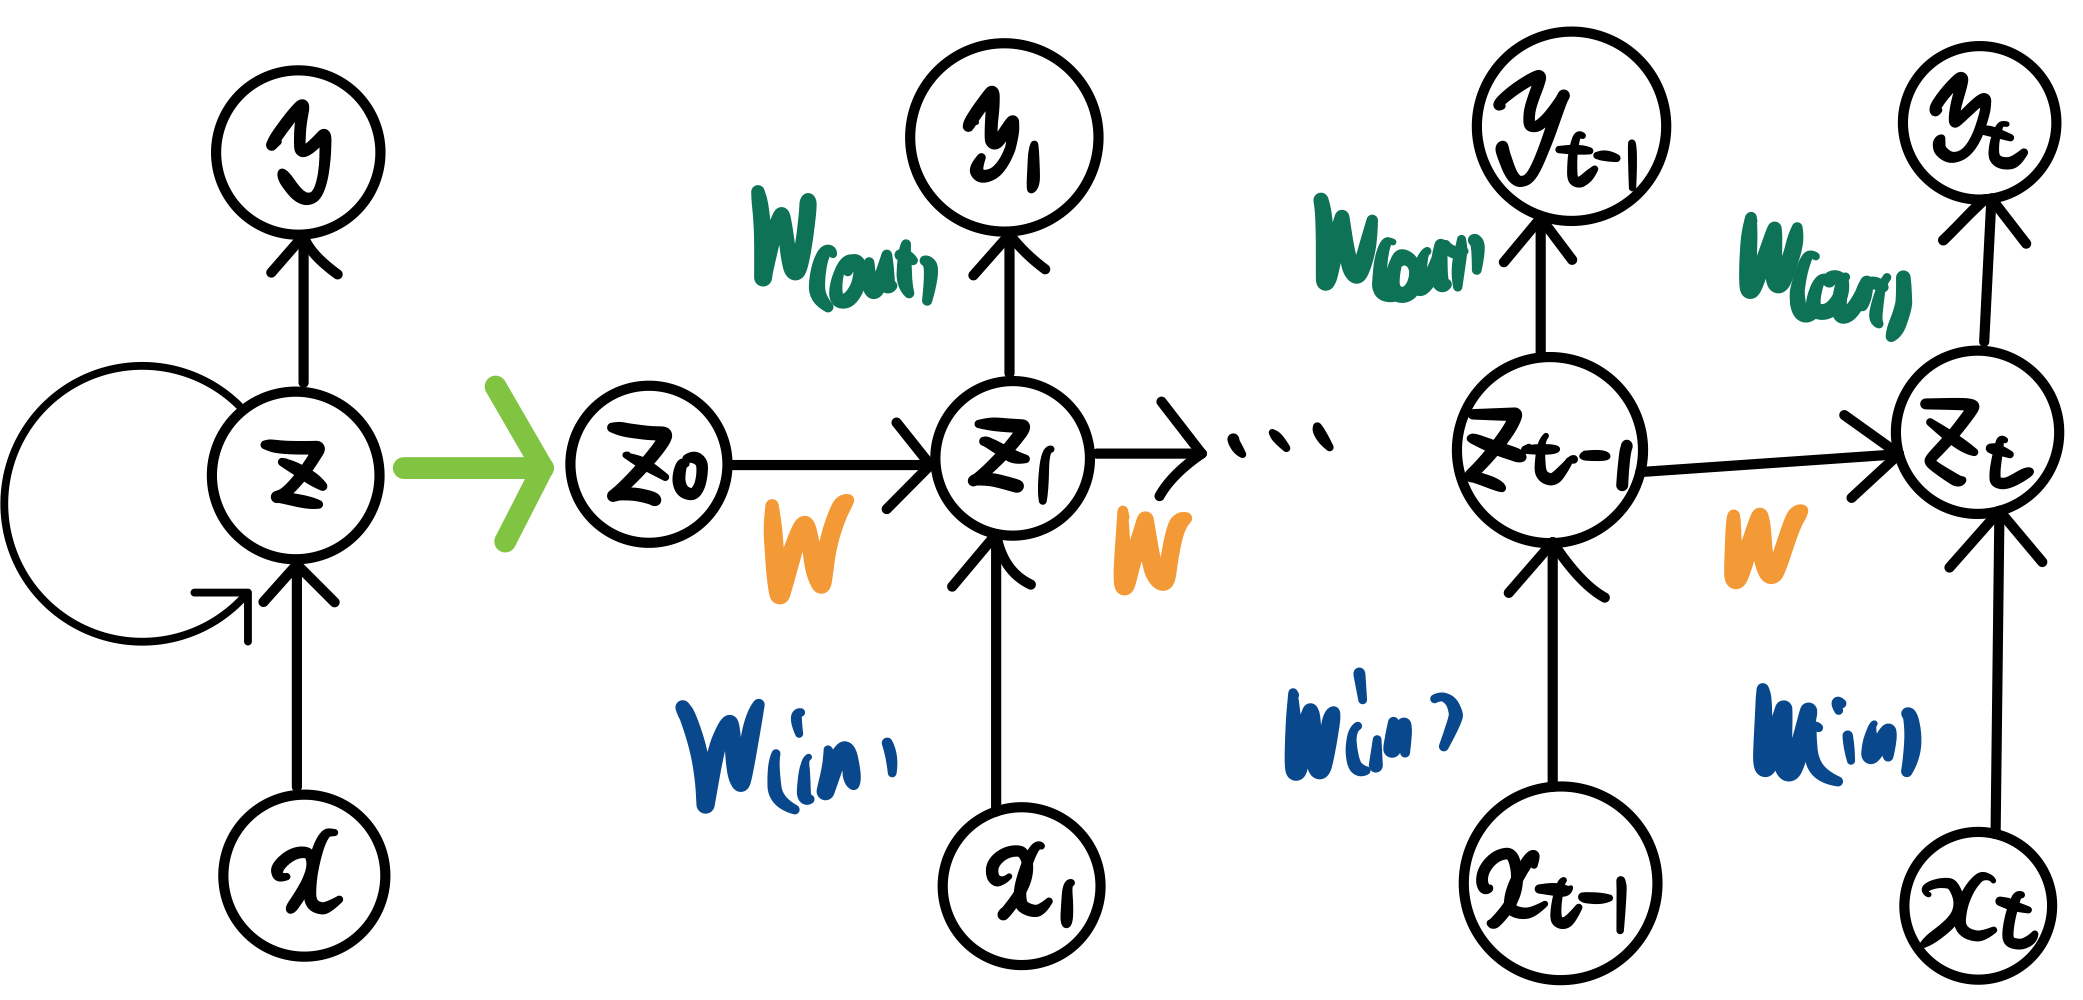

$u^{(t)} = W_{in}x^{(t)} + Wz^{(t-1)} + b$

$z^{(t)} = f(u^{(t)})$

$v^{(t)} = W_{out}z^{(t)} + c$

$y^{(t)} = g(v^{(t)})$

## 確認テスト

### RNNのネットワークには大きくわけて3つの重みがある。1つは入力から現在の中間層を定義する際にかけられる重み、1つは中間層から出力を定義する際にかけられる重みである。残り1つの重みについて説明せよ。（3分）

(解答)
残り1つの重みは、前の中間層から現在の中間層を定義する際にかけられる重みである。

---

### 連鎖律の原理を使い、dz/dxを求めよ。（5分）
$$z = t^2$$
$$t = x + y$$

(解答)

\begin{align}
\frac{dz}{dx} &= \frac{dz}{dt} \cdot \frac{dt}{dx} \\
&= 2t \cdot 1 \\
&= 2(x + y)
\end{align}

---

### 下図のy1をx・s0・s1・win・w・woutを用いて数式で表せ。※バイアスは任意の文字で定義せよ。※また中間層の出力にシグモイド関数g(x)を作用させよ。（7分）

(解答)

\begin{align}
y_1 &= g(W_{(out)} \cdot s_1 + c) \\
&= g(W_{(out)} \cdot f(W_{(in)} \cdot x_1 + W \cdot s_0 + b) + c)
\end{align}

---

## 演習チャレンジ

### 以下は再帰型ニューラルネットワークにおいて構文木を入力として再帰的に文全体の表現ベクトルを得るプログラムである。ただし、ニューラルネットワークの重みパラメータはグローバル変数として定義してあるものとし、activation関数はなんらかの活性化関数であるとする。木構造は再帰的な辞書で定義してあり、rootが最も外側の辞書であると仮定する。（く）にあてはまるのはどれか。

（1）W.dot(left + right)

（2）W.dot(np.concatenate([left, right]))

（3）W.dot(left * right)

（4）W.dot(np.maximum(left, right))


```python
def traverse(node):
    """
    node: tree node, recursive dict, {left: node', right: node''}
          if leaf, word embed vector, (embed_size,)

    W: weights, global variable, (embed_size, 2*embed_size)
    b: bias, global variable, (embed_size,)
    """
    if not isinstance(node, dict):
        v = node
    else:
        left = traverse(node['left'])
        right = traverse(node['right'])
        v = _activation(W.dot(np.concatenate([left, right])) # (く)
    return v

```

(解答) 2

---

### 左の図はBPTTを行うプログラムである。なお簡単化のため活性化関数は恒等関数であるとする。また、calculate_dout関数は損失関数を出力に関して偏微分した値を返す関数であるとする。（お）にあてはまるのはどれか。

（1）delta_t.dot(W)

（2）delta_t.dot(U)

（3）delta_t.dot(V)

（4）delta_t* V

```python
def bptt(xs, ys, W, U, V):
    """
    ys: labels, (batch_size, n_seq, output_size)
    """
    # 順伝播
    hiddens, outputs = rnn_net(xs, W, U, V)
    # 損失関数のW, Y, Vに関する偏微分値
    dW = np.zeros_like(W) # dL/dW
    dU = np.zeros_like(U) # dL/dU
    dV = np.zeros_like(V) # dL/dV
    # 損失関数の出力値に関する偏微分値
    do = _claculate_do(outputs, ys) # dL/do, (batch_size, n_seq, output_size)
    
    batch_size, n_seq = ys.shape[:2]
    # 時間を逆方向にたどり、パラメータの偏微分値を計算(バックプロパゲーション)
    # dL/dV = do/dV・dL/do = h・dL/do
    # dL/dW = do/dW・dL/do
    # dL/dU = do/dU・dL/do
    # do/dW = (dh_{t}/dW・d/dh_{t} + dh_{t-1}/dW・d/dh_{t-1} + ・・・)o_{t}
    #       = (x_{t} + x_{t-1}・U + x_{t-2}・U^2 + ・・・)・V
    # do/dU = (dh_{t}/dU・d/dh_{t} + dh_{t-1}/dU・d/dh_{t-1} + ・・・)o_{t}
    #       = (h_{t-1} + h_{t-2}・U + h_{t-3}・U^2 + ・・・)・V
    
    for t in reversed(range(n_seq)):
        dv += np.dot(do[:, t].T, hiddens[:, t]) / batch_size
        delta_t = do[:, t].dot(V)
        # 時間tの出力は時間t以前の中間層すべてに依存するため
        # W, Uはさらに遡って計算
        for bptt_step in reversed(range(t+1)):
            dW += np.dot(delta_t.T, xs[:, bptt_step]) / batch_size
            dU += np.dot(delta_t.T, hiddens[:, bptt_step-1]) / batch_size
            delta_t = delta_t.dot(U) # (お)
    return dW, dU, dV
```

(解答)　2

---

## 実装演習

iters:0
Loss:1.741283745392422
Pred:[0 1 1 1 1 1 1 0]
True:[1 0 0 0 1 1 0 1]
124 + 17 = 126
------------
iters:100
Loss:1.0170627741095761
Pred:[0 0 0 0 1 0 1 0]
True:[0 0 1 1 1 1 0 1]
41 + 20 = 10
------------
iters:200
Loss:1.2331168894333024
Pred:[0 1 0 0 0 1 1 0]
True:[0 1 1 1 0 0 0 1]
78 + 35 = 70
------------
iters:300
Loss:1.1691750000511547
Pred:[1 1 0 1 0 0 1 0]
True:[1 0 1 1 1 1 0 1]
80 + 109 = 210
------------
iters:400
Loss:1.116750619477867
Pred:[0 1 0 0 1 0 1 0]
True:[0 1 1 1 0 0 0 0]
43 + 69 = 74
------------
iters:500
Loss:1.1187087777118927
Pred:[0 1 1 1 1 0 1 0]
True:[1 0 0 0 0 0 0 0]
123 + 5 = 122
------------
iters:600
Loss:0.9072191082460926
Pred:[0 0 1 0 0 0 0 0]
True:[0 1 0 0 0 1 1 0]
51 + 19 = 32
------------
iters:700
Loss:0.7861267434771919
Pred:[0 0 0 0 1 1 1 1]
True:[0 0 0 0 1 0 0 0]
7 + 1 = 15
------------
iters:800
Loss:1.09851172852481
Pred:[0 1 1 1 1 1 1 0]
True:[0 1 0 0 1 1 0 0]
61 + 15 = 126
------------
iters:900
Loss:0.8639924616324245
Pred:[1 0 0 0 

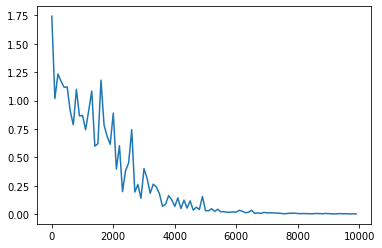

In [1]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

# def d_tanh(x):



# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier


# He



# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

iters:0
Loss:2.5191836572467223
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 1 1 1 0]
104 + 86 = 0
------------
iters:100
Loss:0.9789083812607504
Pred:[1 0 0 0 0 0 1 1]
True:[0 1 1 0 0 0 1 1]
48 + 51 = 131
------------
iters:200
Loss:1.1029358805190521
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 0 0 1 0 0]
60 + 104 = 255
------------
iters:300
Loss:0.9863929691502712
Pred:[0 0 0 0 0 0 1 0]
True:[0 1 1 0 1 0 0 1]
31 + 74 = 2
------------
iters:400
Loss:1.1100377618430182
Pred:[0 0 0 0 0 0 1 0]
True:[1 0 1 0 0 1 0 1]
79 + 86 = 2
------------
iters:500
Loss:0.9824841169638724
Pred:[0 0 1 0 1 0 1 1]
True:[1 0 1 0 0 1 1 0]
58 + 108 = 43
------------
iters:600
Loss:0.8962309896845109
Pred:[1 0 1 0 0 0 1 0]
True:[1 0 0 0 0 0 1 0]
91 + 39 = 162
------------
iters:700
Loss:1.1517018433146164
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 0 1 0 1]
39 + 14 = 0
------------
iters:800
Loss:1.1233952407787293
Pred:[0 0 0 0 0 0 1 0]
True:[1 0 1 1 1 1 0 0]
89 + 99 = 2
------------
iters:900
Loss:1.1086062939874934
Pred:[0 0 1 0

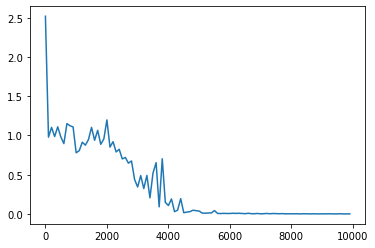

In [2]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

# LSTM

## 概要

RNNでは、時系列を遡れば遡るほど、勾配が消失(増加)していくため、長い時系列の学習が困難であった。LSTM(Long short-term memory)は、この勾配消失問題(勾配爆発問題)を解決するためにRNNの構造自体を変えたものである。
LSTMはCEC(Cconstant Error Carousel)と、3つのゲート(入力ゲート・出力ゲート・忘却ゲート)から成る。
CECは現時刻の状態と過去から現時刻までの必要な情報を保持する機能のみを持たせたもので、時間を遡っても勾配が変わらない(常に1になる)ように設定される。このためCECは、入力データについて時間依存度に関係なく重みが一律となるためCECそれ自体では学習特性が無い(ニューラルネットワークとして機能しない)。そこで、入力ゲートおよび出力ゲートを配置し、これらにCECに何を記憶させるか、CECから何を出力させるかを学習させる。またCECは過去の情報を保持し続けるため忘却ゲートによって不要な過去の情報を削除させる。

- LSTMの全体像

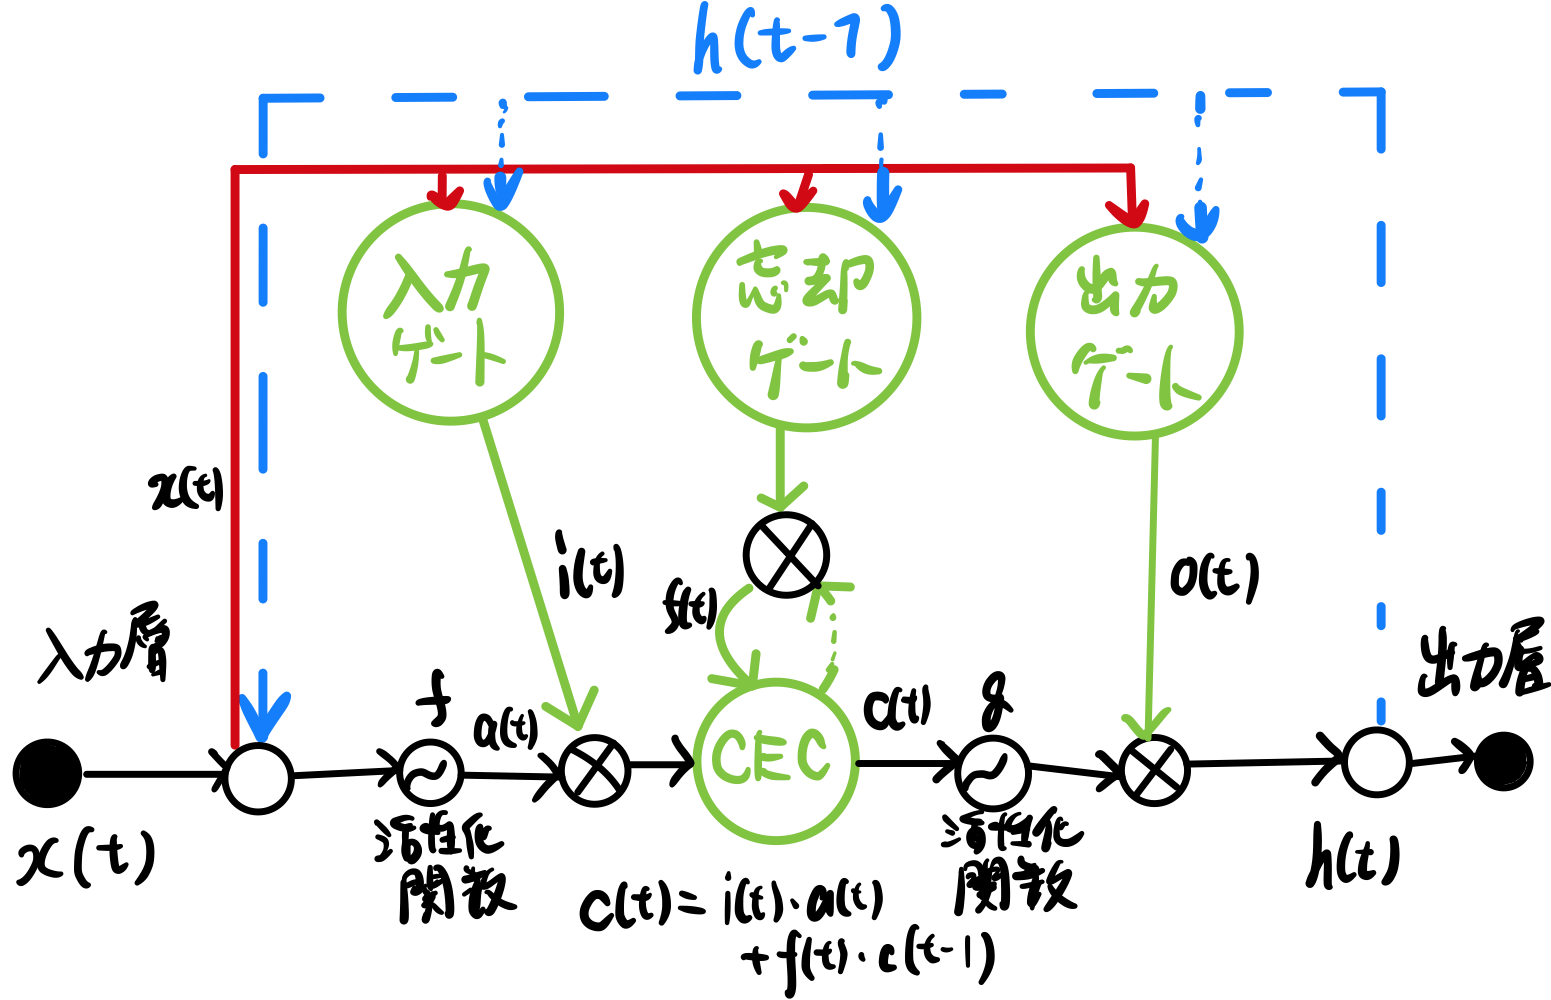

## 確認テスト

### シグモイド関数を微分した時、入力値が0の時に最大値をとる。その値として正しいものを選択肢から選べ。（1分）

（1）0.15

（2）0.25

（3）0.35

（4）0.45

(解答)
2

---

### 以下の文章をLSTMに入力し空欄に当てはまる単語を予測したいとする。文中の「とても」という言葉は空欄の予測においてなくなっても影響を及ぼさないと考えられる。このような場合、どのゲートが作用すると考えられるか。「映画おもしろかったね。ところで、とてもお腹が空いたから何か____。」（3分）

(解答)
忘却ゲート

---

## 演習チャレンジ

### RNNや深いモデルでは勾配の消失または爆発が起こる傾向がある。勾配爆発を防ぐために勾配のクリッピングを行うという手法がある。具体的には勾配のノルムがしきい値を超えたら、勾配のノルムをしきい値に正規化するというものである。以下は勾配のクリッピングを行う関数である。（さ）にあてはまるのはどれか。

（1）gradient * rate

（2）gradient / norm

（3）gradient / threshold

（4）np.maximum(gradient, threshold)

```python
def gradient_clipping(grad, threshold):
    """
    grad: gradient
    """
    norm = np.linalg.norm(grad)
    rate = threshold / norm
    if rate < 1:
        return grad * rate # (さ)
    return grad
```

(解答)
2

---

### 以下のプログラムはLSTMの順伝播を行うプログラムである。ただし_sigmoid関数は要素ごとにシグモイド関数を作用させる関数である。（け）にあてはまるのはどれか。

（1）output_gate* a + forget_gate* c

（2）forget_gate* a + output_gate* c

（3）input_gate* a + forget_gate* c

（4）forget_gate* a + input_gate* c

```python
def lstm(x, prev_h, prev_c, W, U, b):
    """
    x: inputs, (batch_size, input_size)
    prev_h: outputs at the previous time step, (batch_size, state_size)
    prev_c: cell states at the previous time step, (batch_size, state_size)
    W: upward weights, (4*state_size, input_size)
    U: lateral weights, (4*state_size, state_size)
    b: bias, (4*state_size, )
    """
    # セルへの入力やゲートをまとめて計算し、分割
    lstm_in = _activation(x.dot(W.T) + prev_h.dot(U.T) + b)
    a, i, f, o = np.hsplit(lstm_in, 4)
    
    # 値を変換、セルへの入力:(-1, 1), ゲート:(0, 1)
    a = np.tanh(a)
    input_gate = _sigmoid(i)
    forget_gate = _sigmoid(f)
    output_gate = _sigmoid(o)
    
    # セルの状態を更新し、中間層の出力を計算
    c = input_gate * a + forget_gate * c # (け)
    h = output_gate * np.tanh(c) 
    return c, h
```

(解答)
3

---

## 実装演習

In [3]:
import tensorflow as tf
import numpy as np
import re
import glob
import collections
import random
import pickle
import time
import datetime
import os

# logging levelを変更
tf.logging.set_verbosity(tf.logging.ERROR)

class Corpus:
    def __init__(self):
        self.unknown_word_symbol = "<???>" # 出現回数の少ない単語は未知語として定義しておく
        self.unknown_word_threshold = 3 # 未知語と定義する単語の出現回数の閾値
        self.corpus_file = "./corpus/**/*.txt"
        self.corpus_encoding = "utf-8"
        self.dictionary_filename = "./data_for_predict/word_dict.dic"
        self.chunk_size = 5
        self.load_dict()

        words = []
        for filename in glob.glob(self.corpus_file, recursive=True):
            with open(filename, "r", encoding=self.corpus_encoding) as f:

                # word breaking
                text = f.read()
                # 全ての文字を小文字に統一し、改行をスペースに変換
                text = text.lower().replace("\n", " ")
                # 特定の文字以外の文字を空文字に置換する
                text = re.sub(r"[^a-z '\-]", "", text)
                # 複数のスペースはスペース一文字に変換
                text = re.sub(r"[ ]+", " ", text)

                # 前処理： '-' で始まる単語は無視する
                words = [ word for word in text.split() if not word.startswith("-")]


        self.data_n = len(words) - self.chunk_size
        self.data = self.seq_to_matrix(words)

    def prepare_data(self):
        """
        訓練データとテストデータを準備する。
        data_n = ( text データの総単語数 ) - chunk_size
        input: (data_n, chunk_size, vocabulary_size)
        output: (data_n, vocabulary_size)
        """

        # 入力と出力の次元テンソルを準備
        all_input = np.zeros([self.chunk_size, self.vocabulary_size, self.data_n])
        all_output = np.zeros([self.vocabulary_size, self.data_n])

        # 準備したテンソルに、コーパスの one-hot 表現(self.data) のデータを埋めていく
        # i 番目から ( i + chunk_size - 1 ) 番目までの単語が１組の入力となる
        # このときの出力は ( i + chunk_size ) 番目の単語
        for i in range(self.data_n):
            all_output[:, i] = self.data[:, i + self.chunk_size] # (i + chunk_size) 番目の単語の one-hot ベクトル
            for j in range(self.chunk_size):
                all_input[j, :, i] = self.data[:, i + self.chunk_size - j - 1]

        # 後に使うデータ形式に合わせるために転置を取る
        all_input = all_input.transpose([2, 0, 1])
        all_output = all_output.transpose()

        # 訓練データ：テストデータを 4 : 1 に分割する
        training_num = ( self.data_n * 4 ) // 5
        return all_input[:training_num], all_output[:training_num], all_input[training_num:], all_output[training_num:]


    def build_dict(self):
        # コーパス全体を見て、単語の出現回数をカウントする
        counter = collections.Counter()
        for filename in glob.glob(self.corpus_file, recursive=True):
            with open(filename, "r", encoding=self.corpus_encoding) as f:

                # word breaking
                text = f.read()
                # 全ての文字を小文字に統一し、改行をスペースに変換
                text = text.lower().replace("\n", " ")
                # 特定の文字以外の文字を空文字に置換する
                text = re.sub(r"[^a-z '\-]", "", text)
                # 複数のスペースはスペース一文字に変換
                text = re.sub(r"[ ]+", " ", text)

                # 前処理： '-' で始まる単語は無視する
                words = [word for word in text.split() if not word.startswith("-")]

                counter.update(words)

        # 出現頻度の低い単語を一つの記号にまとめる
        word_id = 0
        dictionary = {}
        for word, count in counter.items():
            if count <= self.unknown_word_threshold:
                continue

            dictionary[word] = word_id
            word_id += 1
        dictionary[self.unknown_word_symbol] = word_id

        print("総単語数：", len(dictionary))

        # 辞書を pickle を使って保存しておく
        with open(self.dictionary_filename, "wb") as f:
            pickle.dump(dictionary, f)
            print("Dictionary is saved to", self.dictionary_filename)

        self.dictionary = dictionary

        print(self.dictionary)

    def load_dict(self):
        with open(self.dictionary_filename, "rb") as f:
            self.dictionary = pickle.load(f)
            self.vocabulary_size = len(self.dictionary)
            self.input_layer_size = len(self.dictionary)
            self.output_layer_size = len(self.dictionary)
            print("総単語数: ", self.input_layer_size)

    def get_word_id(self, word):
        # print(word)
        # print(self.dictionary)
        # print(self.unknown_word_symbol)
        # print(self.dictionary[self.unknown_word_symbol])
        # print(self.dictionary.get(word, self.dictionary[self.unknown_word_symbol]))
        return self.dictionary.get(word, self.dictionary[self.unknown_word_symbol])

    # 入力された単語を one-hot ベクトルにする
    def to_one_hot(self, word):
        index = self.get_word_id(word)
        data = np.zeros(self.vocabulary_size)
        data[index] = 1
        return data

    def seq_to_matrix(self, seq):
        print(seq)
        data = np.array([self.to_one_hot(word) for word in seq]) # (data_n, vocabulary_size)
        return data.transpose() # (vocabulary_size, data_n)

class Language:
    """
    input layer: self.vocabulary_size
    hidden layer: rnn_size = 30
    output layer: self.vocabulary_size
    """

    def __init__(self):
        self.corpus = Corpus()
        self.dictionary = self.corpus.dictionary
        self.vocabulary_size = len(self.dictionary) # 単語数
        self.input_layer_size = self.vocabulary_size # 入力層の数
        self.hidden_layer_size = 30 # 隠れ層の RNN ユニットの数
        self.output_layer_size = self.vocabulary_size # 出力層の数
        self.batch_size = 128 # バッチサイズ
        self.chunk_size = 5 # 展開するシーケンスの数。c_0, c_1, ..., c_(chunk_size - 1) を入力し、c_(chunk_size) 番目の単語の確率が出力される。
        self.learning_rate = 0.005 # 学習率
        self.epochs = 1000 # 学習するエポック数
        self.forget_bias = 1.0 # LSTM における忘却ゲートのバイアス
        self.model_filename = "./data_for_predict/predict_model.ckpt"
        self.unknown_word_symbol = self.corpus.unknown_word_symbol

    def inference(self, input_data, initial_state):
        """
        :param input_data: (batch_size, chunk_size, vocabulary_size) 次元のテンソル
        :param initial_state: (batch_size, hidden_layer_size) 次元の行列
        :return:
        """
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01))
        hidden_b = tf.Variable(tf.ones([self.hidden_layer_size]))
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], stddev=0.01))
        output_b = tf.Variable(tf.ones([self.output_layer_size]))

        # BasicLSTMCell, BasicRNNCell は (batch_size, hidden_layer_size) が chunk_size 数ぶんつながったリストを入力とする。
        # 現時点での入力データは (batch_size, chunk_size, input_layer_size) という３次元のテンソルなので
        # tf.transpose や tf.reshape などを駆使してテンソルのサイズを調整する。

        input_data = tf.transpose(input_data, [1, 0, 2]) # 転置。(chunk_size, batch_size, vocabulary_size)
        input_data = tf.reshape(input_data, [-1, self.input_layer_size]) # 変形。(chunk_size * batch_size, input_layer_size)
        input_data = tf.matmul(input_data, hidden_w) + hidden_b # 重みWとバイアスBを適用。 (chunk_size, batch_size, hidden_layer_size)
        input_data = tf.split(input_data, self.chunk_size, 0) # リストに分割。chunk_size * (batch_size, hidden_layer_size)

        # RNN のセルを定義する。RNN Cell の他に LSTM のセルや GRU のセルなどが利用できる。
        cell = tf.nn.rnn_cell.BasicRNNCell(self.hidden_layer_size)
        outputs, states = tf.nn.static_rnn(cell, input_data, initial_state=initial_state)
        
        # 最後に隠れ層から出力層につながる重みとバイアスを処理する
        # 最終的に softmax 関数で処理し、確率として解釈される。
        # softmax 関数はこの関数の外で定義する。
        output = tf.matmul(outputs[-1], output_w) + output_b

        return output

    def loss(self, logits, labels):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

        return cost

    def training(self, cost):
        # 今回は最適化手法として Adam を選択する。
        # ここの AdamOptimizer の部分を変えることで、Adagrad, Adadelta などの他の最適化手法を選択することができる
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(cost)

        return optimizer

    def train(self):
        # 変数などの用意
        input_data = tf.placeholder("float", [None, self.chunk_size, self.input_layer_size])
        actual_labels = tf.placeholder("float", [None, self.output_layer_size])
        initial_state = tf.placeholder("float", [None, self.hidden_layer_size])

        prediction = self.inference(input_data, initial_state)
        cost = self.loss(prediction, actual_labels)
        optimizer = self.training(cost)
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(actual_labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

        # TensorBoard で可視化するため、クロスエントロピーをサマリーに追加
        tf.summary.scalar("Cross entropy: ", cost)
        summary = tf.summary.merge_all()

        # 訓練・テストデータの用意
        # corpus = Corpus()
        trX, trY, teX, teY = self.corpus.prepare_data()
        training_num = trX.shape[0]

        # ログを保存するためのディレクトリ
        timestamp = time.time()
        dirname = datetime.datetime.fromtimestamp(timestamp).strftime("%Y%m%d%H%M%S")

        # ここから実際に学習を走らせる
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            summary_writer = tf.summary.FileWriter("./log/" + dirname, sess.graph)

            # エポックを回す
            for epoch in range(self.epochs):
                step = 0
                epoch_loss = 0
                epoch_acc = 0

                # 訓練データをバッチサイズごとに分けて学習させる (= optimizer を走らせる)
                # エポックごとの損失関数の合計値や（訓練データに対する）精度も計算しておく
                while (step + 1) * self.batch_size < training_num:
                    start_idx = step * self.batch_size
                    end_idx = (step + 1) * self.batch_size

                    batch_xs = trX[start_idx:end_idx, :, :]
                    batch_ys = trY[start_idx:end_idx, :]

                    _, c, a = sess.run([optimizer, cost, accuracy],
                                       feed_dict={input_data: batch_xs,
                                                  actual_labels: batch_ys,
                                                  initial_state: np.zeros([self.batch_size, self.hidden_layer_size])
                                                  }
                                       )
                    epoch_loss += c
                    epoch_acc += a
                    step += 1

                # コンソールに損失関数の値や精度を出力しておく
                print("Epoch", epoch, "completed ouf of", self.epochs, "-- loss:", epoch_loss, " -- accuracy:",
                      epoch_acc / step)

                # Epochが終わるごとにTensorBoard用に値を保存
                summary_str = sess.run(summary, feed_dict={input_data: trX,
                                                           actual_labels: trY,
                                                           initial_state: np.zeros(
                                                               [trX.shape[0],
                                                                self.hidden_layer_size]
                                                           )
                                                           }
                                       )
                summary_writer.add_summary(summary_str, epoch)
                summary_writer.flush()

            # 学習したモデルも保存しておく
            saver = tf.train.Saver()
            saver.save(sess, self.model_filename)

            # 最後にテストデータでの精度を計算して表示する
            a = sess.run(accuracy, feed_dict={input_data: teX, actual_labels: teY,
                                              initial_state: np.zeros([teX.shape[0], self.hidden_layer_size])})
            print("Accuracy on test:", a)


    def predict(self, seq):
        """
        文章を入力したときに次に来る単語を予測する
        :param seq: 予測したい単語の直前の文字列。chunk_size 以上の単語数が必要。
        :return:
        """

        # 最初に復元したい変数をすべて定義してしまいます
        tf.reset_default_graph()
        input_data = tf.placeholder("float", [None, self.chunk_size, self.input_layer_size])
        initial_state = tf.placeholder("float", [None, self.hidden_layer_size])
        prediction = tf.nn.softmax(self.inference(input_data, initial_state))
        predicted_labels = tf.argmax(prediction, 1)

        # 入力データの作成
        # seq を one-hot 表現に変換する。
        words = [word for word in seq.split() if not word.startswith("-")]
        x = np.zeros([1, self.chunk_size, self.input_layer_size])
        for i in range(self.chunk_size):
            word = seq[len(words) - self.chunk_size + i]
            index = self.dictionary.get(word, self.dictionary[self.unknown_word_symbol])
            x[0][i][index] = 1
        feed_dict = {
            input_data: x, # (1, chunk_size, vocabulary_size)
            initial_state: np.zeros([1, self.hidden_layer_size])
        }

        # tf.Session()を用意
        with tf.Session() as sess:
            # 保存したモデルをロードする。ロード前にすべての変数を用意しておく必要がある。
            saver = tf.train.Saver()
            saver.restore(sess, self.model_filename)

            # ロードしたモデルを使って予測結果を計算
            u, v = sess.run([prediction, predicted_labels], feed_dict=feed_dict)

            keys = list(self.dictionary.keys())


            # コンソールに文字ごとの確率を表示
            for i in range(self.vocabulary_size):
                c = self.unknown_word_symbol if i == (self.vocabulary_size - 1) else keys[i]
                print(c, ":", u[0][i])

            print("Prediction:", seq + " " + ("<???>" if v[0] == (self.vocabulary_size - 1) else keys[v[0]]))

        return u[0]


def build_dict():
    cp = Corpus()
    cp.build_dict()

if __name__ == "__main__":
    #build_dict()

    ln = Language()

    # 学習するときに呼び出す
    #ln.train()

    # 保存したモデルを使って単語の予測をする
    ln.predict("some of them looks like")


AttributeError: module 'tensorflow' has no attribute 'logging'

- 上記コードをGoogle Colaboratoryで回した結果

ストリーミング出力は最後の 5000 行に切り捨てられました。
beating : 1.3192031e-14
authentic : 1.4901815e-14
glow : 1.5293715e-14
oy : 1.4680216e-14
emotion : 1.4983698e-14
delight : 1.40041135e-14
nuclear : 1.4859978e-14
dropped : 1.4963249e-14
hiroshima : 1.3928354e-14
beings : 1.58225e-14
tens : 1.5364736e-14
burned : 1.3809686e-14
homeless : 1.564374e-14
albert : 1.4478778e-14
initiated : 1.3293369e-14
bomb : 1.3569628e-14
theoretical : 1.457712e-14
radio : 1.4376162e-14
traditionally : 1.3563315e-14
oi : 1.5766405e-14
souls : 1.4353587e-14
assigned : 1.401229e-14
gallery : 1.5750446e-14
easily : 1.5530112e-14
coins : 1.4903634e-14
timeless : 1.46241e-14
inevitably : 1.441188e-14
trips : 1.6643213e-14
expressions : 1.5180084e-14
raw : 1.2960633e-14
idioms : 1.2821029e-14
magic : 1.4076957e-14
handed : 1.3351558e-14
blonde : 1.2911681e-14
diamond : 1.4749793e-14
charity : 1.5063561e-14
ball : 1.5066348e-14
lipschitz : 1.3815008e-14
stone : 1.3465723e-14
sighed : 1.3959737e-14
feminist : 1.768686e-14
britain : 1.3061711e-14
movement : 1.476888e-14
largely : 1.4008122e-14
cruise : 1.38741574e-14
missiles : 1.5027001e-14
village : 1.4716776e-14
elsewhere : 2.7651998e-15
ignorant : 1.4561196e-14
jacket : 1.4211141e-14
centre : 1.4279449e-14
studies : 1.15517864e-11
bear : 1.28956345e-14
consists : 1.5735522e-14
rewriting : 1.5363506e-14
dawn : 1.6215152e-14
demonstrating : 1.3151383e-14
themes : 1.5186803e-14
advancement : 1.6285201e-14
agriculture : 1.494243e-14
despite : 1.4373009e-14
stupidity : 1.458983e-14
domination : 1.606088e-14
superiority : 1.5718182e-14
primitive : 1.3121365e-14
religions : 1.4678005e-14
egyptian : 1.3918767e-14
rulers : 1.3896219e-14
thesis : 1.4377505e-14
counting : 1.4958712e-14
track : 1.6071329e-14
accepts : 1.4374107e-14
speculation : 1.4989788e-14
laborers : 1.427806e-14
greek : 1.31711125e-14
historian : 1.4486539e-14
labour : 1.3591749e-14
blows : 1.4370434e-14
modern : 1.4101141e-14
researcher : 1.2356749e-14
commanded : 1.4580373e-14
sum : 1.4188174e-14
sixth : 2.4965813e-20
bc : 1.3925831e-14
pan : 1.365437e-14
flourished : 1.3517653e-14
welfare : 1.417492e-14
roman : 1.5056178e-14
nurse : 1.486012e-14
fourth : 1.4023893e-14
cultures : 1.3483252e-14
instrument : 1.4368486e-14
blood : 1.6514136e-10
bones : 1.5962022e-14
preferred : 1.4236262e-14
wild : 1.2597436e-14
destiny : 1.5494342e-14
paul : 1.3648252e-14
seller : 1.3574391e-14
purple : 1.385393e-14
ibid : 1.6552828e-14
array : 1.529427e-14
brilliant : 1.30507304e-14
unusual : 1.3509303e-14
inspiring : 1.40978055e-14
preceding : 1.3943504e-14
taste : 1.45532e-14
stroke : 1.5297713e-14
grim : 1.6048112e-14
clothing : 1.4420568e-14
campbell : 1.3259942e-14
analyses : 5.2380862e-08
emerging : 1.5700266e-14
islamic : 1.5424341e-14
connected : 1.4090575e-14
virgin : 1.3111759e-14
ancient : 1.612737e-14
treatment : 8.358758e-16
notably : 1.5322945e-14
etc : 1.4732109e-14
unlikely : 1.4600019e-14
ignored : 1.5555933e-14
gods : 1.4307447e-14
identity : 1.4529182e-14
meaningful : 1.4677109e-14
roots : 1.2780255e-14
wildly : 1.3738908e-14
disease : 1.1581906e-14
investigate : 1.3616426e-14
cure : 1.4511567e-14
blasts : 1.4174868e-14
symptoms : 1.2739781e-14
characterized : 3.2966694e-16
concludes : 1.4210762e-14
engage : 1.502892e-14
laurence : 1.3182825e-14
urdang : 1.4539825e-14
archaeology : 1.4420954e-14
fragile : 1.40878604e-14
turns : 1.5579125e-14
earliest : 1.5504955e-14
stages : 1.5241823e-14
destroyed : 1.4299509e-14
countless : 1.39520175e-14
generations : 1.3425255e-14
erosion : 1.2757677e-14
prehistoric : 1.3872147e-14
developers : 1.4215696e-14
fashionable : 1.5361395e-14
discover : 1.3942016e-14
greeks : 1.4001683e-14
romans : 1.4492371e-14
indians : 1.372097e-14
ruins : 1.4019695e-14
followed : 8.133028e-13
troy : 1.5077156e-14
artifacts : 1.4787455e-14
dating : 1.3462925e-14
pursuit : 1.2682322e-14
museums : 1.3607365e-14
classical : 1.5186774e-14
documented : 1.551451e-14
tablets : 1.4237186e-14
barely : 1.3549843e-14
identify : 1.3935609e-14
conclusions : 2.981352e-15
deep : 1.298107e-14
countryside : 1.4284243e-14
precious : 1.4119603e-14
clever : 1.4005878e-14
linguists : 1.461133e-14
germany : 1.2803971e-14
ancestors : 1.39647976e-14
jean : 1.4194129e-14
myriad : 1.3865216e-14
revealed : 1.5215971e-14
crete : 1.4761812e-14
indo-european : 1.30003455e-14
linguistic : 1.3608092e-14
undoubtedly : 1.4672825e-14
vanished : 1.4893887e-14
unimportant : 1.516142e-14
establish : 1.2562117e-14
dialect : 1.33473055e-14
examining : 3.0328796e-15
swedish : 1.4965705e-14
dutch : 1.3145539e-14
spanish : 1.2700308e-14
portuguese : 1.4012102e-14
remote : 1.412809e-14
varieties : 1.40877e-14
resort : 1.4761023e-14
fingers : 1.5386936e-14
toes : 1.5218961e-14
shifts : 1.58196e-14
nearby : 1.4071855e-14
hence : 1.40192135e-14
classified : 2.079495e-14
finnish : 1.5051067e-14
computers : 1.4321127e-14
emerged : 1.4656157e-14
linked : 1.4465222e-14
showing : 1.5335836e-14
constantly : 1.4577925e-14
accuracy : 1.4787879e-14
trees : 1.5207904e-14
classification : 1.3247681e-14
grammar : 1.3984655e-14
resemble : 1.4824281e-14
suitable : 1.4846324e-14
soft : 1.3807131e-14
organize : 1.3420161e-14
alongside : 1.40888015e-14
correlated : 1.4005289e-14
digging : 1.2600607e-14
disappeared : 1.2701028e-15
sites : 1.3466828e-14
dim : 1.4110693e-14
tearing : 1.31697055e-14
erected : 1.3893331e-14
archaeological : 1.4807213e-14
examines : 1.33271325e-14
significance : 1.3340383e-14
interfere : 1.4402343e-14
finds : 1.5591046e-14
importance : 1.4196944e-14
yield : 5.010419e-14
notwithstanding : 1.6167101e-14
investigations : 1.4933542e-14
insight : 1.36747e-14
sprang : 1.4794847e-14
descended : 1.2754005e-14
nonetheless : 1.5100238e-14
renfrew : 1.5469596e-14
eastward : 1.5501289e-14
influences : 1.3669668e-14
recognizable : 1.4326044e-14
manifestations : 1.4495356e-14
assess : 1.5238423e-14
validity : 1.3740272e-14
contention : 1.4365992e-14
separated : 1.4133399e-14
iran : 1.4755787e-14
pakistan : 1.36502045e-14
eastern : 1.4120949e-14
indigenous : 1.3951166e-14
pottery : 1.32958025e-14
interpreted : 1.4830842e-14
elite : 1.4880826e-14
presentation : 1.5503388e-14
territory : 1.32751755e-14
convincing : 1.4581013e-14
overly : 1.3877599e-14
boots : 1.3068964e-14
installation : 1.4992532e-14
synonym : 1.4444519e-14
manual : 1.517444e-14
descriptive : 2.161415e-16
spelt : 1.32154775e-14
paragraph : 1.6693347e-14
arrangement : 1.32448255e-14
senses : 1.377659e-14
synonyms : 1.5545257e-14
highlight : 1.415941e-14
desired : 1.428566e-14
highlighted : 1.4129032e-14
involves : 1.32786196e-14
mathematics : 1.5528069e-14
round : 1.537523e-14
alternatives : 1.4950242e-14
jumped : 1.5207064e-14
variants : 1.4942913e-14
leapt : 1.4591278e-14
preference : 1.456792e-14
supplies : 1.3680334e-14
quantity : 1.4539993e-14
reality : 1.3971324e-14
allen : 1.5338149e-14
walker : 1.3322659e-14
scholarly : 1.3756633e-14
informal : 1.4175732e-14
crop : 1.4228905e-14
station : 1.3972072e-14
stations : 1.4307037e-14
harold : 1.5343151e-14
pilgrims : 1.43575e-14
bells : 1.3954201e-14
ring : 1.4640285e-14
allowance : 1.3697358e-14
flag : 1.4928302e-14
leaning : 1.5744408e-14
invisible : 1.4881337e-14
ensuring : 1.6024039e-14
ample : 1.3214495e-14
guests : 1.39058974e-14
greene : 1.4436035e-14
jack : 1.4587412e-14
genre : 1.2613856e-14
occasional : 1.482411e-14
hidden : 1.4489413e-14
entry : 1.48382e-14
suffer : 1.4267252e-14
affecting : 1.31283746e-14
responds : 1.4613782e-14
co : 1.39254326e-14
jr : 1.3156652e-14
associate : 1.4399187e-14
warfare : 1.36874095e-14
characteristic : 1.28541815e-14
soldier : 1.361183e-14
rank : 1.4279856e-14
thus : 1.881336e-13
corresponding : 1.4217323e-14
demands : 1.5007152e-14
goods : 1.524598e-14
whiskey : 1.503047e-14
readily : 1.4224646e-14
acquaintance : 1.5252438e-14
tackle : 1.47715e-14
tongue : 1.4423706e-14
observations : 1.5029781e-14
pet : 1.5658607e-14
gathering : 1.4237675e-14
unknown : 1.408563e-14
disclaimer : 1.4702381e-14
load : 1.3279684e-14
brass : 1.4309604e-14
monkey : 1.5367754e-14
ship : 1.5012992e-14
employed : 1.3185365e-14
fetch : 1.5836992e-14
wooden : 1.3994662e-14
metal : 1.5577907e-14
pyramid : 1.5066665e-14
cannon : 1.29383054e-14
iron : 1.5087053e-14
heavy : 1.5619589e-14
freeze : 1.4260425e-14
household : 1.5057613e-14
ornaments : 1.504573e-14
centuries : 1.3794417e-14
imported : 1.5311666e-14
grace : 1.4768346e-14
edwardian : 1.4627671e-14
shops : 1.6565335e-14
ears : 1.3367459e-14
eg : 1.3121291e-14
fu : 1.2982356e-14
representing : 1.4591445e-14
clusters : 1.4397868e-14
produces : 1.4441158e-14
coffee : 1.5019263e-14
expresses : 1.3559511e-14
frantic : 1.4242075e-14
scrap : 1.38221776e-14
safire : 1.4940692e-14
writes : 1.478176e-14
column : 3.5721343e-11
magazine : 1.5923982e-14
editorial : 1.4472703e-14
style : 1.4199219e-14
reflected : 1.4494804e-14
columns : 1.2845703e-14
n : 6.154168e-11
y : 1.5138823e-14
cute : 1.3752437e-14
uttered : 1.4461995e-14
andrew : 1.3628403e-14
norman : 1.3754116e-14
arch : 1.5642098e-14
knee : 1.4114972e-14
pronounced : 1.3317375e-14
appeal : 1.31358894e-14
containing : 6.207775e-14
deliberately : 1.2572329e-14
collections : 1.276929e-14
prints : 1.3307549e-14
inclusion : 1.443598e-14
interaction : 1.3460588e-14
accused : 1.3740061e-14
influential : 1.4564808e-14
libraries : 1.5370597e-14
mc : 1.3559228e-14
m : 1.4481263e-14
meaningless : 1.6277436e-14
conventional : 1.4623319e-14
physics : 1.5104212e-14
stab : 1.33935924e-14
heading : 1.4686601e-14
ate : 1.4439064e-14
futile : 1.3942974e-14
rely : 1.3279684e-14
seeking : 1.3883636e-14
loose : 1.448582e-14
lacking : 1.619089e-14
lo : 1.3906692e-14
exclamation : 1.4163516e-14
utility : 1.4951095e-14
fantasy : 1.3746981e-14
bull : 1.493001e-14
johns : 1.4295717e-14
faults : 1.39348905e-14
accompanying : 1.4208187e-14
abroad : 1.5346956e-14
battle : 1.388165e-14
purity : 1.3701226e-14
condemned : 1.3871088e-14
newly : 1.5114356e-14
academy : 1.4355064e-14
museum : 1.5592176e-14
boycott : 1.4962164e-14
regrets : 1.5237347e-14
supplement : 1.2841586e-14
harsh : 1.4400998e-14
participating : 1.4018866e-14
arises : 1.483237e-14
carriage : 1.431236e-14
fred : 1.3924848e-14
approaching : 1.4457418e-14
obstacle : 1.3052671e-14
cross-country : 1.3745802e-14
grand : 4.33887e-14
eliminated : 1.4181735e-14
cannons : 1.4380385e-14
marvelous : 1.3592372e-14
rationale : 1.31295265e-14
observation : 1.3750706e-14
increasingly : 1.5275407e-14
widespread : 1.4446227e-14
familiarity : 1.384994e-14
mythology : 1.3075397e-14
unable : 1.34013606e-14
oats : 1.4565807e-14
expression : 1.485992e-14
event : 1.290363e-14
dull : 1.539357e-14
square : 7.18145e-10
spill : 1.33738345e-14
calculated : 2.742405e-11
pi : 1.3175183e-14
borrowed : 1.6946595e-14
animal : 1.3663124e-14
suggestions : 1.3709486e-14
nonsense : 1.5974694e-14
maps : 1.5928417e-14
geography : 1.6357829e-14
branch : 1.409786e-14
dialects : 1.4856492e-14
prominent : 1.5000969e-14
practitioners : 1.4588664e-14
wright : 1.4697978e-14
proceeded : 1.3878764e-14
conducted : 1.4246965e-14
survey : 1.5845511e-14
studied : 1.727015e-15
extracted : 1.4420899e-14
aided : 1.33805185e-14
delicious : 1.453575e-14
selected : 1.4562751e-14
boundary : 1.2842567e-14
coast : 1.3405707e-14
institutions : 1.5086246e-14
indulge : 1.529007e-14
connect : 1.3899692e-14
employ : 1.40102045e-14
iso : 1.4691786e-14
oceans : 1.37836875e-14
undertaken : 1.4071586e-14
strict : 1.5593604e-14
maintenance : 1.4353942e-14
boundaries : 1.654803e-14
periodicals : 1.39095575e-14
television : 1.6065721e-14
establishment : 1.5162808e-14
prestige : 1.3140651e-14
slower : 1.441243e-14
speeding : 1.5373999e-14
literary : 1.4944853e-14
varying : 1.4044612e-14
colleges : 1.4154171e-14
universities : 1.3608143e-14
profession : 1.4631298e-14
apparent : 1.5066461e-14
oxford : 1.4100764e-14
series : 1.4629121e-14
photographs : 1.3660258e-14
samuel : 1.4317193e-14
devil : 1.474234e-14
railroad : 1.5355332e-14
creations : 1.465336e-14
colorful : 1.3661979e-14
suicide : 1.5647799e-14
reveals : 1.578187e-14
recommend : 1.3093764e-14
specialized : 1.3958566e-14
faculty : 1.40653065e-14
protest : 1.3418343e-14
cornell : 1.34848975e-14
opera : 1.4384747e-14
stereo : 1.32666205e-14
re : 1.4646738e-14
stretch : 1.5220122e-14
frontier : 1.452425e-14
th-century : 1.2681694e-14
harlem : 1.5197553e-14
consisted : 1.4688563e-14
beckett : 1.536116e-14
webb : 1.4832313e-14
rape : 1.434584e-14
chatterbox : 1.546408e-14
broaddrick's : 1.30040665e-14
assessing : 1.4191097e-14
intellectual : 1.443331e-14
indis : 1.3535301e-14
publications : 1.470541e-14
posting : 1.4188607e-14
receiving : 1.5044408e-14
broaddrick : 1.450321e-14
gov : 1.3848619e-14
pardon : 1.3734873e-14
failing : 1.3679761e-14
rabinowitz : 1.4367829e-14
feb : 1.3702795e-14
omission : 1.5228194e-14
scores : 1.4416032e-14
latest : 1.498124e-14
awarding : 1.5668673e-14
bonus : 1.7052491e-14
besides : 1.4261348e-14
unethical : 1.4983183e-14
bureau : 1.3831565e-14
murray : 1.29582615e-14
feeding : 1.2956728e-14
replied : 1.3602226e-14
instructed : 1.628784e-14
causes : 1.3351788e-14
embarrassment : 1.497607e-14
kisses : 1.3572579e-14
trip : 1.4273784e-14
usa : 1.2876758e-14
nyt : 1.4574144e-14
publicly : 1.4085013e-14
attempts : 1.4214773e-14
troubles : 1.3011658e-14
falling : 1.2057298e-14
focuses : 1.513299e-14
striking : 1.4837095e-14
indicator : 1.4018598e-14
mood : 1.3776354e-14
minister : 1.4270953e-14
retention : 1.270639e-14
waves : 1.454149e-14
survivors : 1.6237125e-14
listings : 1.4596178e-14
annual : 1.2836737e-14
compensation : 1.5193525e-14
rising : 1.4330142e-14
diana : 1.3773542e-14
grief : 1.43048e-14
goodwill : 1.2967161e-14
ambassador : 1.3408059e-14
shortly : 1.32550365e-14
le : 1.2465428e-14
criticism : 1.529783e-14
worldwide : 1.4674505e-14
collapsing : 1.428923e-14
city's : 1.5909229e-14
christopher : 1.5344498e-14
hmmm : 1.4764967e-14
desk : 1.4474966e-14
headline : 1.443857e-14
williams : 1.5696822e-14
celebrating : 1.4859101e-14
collect : 1.3850626e-14
tales : 1.5807417e-14
gates : 1.3300165e-14
painted : 1.490645e-14
pin : 1.4982783e-14
microsoft : 1.4076043e-14
conscious : 1.4910146e-14
executives : 1.592453e-14
informative : 1.4279612e-14
lunch : 1.5796748e-14
benefited : 1.4453724e-14
virginia : 1.5492155e-14
silicon : 1.4913331e-14
exciting : 1.4962051e-14
contractors : 1.5780727e-14
digital : 1.3594187e-14
att : 1.4476679e-14
encourages : 1.5370187e-14
interconnection : 1.434491e-14
dominate : 1.38088436e-14
babylon : 1.3879188e-14
empire : 1.4643387e-14
dominated : 1.4639645e-14
grip : 1.3872783e-14
cheers : 1.2873566e-14
fetal : 1.4404735e-14
viability : 1.4126284e-14
fetuses : 1.3580347e-14
settle : 1.4743635e-14
quarter : 1.4939865e-14
fetus : 1.4185496e-14
moral : 1.4463982e-14
ruled : 1.4364952e-14
prolonged : 1.3378325e-14
pregnancy : 1.4104853e-14
determined : 1.4268395e-14
collision : 1.5221892e-14
regulate : 1.4645091e-14
rd : 1.3413789e-14
successfully : 1.4713154e-14
weigh : 1.42074556e-14
lungs : 1.2827535e-14
survival : 5.584149e-07
oxygen : 1.461487e-14
increases : 1.4715034e-14
breathe : 1.423629e-14
damage : 1.5982619e-14
substantially : 1.3887184e-14
premature : 1.5485331e-14
vary : 1.4413502e-14
rural : 1.2403171e-14
units : 1.4415234e-14
fetus's : 1.5471545e-14
attempting : 1.5751137e-14
functioning : 1.4262763e-14
eyelids : 1.3980628e-14
onset : 1.4611777e-14
respiratory : 1.3874396e-14
constant : 1.5567095e-14
findings : 8.6276617e-07
nationwide : 1.4669972e-14
delivery : 1.40593265e-14
crushed : 1.5539062e-14
brains : 1.6082952e-14
regulation : 1.493995e-14
polls : 1.5707574e-14
performed : 1.129295e-08
palestinian : 1.4931604e-14
dealer : 1.4668434e-14
sale : 1.2776428e-14
struggle : 1.4666223e-14
biblical : 1.5993749e-14
palestine : 1.4047292e-14
ottoman : 1.4251395e-14
jerusalem : 1.4742397e-14
immigrants : 1.3619466e-14
tracts : 1.2417445e-14
physically : 1.3167848e-14
arabs : 1.4517908e-14
laying : 1.501872e-14
charter : 1.5603182e-14
mandate : 1.4794537e-14
guidelines : 1.0627344e-14
peasants : 1.3644243e-14
displaced : 1.3828769e-14
threat : 1.4204691e-14
displacement : 1.4655373e-14
railed : 1.5421693e-14
acquisition : 1.5713506e-14
conspiracy : 1.4052328e-14
muslims : 1.3511828e-14
anxious : 1.469969e-14
imposing : 1.4214773e-14
crowded : 1.5306527e-14
buyers : 1.5322885e-14
ineffective : 1.3594757e-14
spiritual : 1.4950469e-14
guerrilla : 1.34301224e-14
drew : 2.8285325e-13
farms : 1.3230384e-14
competing : 1.5825274e-14
successes : 1.4504677e-14
sovereignty : 1.4539493e-14
independence : 1.3758209e-14
refugees : 1.4034704e-14
fled : 1.4768289e-14
zones : 1.4534697e-14
retained : 1.3849041e-14
compares : 1.5553028e-14
executed : 1.4945166e-14
reflects : 1.4543154e-14
substantial : 2.6930116e-11
stephanopoulos : 1.4890138e-14
aide : 1.3656039e-14
popped : 1.5197784e-14
demonstrate : 1.4909975e-14
disgusting : 1.39095575e-14
eager : 1.40021644e-14
clinton's : 1.5315082e-14
lies : 1.3638207e-14
fool : 1.3237452e-14
namely : 1.5231738e-14
disturbing : 1.4004434e-14
documentary : 1.4144536e-14
interviews : 1.5138649e-14
defenders : 1.3026607e-14
maureen : 1.4485102e-14
corps : 1.3966555e-14
analyst : 1.34673165e-14
sen : 1.5193003e-14
celebrity : 1.3567403e-14
minimal : 1.4428219e-14
motions : 1.4991416e-14
paula : 1.4382938e-14
tobacco : 1.4744843e-14
rare : 1.35909714e-14
outlying : 1.4392596e-14
poll : 1.6829637e-14
concerning : 1.4605257e-14
mississippi : 1.414192e-14
suits : 1.4366816e-14
fees : 1.37199746e-14
notable : 1.4191314e-14
acute : 1.5509776e-14
wsj : 1.3812636e-14
steeper : 1.4430199e-14
cable : 1.6109538e-14
espn : 1.38308275e-14
habit : 1.4914981e-14
programming : 1.4323229e-14
scan : 1.4275936e-14
foods : 1.3911548e-14
gifts : 1.5841342e-14
reset : 1.2519563e-14
knees : 1.3315344e-14
airline : 1.4612835e-14
travelers : 1.6232482e-14
jet : 1.503368e-14
lag : 1.5070774e-14
stepping : 1.3008036e-14
picks : 1.3590297e-14
lengthy : 1.4886902e-14
curls : 1.4810064e-14
heights : 1.4462933e-14
subtle : 1.3838427e-14
inspired : 1.4908952e-14
embraced : 1.4618716e-14
markers : 1.3919989e-14
artist : 1.4090171e-14
essentials : 1.3510126e-14
steven : 1.5814927e-14
hair : 1.4269212e-14
placement : 1.4157411e-14
pr : 1.4376902e-14
seeds : 1.6017805e-14
hillary : 1.3945473e-14
giuliani : 1.4238192e-14
symbolic : 1.5540305e-14
fortunes : 1.5207557e-14
marital : 1.3245079e-14
risky : 1.4402482e-14
qualities : 1.4178598e-14
donna : 1.3888986e-14
hanover : 1.5603004e-14
dynamic : 1.5566263e-14
amazing : 1.4411991e-14
motives : 1.3219864e-14
lip : 1.4546095e-14
father's : 1.5168361e-14
killer : 1.4428767e-14
savin : 1.3136391e-14
corp : 1.6285635e-14
third-quarter : 1.5056925e-14
year-earlier : 1.590929e-14
cent : 1.30703105e-14
spokesman : 1.4500582e-14
operations : 1.39158204e-14
offset : 1.6794147e-13
investments : 1.481775e-14
ventures : 1.4472591e-14
revenue : 1.4937472e-14
declined : 1.4351698e-14
segments : 1.459061e-14
completed : 1.3537417e-14
tender : 1.3677256e-14
inc : 1.5597886e-14
shareholders : 1.5189584e-14
shares : 1.3962188e-14
outstanding : 1.4681476e-14
deadline : 1.3288349e-14
formally : 1.5298005e-14
studio : 1.420025e-14
month : 1.3509612e-14
producers : 1.3594523e-14
jon : 1.4638556e-14
warner : 1.5183298e-14
dispute : 1.3661744e-14
expects : 1.4378383e-14
overhead : 1.39588844e-14
functions : 1.464294e-14
quarters : 1.339091e-14
comparison : 1.3293874e-14
earnings : 1.3848619e-14
gains : 1.5676655e-14
hurricane : 1.4905312e-14
payments : 1.5490737e-14
pricing : 1.5310498e-14
ralston : 1.4290728e-14
fourth-quarter : 1.4969386e-14
restructuring : 1.5424812e-14
year's : 1.4357283e-14
sept : 1.4056994e-14
seafood : 1.4259198e-14
facility : 1.4730479e-14
cake : 1.486925e-14
reduction : 1.4836077e-14
attributed : 1.509393e-14
ingredients : 1.2725792e-14
pressures : 1.4104583e-14
advertising : 1.4588386e-14
volume : 1.5694038e-14
operating : 1.2996974e-14
continental : 1.4696186e-14
bread : 1.5325603e-14
unit : 1.6787732e-14
south : 1.4303054e-14
composite : 1.3865005e-14
trading : 1.4657776e-14
pacific : 1.4791743e-14
royal : 1.4296944e-14
toronto : 1.425387e-14
thrift : 1.3808949e-14
obtain : 1.3650726e-14
regulatory : 1.3661926e-14
transaction : 1.5917697e-14
nj : 1.4323093e-14
financing : 1.4155684e-14
requirements : 1.41325906e-14
plastic : 1.524912e-14
displays : 1.4613839e-14
toy : 1.4108351e-14
maker : 1.5332533e-14
owed : 1.5739842e-14
ranger : 1.3345091e-14
company's : 1.4763669e-14
adam : 1.3980574e-14
plunged : 1.3037618e-14
patch : 1.3571285e-14
bankruptcy : 1.3985216e-14
reuters : 1.4006518e-14
plc : 1.38493055e-14
reupke : 1.453029e-14
resigned : 1.3899347e-14
separation : 1.37179095e-14
appointment : 1.5564007e-14
responsibilities : 1.2804898e-14
duties : 1.3323016e-14
departure : 1.5404056e-14
profits : 1.5379394e-14
pence : 1.5278934e-14
over-the-counter : 1.5028177e-14
unchanged : 1.3545063e-14
judah : 1.499522e-14
deputy : 1.2762229e-14
technical : 1.2904934e-14
van : 1.42100306e-14
calif : 1.2855408e-14
mobile : 1.4473006e-14
one-time : 1.4842445e-14
eliminate : 1.470227e-14
losses : 1.482841e-14
examined : 3.9792205e-20
regulators : 1.4672406e-14
midwest : 1.5346048e-14
announced : 1.4761362e-14
managers : 1.5349152e-14
cxf : 1.4524582e-14
francisco : 1.322554e-14
chronicle : 1.2429364e-14
editors : 1.2329722e-14
fruits : 1.4141732e-14
vegetables : 1.5124854e-14
herbs : 1.4880656e-14
bitter : 1.516998e-14
melon : 1.4002297e-14
indian : 1.3394538e-14
skin : 1.4346524e-14
climbing : 1.5331715e-14
asia : 1.6262912e-14
americas : 1.4154279e-14
warm : 1.317835e-14
california's : 1.5130914e-14
asian : 1.540764e-14
specialty : 1.4450802e-14
orange : 1.5198133e-14
fresh : 1.4021486e-14
prominently : 1.4234851e-14
flesh : 1.5529609e-14
dry : 1.39780155e-14
pork : 1.4236752e-14
vietnam : 1.422459e-14
stuffed : 1.626223e-14
meat : 1.430611e-14
lightly : 1.4322819e-14
mixture : 1.52873e-14
rice : 1.4563696e-14
nyt--- : 1.5193177e-14
edt : 1.4608543e-14
rep : 1.5051843e-14
korea : 1.3758314e-14
stemming : 1.4705437e-14
recover : 1.5006808e-14
devastation : 1.436202e-14
infrastructure : 1.4185632e-14
richardson : 1.41924775e-14
cox : 1.4074888e-14
heritage : 1.3233816e-14
swap : 1.4089742e-14
completion : 1.5887031e-14
dividend : 1.521751e-14
customized : 1.422736e-14
operates : 1.4549814e-14
karen : 1.38210705e-14
ala : 1.5214404e-14
vanderbilt : 1.3129502e-14
bobby : 1.30086795e-14
sec : 1.38594e-14
gray : 1.2629964e-14
tour : 1.3760255e-14
martin : 1.4743156e-14
reaches : 1.4329597e-14
opens : 1.4863465e-14
tech : 1.33296245e-14
beat : 1.35268095e-14
t-shirts : 1.427765e-14
crimson : 1.3575117e-14
mirror : 1.4432345e-14
coach : 1.6036758e-14
cutcliffe : 1.4736185e-14
peyton : 1.3831328e-14
rhythm : 1.363272e-14
clone : 1.514379e-14
pounds : 4.0270187e-08
rex : 1.5309155e-14
trophy : 1.2551315e-14
promotional : 1.5533905e-14
embarrassing : 1.473475e-14
calendar : 1.4687443e-14
miami : 1.5146015e-14
ron : 1.3577084e-14
exasperation : 1.3394613e-14
excited : 1.4724804e-14
atlanta : 1.4595176e-14
nov : 1.3350005e-14
dunkin' : 1.5144251e-14
poison : 1.491464e-14
pill : 1.4049809e-14
launched : 1.3874475e-14
delaware : 1.3536437e-14
bidders : 1.5644724e-14
receipt : 1.3288095e-14
bids : 1.5118796e-14
julia : 1.40145345e-14
legend : 1.4169974e-14
laugh : 1.4315828e-14
culinary : 1.4761784e-14
chef : 1.378366e-14
cooks : 1.4638667e-14
decade : 1.36840925e-14
birthday : 1.6668944e-14
dinners : 1.3866963e-14
professionals : 1.5705656e-14
moves : 1.453952e-14
aug : 1.5080693e-14
rolled : 1.3787894e-14
capabilities : 1.4289529e-14
pasadena : 1.4640007e-14
progressive : 1.5718782e-14
assisted : 1.362383e-14
arrangements : 1.3413585e-14
legs : 1.4423321e-14
ship's : 1.4312251e-14
cambridge : 1.3371997e-14
childs : 1.383745e-14
sorts : 1.4819136e-14
walls : 1.3485207e-14
recalls : 1.5222676e-14
preserving : 1.3506107e-14
awesome : 1.2640375e-14
memories : 1.5256161e-14
professional : 1.4318613e-14
boat : 1.5623433e-14
lit : 1.4724804e-14
collaboration : 1.4026355e-14
revolution : 1.34566346e-14
chefs : 1.4726378e-14
celebrate : 1.5092924e-14
laurent : 1.4151526e-14
counterpart : 1.4704485e-14
siegel : 1.452616e-14
heads : 1.5040076e-14
meal : 1.3688688e-14
chocolate : 1.38127425e-14
dessert : 1.3372993e-14
menu : 1.5972592e-14
composed : 1.5679196e-14
atlantic : 1.3733773e-14
sonoma : 1.2418937e-14
breast : 1.4528683e-14
la : 1.452508e-14
trends : 1.3966502e-14
subscribed : 1.538902e-14
cuisine : 1.5020095e-14
organic : 1.36723535e-14
fitness : 1.3725707e-14
modest : 1.2958014e-14
kim : 1.4056618e-14
alice : 1.5245167e-14
turkey : 1.3039831e-14
denise : 1.5059912e-14
fascinating : 1.56578e-14
harry : 1.4950355e-14
nightclub : 1.461816e-14
honesty : 1.5895368e-14
bleeding : 1.2463335e-14
syndicate : 1.5363973e-14
fax : 1.5052992e-14
optional : 1.3988924e-14
trim : 1.5108766e-14
michelle : 1.311516e-14
cole : 1.2371015e-14
retailers : 1.5022245e-14
resource : 1.4623988e-14
fisheries : 1.4631298e-14
species : 1.3906374e-14
extinction : 1.3635373e-14
marine : 1.4679125e-14
ecosystem : 1.3673657e-14
consumer : 1.5196596e-14
chilean : 1.275668e-14
seabass : 1.3905208e-14
portland : 1.5782533e-14
restaurants : 1.4562751e-14
fish : 1.3054365e-14
pirate : 1.6370345e-14
popularity : 1.4566502e-14
customers : 1.3915661e-14
endangered : 1.4357446e-14
slowly : 1.399306e-14
susan : 1.359787e-14
estimates : 1.5325838e-14
tons : 1.4733064e-14
ocean : 1.3525338e-14
officially : 1.5156535e-14
lobster : 1.4108404e-14
discontinued : 1.41879315e-14
buyer : 1.4012931e-14
shark : 1.4774233e-14
formal : 1.3407753e-14
institute : 1.5015989e-19
catches : 1.336027e-14
depleted : 1.5471367e-14
thrilled : 1.3585477e-14
cycles : 1.3065425e-14
sacrifice : 1.5019409e-14
coastal : 1.2362124e-14
packard : 1.4768063e-14
projects : 1.445637e-14
overfishing : 1.5880579e-14
raising : 1.518098e-14
awareness : 1.6431596e-14
web : 1.6154833e-14
habitat : 1.3341782e-14
aquarium : 1.3619256e-14
wallet : 1.4396989e-14
guides : 1.4677333e-14
jennifer : 1.449732e-14
arrive : 1.4814954e-14
norm : 1.3292708e-14
manhattan : 1.4384198e-14
disappearing : 1.3005405e-14
uncertain : 1.4325716e-14
informs : 1.5116606e-14
conscience : 1.57351e-14
baghdad : 1.4429372e-14
lifting : 1.3931064e-14
export : 1.5053966e-14
insisted : 1.4268775e-14
flow : 1.560979e-14
urgent : 1.4392321e-14
ensure : 3.4319867e-15
olympic : 1.5696342e-14
judging : 1.4506474e-14
eds : 1.4202849e-14
pairs : 1.4625745e-14
skating : 1.5064162e-14
dancing : 1.385311e-14
olympics : 1.471756e-14
tokhtakhounov : 1.37621975e-14
forte : 1.5996251e-14
rigging : 1.3502038e-14
visa : 1.4613226e-14
alleged : 1.500389e-14
mob : 1.454149e-14
federation : 1.37749334e-14
medal : 1.4690665e-14
dancers : 1.484403e-14
jamie : 1.4767613e-14
anissina : 1.5687453e-14
suspended : 1.440045e-14
canadian : 1.4673553e-14
convicted : 1.4994504e-14
wire : 1.3743992e-14
fraud : 1.489974e-14
faces : 1.4321508e-14
fbi : 1.6483263e-14
wiretaps : 1.4164109e-14
tokhtakhounov's : 1.405576e-14
activities : 1.01995425e-07
explicit : 1.5062324e-14
gougne : 1.4359035e-14
gailhaguet : 1.3898154e-14
comey : 1.4077519e-14
maxwell : 1.6834483e-14
suspension : 1.4417929e-14
target : 1.5113838e-14
collapse : 1.4392267e-14
implicated : 1.353716e-14
smuggling : 1.447966e-14
plot : 6.586549e-14
sports : 1.4837378e-14
rome : 1.3304122e-14
traces : 1.3477338e-14
hockey : 1.4253217e-14
descriptions : 1.487291e-14
renewing : 1.4962535e-14
excerpts : 1.5113031e-14
mobster : 1.5314908e-14
dancer : 1.300486e-14
satisfaction : 1.3657002e-14
outcome : 3.6332213e-07
lining : 1.3427356e-14
achieved : 1.5595982e-14
apologized : 1.406512e-14
agency : 1.3079712e-14
infiltrated : 1.3168074e-14
stunned : 1.3916512e-14
howard : 1.483834e-14
league : 1.37953656e-14
ward : 1.6998748e-14
competitors : 1.4023706e-14
rogers : 1.298736e-14
conversion : 1.3789314e-14
mailing : 1.5325223e-14
shareholder : 1.36094935e-14
hotels : 1.4707233e-14
merchant : 1.42074005e-14
journalists : 1.5164368e-14
traffickers : 1.3253215e-14
guerrillas : 1.3800917e-14
colombia : 1.4549981e-14
colombian : 1.4688087e-14
takeover : 1.5702961e-14
assembly : 1.4114488e-14
el : 1.3557909e-14
claimed : 1.2763397e-14
gabriel : 1.5081068e-14
outrage : 1.4814217e-14
advances : 1.4744477e-14
regarded : 1.3371692e-14
cuba : 1.3667165e-14
cuban : 1.6942197e-14
castro : 1.4422191e-14
agent : 1.5492627e-14
ortega : 1.2078197e-14
seize : 1.3787552e-14
destroy : 1.4003848e-14
handling : 1.3591621e-14
cartel : 1.2243972e-14
negotiations : 1.4614842e-14
jose : 1.3183579e-14
advisers : 1.5546087e-14
peru : 1.3273049e-14
civilians : 1.4007748e-14
austin : 1.3746195e-14
ibm : 1.4242564e-14
semiconductor : 1.505055e-14
factory : 1.4295771e-14
costly : 1.4174055e-14
heavily : 1.592781e-14
cell : 1.2953443e-14
phones : 1.5020783e-14
ibm's : 1.4684473e-14
kelly : 1.2913305e-14
innovations : 1.5894729e-14
pataki : 1.3374038e-14
suppliers : 1.4685676e-14
innovate : 1.596918e-14
storage : 1.487796e-14
analysts : 1.2807071e-14
automated : 1.3450424e-14
diversity : 1.40103925e-14
custom : 1.4079266e-14
enclosed : 1.3447295e-14
stainless : 1.4494694e-14
steel : 1.2295059e-14
glass : 1.3089619e-14
etched : 1.5170675e-14
width : 1.41107185e-14
operators : 1.442442e-14
monitor : 1.3499926e-14
efficiency : 1.4802665e-14
shoe : 1.3865799e-14
truck : 1.3413993e-14
chassis : 1.5366787e-14
contractor : 1.5398181e-14
motor : 1.3879611e-14
angels : 1.4381401e-14
depth : 1.530355e-14
outfielder : 1.1942628e-14
alex : 1.5328877e-14
ochoa : 1.5363973e-14
fabregas : 1.3274214e-14
major-league : 1.4522504e-14
roster : 1.5046475e-14
deemed : 1.3291087e-14
hitting : 1.4522893e-14
homers : 1.5063129e-14
defender : 1.4279395e-14
bat : 1.2990282e-14
molina : 1.4796315e-14
triple-a : 1.3402945e-14
injured : 1.5280625e-14
bengie : 1.4964506e-14
steal : 1.2963155e-14
catching : 1.4375833e-14
nl : 1.3594964e-14
struggles : 1.488639e-14
friendly : 1.470555e-14
md : 1.5189496e-14
firms : 1.3968528e-14
electronics : 1.414254e-14
transmitted : 1.4762263e-14
stealing : 1.6157853e-14
secrets : 1.3319992e-14
sensitive : 1.493844e-14
condition : 1.4863436e-14
chances : 1.424001e-14
moreover : 1.520135e-14
committees : 1.466502e-14
speaker : 1.5508475e-14
trader : 1.3684668e-14
via : 1.6210142e-14
shipping : 1.3584545e-14
launching : 1.4648974e-14
dubai : 1.4884402e-14
prince : 1.5382152e-14
sheikh : 1.4151149e-14
website : 1.4103373e-14
technological : 1.4955888e-14
headquarters : 1.4478197e-14
machinery : 1.40206314e-14
situated : 1.455073e-14
transit : 1.4792619e-14
margin : 1.4952466e-14
karnes : 1.5947935e-14
ear : 1.4822414e-14
tracking : 1.484754e-14
bases : 1.3716548e-14
commanding : 1.3358207e-14
resist : 1.2970896e-14
bosses : 1.413588e-14
tibbets : 1.5539624e-14
pilot : 1.4570976e-14
atomic : 1.3577551e-14
professor : 1.3750234e-14
suburban : 1.5150087e-14
civilian : 1.4414354e-14
engineering : 1.4655037e-14
hated : 1.438955e-14
breeze : 1.4170109e-14
bombs : 1.3190622e-14
bubble : 1.4937672e-14
island : 1.5463725e-14
tinian : 1.3735765e-14
hell : 1.4052704e-14
doctorate : 1.5183704e-14
anniversary : 1.518489e-14
wendover : 1.39348905e-14
captain : 1.3965277e-14
landing : 1.4116588e-14
enterprise : 1.3577809e-14
searching : 1.3176742e-14
crews : 1.5711589e-14
isolation : 1.4841821e-14
thrived : 1.5640785e-14
admired : 1.3463439e-14
decorated : 1.3422593e-14
concentrate : 1.5309155e-14
overnight : 1.4446943e-14
b-s : 1.5011731e-14
portions : 1.4346304e-14
arrived : 1.4169297e-14
flew : 1.657453e-14
transport : 1.428713e-14
cape : 1.5200277e-14
seattle : 1.6271105e-14
navy : 1.3811768e-14
tent : 1.4777616e-14
beach : 1.40394695e-14
distributor : 1.4412322e-14
stolen : 1.5170965e-14
jealous : 1.430742e-14
crew : 1.4004061e-14
enola : 1.540429e-14
intervals : 7.508136e-12
effects : 1.3273808e-14
doors : 1.2415574e-14
climbed : 1.3806947e-14
cloud : 1.47106e-14
woke : 1.4619945e-14
gen : 1.4522089e-14
arnold : 1.4697643e-14
distinguished : 1.326328e-14
award : 1.308293e-14
unsuspecting : 1.3701696e-14
pipe : 1.6183976e-14
carl : 1.3739013e-14
gathered : 1.5985514e-14
frustrated : 1.410098e-14
carries : 1.3318417e-14
chemical : 1.5243364e-14
guilders : 1.6080375e-14
transactions : 1.3803392e-14
growth : 1.4112012e-14
privileges : 1.4042201e-14
psychologists : 1.446492e-14
pills : 1.2028585e-14
christine : 1.3707734e-14
legislators : 1.2882654e-14
prescribe : 1.5809526e-14
medications : 1.5820114e-14
psychological : 1.4640817e-14
apa : 1.5367783e-14
providers : 1.3630068e-14
oppose : 1.3275226e-14
radical : 1.3541523e-14
psychology : 1.482756e-14
psychologist : 1.6280976e-14
lobby : 1.517328e-14
rxp : 1.5713207e-14
lobbying : 1.539871e-14
endorsed : 1.4808087e-14
independently : 1.5083195e-14
completing : 1.4217214e-14
years' : 1.4577898e-14
clinical : 3.6584685e-12
efficacy : 1.3697803e-14
developments : 1.6613018e-14
peculiar : 1.3633422e-14
abandon : 1.4433833e-14
argues : 1.4619806e-14
undermine : 1.3687173e-14
seep : 1.4791799e-14
expense : 1.3601916e-14
inadequate : 1.4266545e-14
philip : 1.3746432e-14
representative : 1.5420165e-14
dec : 1.416076e-14
accessories : 1.3285004e-14
cosmetic : 1.4696579e-14
separately : 3.2972095e-13
posted : 1.4912791e-14
terminated : 1.35846475e-14
estate : 1.5805848e-14
ballot : 1.5111762e-14
attract : 1.4040112e-14
steady : 1.5664251e-14
referendum : 1.4345594e-14
cites : 1.4239196e-14
launch : 1.4017235e-14
backing : 1.4266979e-14
photograph : 1.5185036e-14
collecting : 1.387183e-14
variables : 8.0019e-20
poorly : 1.4042308e-14
sotheby's : 1.5350206e-14
collector : 1.4554726e-14
masters : 1.4348303e-14
photography : 1.5131691e-14
chatter : 1.3776039e-14
romance : 1.558718e-14
wings : 1.3810819e-14
charities : 1.4743129e-14
improving : 1.557434e-14
recovery : 1.6532697e-14
visitors : 1.4612223e-14
improved : 7.6104574e-13
appetite : 1.4644978e-14
therapy : 1.7037536e-14
coordinator : 1.3820859e-14
string : 1.2666101e-14
colored : 1.5291354e-14
dozens : 1.4910516e-14
protocols : 1.2424055e-14
diaper : 1.4385928e-14
amid : 1.4735819e-14
returning : 1.5091542e-14
cloth : 1.36603096e-14
gaining : 1.4593366e-14
service's : 1.3682944e-14
marketing : 1.2085848e-14
yorkers : 1.3709617e-14
pillow : 1.4341764e-14
ratners's : 1.32791515e-14
oct : 1.4847144e-14
packaging : 1.37779565e-14
publishing : 1.2531987e-14
interim : 1.3191277e-14
inauguration : 1.5918456e-14
e-commerce : 1.4687302e-14
designers : 1.4198786e-14
state-of-the-art : 1.504458e-14
exhibition : 1.4664629e-14
meridian : 1.4883436e-14
mcalpine : 1.3906004e-14
arrives : 1.3536411e-14
route : 1.4177516e-14
plight : 1.3268948e-14
suffering : 1.3556719e-14
chronic : 1.4891786e-14
reaching : 1.558052e-14
mortality : 2.0483997e-18
barred : 1.3321542e-14
visited : 1.3596054e-14
magna : 1.3981749e-14
frank : 1.3596158e-14
stronach : 1.385155e-14
ambitious : 1.5050608e-14
excess : 3.3064934e-16
automotive : 1.4803032e-14
enters : 1.4647995e-14
founder : 1.3977536e-14
resume : 1.4457141e-14
ethics : 1.4353229e-14
panel : 1.3270366e-14
admonished : 1.5162229e-14
torricelli : 1.572232e-14
accepting : 1.38716705e-14
disclose : 1.3316486e-14
torricelli's : 1.5128142e-14
dealings : 1.4036203e-14
donor : 1.4315008e-14
chang : 1.4894825e-14
violations : 1.4118042e-14
earrings : 1.4609186e-14
committee's : 1.557143e-14
filing : 1.4594061e-14
forwarded : 1.40731975e-14
rival : 1.6106836e-14
recommended : 1.4721716e-14
oregon : 1.4029137e-14
deliberations : 1.4186281e-14
businessman : 1.4888435e-14
repayment : 1.5263322e-14
korean : 1.491225e-14
criticized : 1.4032938e-14
maintaining : 1.3130353e-14
contacting : 1.5714946e-14
confirm : 1.5211763e-14
investigators : 1.3897465e-14
ranging : 1.2919983e-14
conducting : 1.4261919e-14
confirmed : 1.3995196e-14
stern : 1.3620841e-14
judy : 1.4389221e-14
rolex : 1.488795e-14
clock : 1.6842898e-14
cite : 1.4532119e-14
incomplete : 1.1102868e-15
appliances : 1.57026e-14
bronze : 1.43546e-14
statues : 1.5036519e-14
displayed : 1.539771e-14
discounted : 1.3829561e-14
banking : 1.4236018e-14
returns : 1.4923431e-14
accounted : 1.5541936e-14
wholly : 1.5100986e-14
powell : 1.438546e-14
southeast : 1.518376e-14
malaysia : 1.4188554e-14
singapore : 1.5883245e-14
touching : 1.3110358e-14
cooperation : 1.4119603e-14
indonesia : 1.3794812e-14
links : 1.4349917e-14
swept : 1.3674439e-14
blocking : 1.36217255e-14
recognized : 1.426679e-14
forum : 1.3979135e-14
nam : 1.523915e-14
philippines : 1.4105203e-14
pentagon : 1.4179247e-14
reviewing : 1.3909903e-14
renewed : 1.4068903e-14
foster : 1.4638444e-14
ambiguities : 1.457609e-14
suspected : 1.3735136e-14
ibrahim : 1.5015627e-14
wan : 1.2421211e-14
announce : 1.4443333e-14
microsoft's : 1.4817158e-14
carriers : 1.4605228e-14
persuade : 1.494853e-14
desktop : 1.4892808e-14
pc : 1.3480011e-14
partnerships : 1.4252237e-14
floyd : 1.2821249e-14
sox : 1.5988807e-14
cliff : 1.4376026e-14
pivotal : 1.6148824e-14
expos : 1.36215426e-14
minaya : 1.4539578e-14
obtained : 1.5274244e-14
acquiring : 1.5081384e-14
prudent : 1.4015952e-14
song : 1.35830415e-14
realization : 1.4663538e-14
evident : 5.423478e-18
starke : 1.42831e-14
two-year : 1.5707213e-14
attracted : 1.5054427e-14
coordinated : 1.493639e-14
fund-raising : 1.40173695e-14
super : 1.3906905e-14
gibbs : 1.4548148e-14
hill : 1.33076745e-14
gang : 1.4162461e-14
dire : 1.4741272e-14
matched : 1.4838057e-14
forty : 1.3682058e-14
enrolled : 1.5262826e-14
housing : 1.36513505e-14
kicked : 1.5428875e-14
threatening : 1.3927477e-14
dedication : 1.4634312e-14
flapping : 1.3602902e-14
skill : 1.45258e-14
grateful : 1.3085076e-14
workshop : 1.5245516e-14
rebuilt : 1.5286834e-14
millennium : 1.4332384e-14
rebuilding : 1.500137e-14
auctioned : 1.387871e-14
lone : 1.350549e-14
'the : 1.3327896e-14
auction : 1.6907335e-14
eagle : 1.313634e-14
sting : 1.3802102e-14
operation : 1.41038855e-14
anonymous : 1.3734716e-14
collectors : 1.440391e-14
seemingly : 1.4134369e-14
bidding : 1.5838925e-14
ebay : 1.5110781e-14
houses : 1.4575255e-14
seasons : 1.4594952e-14
unprecedented : 1.4280264e-14
mint : 1.4659735e-14
fenton : 1.2763348e-14
satisfying : 1.570961e-14
customary : 1.4028977e-14
managing : 1.326586e-14
fruit : 1.5551306e-14
betting : 1.4477728e-14
pools : 1.40264616e-14
burst : 1.3665262e-14
louder : 1.6419253e-14
explosion : 1.500183e-14
sounded : 1.5869164e-14
attendance : 1.5244641e-14
rush : 1.526734e-14
boom : 1.4033687e-14
eagles : 1.468778e-14
mid-s : 1.3955957e-14
vault : 1.4398967e-14
collapsed : 1.7630142e-14
certificate : 1.4210817e-14
fee : 1.3528744e-14
cd : 1.450108e-14
retail : 1.5245807e-14
evidenced : 1.3576411e-14
consequently : 1.4867888e-14
disclosure : 1.4406824e-14
governing : 1.4204583e-14
mccall : 1.4589497e-14
images : 1.423181e-14
lieutenant : 1.33869254e-14
comptroller : 1.211576e-14
advertisement : 1.5679974e-14
camera : 1.2982011e-14
citibank : 1.6605163e-14
skilled : 1.3945155e-14
counters : 1.38494105e-14
emphasizing : 1.2897406e-14
nelson : 1.4009564e-14
investigator : 1.4288111e-14
nelson's : 1.3596054e-14
sheet : 1.2542867e-14
ruling : 1.4787286e-14
upheld : 1.5109342e-14
garden : 1.4827449e-14
constitute : 1.5155608e-14
cruel : 1.7340069e-14
ambiguous : 1.3888747e-14
acceptable : 1.2941515e-14
exotic : 1.35056956e-14
warrant : 1.393468e-14
dining : 1.6176723e-14
blind : 1.6379933e-14
christians : 1.4702129e-14
dynasty : 1.5401236e-14
demanded : 1.5083886e-14
governance : 1.3858792e-14
opportunities : 1.5359989e-14
propaganda : 1.4859809e-14
protests : 1.479259e-14
responding : 1.352632e-14
designs : 1.536204e-14
port : 1.5798494e-14
footage : 1.4076472e-14
transportation : 1.5283188e-14
repair : 1.41957004e-14
path : 1.3377941e-14
lowering : 1.4185522e-14
legacy : 1.344745e-14
crippling : 1.3547542e-14
jeffords : 1.4259552e-14
pollutants : 1.6177896e-14
nitrogen : 1.4889059e-14
sulfur : 1.37157114e-14
acid : 1.5243915e-14
mercury : 1.4155224e-14
emissions : 1.3583872e-14
mechanisms : 1.3096438e-14
market-based : 1.5529018e-14
disappear : 1.3832991e-14
parks : 1.3663177e-14
upgrade : 1.4164326e-14
thoughtful : 1.4844654e-14
improvement : 1.4900194e-14
lama : 1.6200806e-14
equus : 1.4268068e-14
leather : 1.3326472e-14
accrue : 1.459342e-14
promptly : 1.285607e-14
duty-free : 1.4204962e-14
imports : 1.3827293e-14
watches : 1.3476721e-14
islands : 1.3897836e-14
classifications : 1.4786271e-14
categories : 3.5025002e-12
producer : 1.4242185e-14
incorporated : 1.5238306e-14
netherlands : 1.4049139e-14
advertised : 1.3333005e-14
dow : 1.3998826e-14
telerate : 1.38985266e-14
est : 1.48684e-14
merged : 1.3346058e-14
primerica : 1.439581e-14
ga : 1.5962297e-14
associates : 1.5280391e-14
assumed : 1.3994101e-14
mortgage : 1.3633813e-14
upjohn : 1.3346466e-14
resulting : 1.2650843e-14
implement : 1.4930465e-14
jonathan : 1.6249951e-14
waertsilae : 1.6146515e-14
ships : 1.2838451e-14
participants : 1.456464e-14
marine's : 1.5745246e-14
accord : 1.3424949e-14
intelogic : 1.4698204e-14
ackerman : 1.4621617e-14
edelman : 1.429599e-14
affiliate : 1.3684875e-14
announcement : 1.4080472e-14
retain : 1.3685502e-14
banker : 1.5765142e-14
marty : 1.4435815e-14
northeastern : 1.4437853e-14
revive : 1.4307145e-14
essay : 1.485808e-14
xxxxxxxxx : 1.381456e-14
alexis : 1.3808e-14
youngstown : 1.4454136e-14
tube : 1.5317363e-14
mahoning : 1.22742985e-14
struthers : 1.46954e-14
boardman : 1.5476325e-14
villages : 1.4392047e-14
mills : 1.41476135e-14
snatched : 1.35950685e-14
factories : 1.4582375e-14
petitions : 1.3621855e-14
attempted : 1.4379645e-14
regionalism : 1.6595664e-14
blast : 1.348086e-14
railway : 1.5058879e-14
chicago : 1.41117425e-14
bridge : 1.5894155e-14
shifted : 1.5036348e-14
northeast : 1.4932944e-14
youngstowns : 1.3862361e-14
grown : 1.4065468e-14
doubled : 1.4489495e-14
survived : 1.3635529e-14
booming : 1.4624378e-14
bloody : 1.5863928e-14
experimental : 1.3228213e-14
negotiating : 1.3851869e-14
prohibited : 1.4884544e-14
governmental : 1.5385879e-14
updated : 1.5035746e-14
industrys : 1.3283104e-14
recipe : 1.2524985e-14
ruin : 1.4238436e-14
powers : 1.4732278e-14
uswa : 1.4861168e-14
cant : 1.4670589e-14
adjoining : 1.4106036e-14
couldnt : 1.4639504e-14
residential : 1.4352108e-14
shrank : 1.420247e-14
considerably : 1.4898432e-14
inhabited : 1.539413e-14
escape : 1.3886496e-14
carter : 1.3971113e-14
dried : 1.5219832e-14
invested : 1.450238e-14
updating : 1.465308e-14
hikes : 1.27884475e-14
improve : 1.1456293e-19
draining : 1.3776432e-14
newer : 1.4250389e-14
aluminum : 1.40683135e-14
substitute : 1.464822e-14
fierce : 1.5077732e-14
inferior : 1.5078249e-14
citys : 1.4219872e-14
urgency : 1.34760265e-14
confront : 1.4879577e-14
heating : 1.494223e-14
donations : 1.3750967e-14
lacked : 1.3763747e-14
concrete : 1.3105708e-14
socialism : 1.4629175e-14
waited : 1.5526351e-14
towards : 1.4839445e-14
packed : 1.5570895e-14
casual : 1.409942e-14
dependent : 1.4235937e-14
cultural : 1.5026629e-14
orthodox : 1.3821491e-14
blocks : 1.3925591e-14
concentration : 1.5612291e-14
respective : 1.453783e-14
populations : 1.5439617e-14
dictates : 1.5368517e-14
habits : 1.4276317e-14
interactions : 1.48395e-14
bizarre : 1.3284192e-14
enemies : 1.4179139e-14
futures : 1.5218729e-14
devastating : 1.2981515e-14
catastrophe : 1.3949517e-14
conspicuous : 1.3817169e-14
tightly : 1.5098452e-14
prof : 1.4223479e-14
revitalization : 1.4581654e-14
movements : 1.5297012e-14
humans : 1.5648873e-14
broadly : 1.4779363e-14
characteristics : 1.3794365e-14
traits : 1.3523225e-14
lifestyle : 1.26983215e-14
dominant : 1.4316537e-14
guaranteed : 1.4778997e-14
maya : 1.3690201e-14
guatemala : 1.416946e-14
nasa : 1.5356648e-14
guambiano : 1.6124356e-14
attain : 1.3191477e-14
embedded : 1.433345e-14
possessed : 1.3653955e-14
jackson : 1.4388095e-14
conservatives : 1.4155252e-14
ongoing : 1.4374435e-14
mountainous : 1.3336287e-14
mayans : 1.4625132e-14
overwhelming : 1.3272137e-14
mayan : 1.516327e-14
pan-mayan : 1.37731225e-14
guatemalan : 1.5451609e-14
modernity : 1.459746e-14
mobility : 1.4614786e-14
renaissance : 1.5252175e-14
fractured : 1.458446e-14
sole : 1.5855064e-14
consciousness : 1.5173975e-14
gow : 1.4223398e-14
corporal : 1.3929948e-14
illiteracy : 1.398831e-14
literate : 1.4865508e-14
cosmovision : 1.3567558e-14
translate : 1.4389413e-14
permanent : 1.4745829e-14
harmonic : 1.439633e-14
researchers : 1.4274003e-14
perception : 1.5466115e-14
harmony : 1.4254141e-14
influenced : 1.5396418e-14
workshops : 1.445979e-14
regain : 1.5212983e-14
mode : 1.3187026e-14
gateway : 1.4635652e-14
appearing : 1.5614824e-14
develops : 1.3519459e-14
kay : 1.3889357e-14
revival : 1.4205016e-14
pp : 1.5980454e-14
boulder : 1.28271925e-14
harvester : 1.3710428e-14
ant : 1.3609077e-14
robot : 1.434699e-14
colony : 1.4322272e-14
infiltration : 1.35587105e-14
insect : 1.5080205e-14
simpler : 4.954798e-13
insects : 1.4990674e-14
ants : 1.3865481e-14
robots : 1.4474744e-14
undetected : 1.2959053e-14
performing : 1.2995736e-14
behaviors : 1.5072067e-14
constructed : 1.4048284e-14
thresholds : 1.33297516e-14
stimulation : 1.38457666e-14
task-switching : 1.3470064e-14
hereafter : 1.439114e-14
antie : 1.4323995e-14
nest : 1.407411e-14
foraging : 1.4029673e-14
patrolling : 1.3304503e-14
midden : 1.510136e-14
nests : 1.50548e-14
deposited : 1.4080124e-14
forage : 1.4095897e-14
gordon : 1.47186e-14
grasses : 1.5458683e-14
creatures : 1.2866447e-14
animals : 1.6434353e-14
equipped : 1.4641263e-14
navigate : 1.446023e-14
sandy : 1.3401514e-14
soil : 1.3868259e-14
breeding : 1.6405414e-14
queens : 1.5560387e-14
deepest : 1.4073841e-14
seed : 1.4004728e-14
dirt : 1.3765426e-14
garbage : 1.5250168e-14
extensively : 1.4434329e-14
ex : 1.55033e-14
schafer : 1.4926535e-14
depths : 1.4108351e-14
overlap : 5.0356832e-18
deposit : 1.3555221e-14
halfway : 1.4782012e-14
mound : 1.4506281e-14
stimulated : 1.5271652e-14
sub-behaviors : 1.4736549e-14
exit : 1.6003849e-14
wander : 1.3328734e-14
humidity : 1.6846657e-14
degradation : 1.5518447e-14
patrollers : 1.4599184e-14
cuticular : 1.3058423e-14
hydrocarbons : 1.5531269e-14
heat : 1.4662083e-14
foragers : 1.5131087e-14
patroller : 1.2730283e-14
inactive : 1.46385e-14
discovery : 1.5440177e-14
accomplished : 1.4696801e-14
gland : 1.4387656e-14
drags : 1.4391005e-14
trails : 1.3517706e-14
tasks : 1.4594117e-14
nestmate : 1.490389e-14
warrior : 1.2862668e-14
interactive : 1.6817473e-14
pseudocode : 1.7302174e-14
sensors : 1.442775e-14
thermometer : 1.3386262e-14
bump : 1.5384324e-14
polarization : 1.3962107e-14
compass : 1.5601397e-14
receptors : 1.4236698e-14
circular : 1.4591056e-14
cm : 1.4106521e-14
wheels : 1.4883805e-14
rear : 1.4055948e-14
wheel : 1.312467e-14
elongated : 1.3237603e-14
skirt : 1.3077667e-14
sonar : 1.3327387e-14
detectors : 1.4664712e-14
pheromones : 1.4386888e-14
determines : 1.3283534e-14
powered : 9.657868e-15
fig : 1.4044986e-14
inform : 1.4131135e-14
stalks : 1.4603585e-14
antennae : 1.3378682e-14
grippers : 1.3171565e-14
locations : 1.5082304e-14
degrees : 1.3828242e-14
celsius : 1.5519365e-14
gradient : 1.38645826e-14
enable : 1.4166054e-14
in-nest : 1.4404104e-14
navigation : 1.54913e-14
photoreceptor : 1.5060657e-14
initiate : 1.4491597e-14
depressed : 1.4482671e-14
detection : 1.6228177e-14
orient : 1.5129989e-14
cells : 1.5057039e-14
integration : 1.4559085e-14
labhart : 1.520306e-14
lambrinos : 1.3794365e-14
photodiodes : 1.5380744e-14
filters : 1.4934937e-14
sky : 1.4835311e-14
analytical : 1.5191787e-14
diagram : 1.4768795e-14
ratio : 1.5657084e-14
sensing : 1.39586735e-14
interact : 1.4904687e-14
n-alkene : 1.40930206e-14
indicates : 1.638084e-14
altered : 1.6189193e-14
n-alkanes : 1.3477081e-14
hydrocarbon : 1.350276e-14
profile : 1.4573088e-14
anties : 1.3624661e-14
piles : 1.4605201e-14
trash : 1.5164775e-14
olfactory : 1.4907075e-14
removing : 1.502554e-14
pheromone : 1.3347128e-14
arranged : 1.4466769e-14
receptor : 1.4856436e-14
technique : 1.2287698e-14
abilities : 1.504415e-14
layers : 1.4801e-14
muscles : 1.454271e-14
engaging : 1.6157143e-14
forager : 1.3131281e-14
operated : 1.4937158e-14
simultaneously : 1.6557468e-14
glands : 1.6880011e-14
spray : 1.5995426e-14
alter : 1.456553e-14
architecture : 1.4420431e-14
hierarchy : 1.4613978e-14
subroutines : 1.4857768e-14
compiled : 1.2847123e-14
calibrate : 1.4148234e-14
leftmotorop : 1.4177193e-14
rightmotorop : 1.3154292e-14
photoip : 1.41490425e-14
tempip : 1.5877641e-14
rightmiddenip : 1.3973643e-14
boolean : 1.535741e-14
fooddetect : 1.3466571e-14
middendetect : 1.436243e-14
identification : 1.4479881e-14
algorithm : 1.4104583e-14
plume : 1.3297071e-14
integer : 1.5027601e-14
fastest : 1.4461775e-14
forcruz : 1.470258e-14
rotate : 1.4105498e-14
angle : 1.4617434e-14
proportion : 1.4198028e-14
timer : 1.5904677e-14
int : 1.3972871e-14
sunlight : 1.5519483e-14
nestexit : 1.4224998e-14
nestenter : 1.4626277e-14
bumpleft : 1.6062135e-14
locate : 1.4701737e-14
smell : 1.4418862e-14
objid : 1.3666513e-14
assumes : 1.5437585e-14
analog : 1.2943934e-14
synthetic : 1.49869e-14
russell : 1.4900934e-14
subroutine : 1.2524937e-14
aggressively : 1.5444008e-14
shorter : 1.3980308e-14
default : 1.26502634e-14
depositing : 1.5498746e-14
bits : 1.407164e-14
expectancy : 1.08205545e-13
gene : 1.4190556e-14
assign : 1.4145104e-14
territories : 1.4584434e-14
randomized : 1.3671909e-14
dir : 1.3847772e-14
rotation : 1.3966449e-14
ip : 1.4128062e-14
rotatenestorient : 1.3820912e-14
variable : 5.418834e-15
nestpatrolage : 1.4175894e-14
retrieve : 1.4747684e-14
intensities : 1.4652467e-14
clockwise : 1.3976735e-14
adapted : 1.3709041e-14
intensity : 1.6504845e-14
identifying : 1.4703952e-14
pulse : 1.33019155e-14
boot : 1.4577203e-14
modeled : 1.5097702e-14
modeling : 1.3463515e-14
autonomous : 1.4887299e-14
robotics : 1.3834046e-14
communicate : 1.3874345e-14
dm : 1.481371e-14
behavioral : 1.5353399e-14
ecology : 1.4181087e-14
berlin : 1.5761955e-14
molecular : 1.392036e-14
strategies : 1.4404927e-14
rr : 1.6370657e-14
wallace : 1.3038439e-14
availability : 1.5410286e-14
minimalism : 1.4367446e-14
colors : 1.3651976e-14
external : 1.3531997e-14
kitsch : 1.3504716e-14
representations : 1.3835391e-14
evolved : 1.2853299e-14
washing : 1.5936805e-14
contour : 1.4144699e-14
medium : 1.3497918e-14
zen : 1.4885452e-14
appreciation : 1.422725e-14
artistic : 1.743851e-14
aesthetic : 1.3899851e-14
refined : 1.5132587e-14
glowing : 1.3811715e-14
distinguishing : 1.3504665e-14
secondary : 1.49499e-14
fleeting : 1.6512936e-14
emotions : 1.4202145e-14
intellect : 1.4560252e-14
inner : 1.3731783e-14
signifies : 1.4115349e-14
savage : 1.3895291e-14
descent : 1.4766205e-14
heavens : 1.433553e-14
directs : 1.4310805e-14
grey : 1.4659511e-14
pure : 1.3600515e-14
spectrum : 1.32561995e-14
frames : 1.3690725e-14
folded : 1.559744e-14
stain : 1.467904e-14
mans : 1.2621318e-14
implies : 1.4180003e-14
washed : 1.4317574e-14
mosque : 1.5933007e-14
coat : 1.5139487e-14
vibration : 1.4631046e-14
decrease : 1.2565471e-14
tone : 1.494642e-14
favored : 1.437449e-14
galleries : 1.4173461e-14
architectural : 1.3661874e-14
spaces : 1.4555672e-14
simplicity : 1.385702e-14
dressed : 1.561542e-14
hide : 1.4382552e-14
soiled : 1.41639486e-14
coats : 1.3190119e-14
mechanical : 1.4043005e-14
conquered : 1.5314996e-14
worthy : 1.5151649e-14
furthermore : 1.4348577e-14
masses : 1.5828716e-14
wardrobe : 1.472857e-14
styles : 1.4805348e-14
tendency : 1.5335398e-14
non : 1.35377795e-14
engine : 1.3964133e-14
orderly : 1.545261e-14
confined : 1.38818874e-14
symbol : 1.2632613e-14
reproduced : 1.36496835e-14
greenberg : 1.3333694e-14
faked : 1.4853375e-14
imitation : 1.487288e-14
mere : 1.4991875e-14
instinct : 1.388586e-14
amanda : 1.4195375e-14
madame : 1.32830775e-14
snake : 1.38968825e-14
femme : 1.4698849e-14
fatale : 1.3699892e-14
demon : 1.3012974e-14
lust : 1.3879267e-14
eternal : 1.3970339e-14
prisoner : 1.462304e-14
thunder : 1.646259e-14
peak : 1.4136204e-14
pagoda : 1.2972257e-14
pleasure : 1.4186118e-14
lai : 1.5420636e-14
folklore : 1.3532255e-14
confucian : 1.4629121e-14
happily : 1.39187935e-14
sexuality : 1.4591029e-14
noir : 1.3562747e-14
apt : 1.5022358e-14
attractive : 1.3544391e-14
lover : 1.4025044e-14
snakes : 1.407556e-14
zheng : 1.541058e-14
distracting : 1.483933e-14
analyzing : 1.34150435e-14
complications : 1.4635876e-14
defeated : 1.4874298e-14
fatal : 1.3525391e-14
roles : 1.486959e-14
restored : 1.4471267e-14
monk : 1.5556617e-14
trapped : 1.5653142e-14
buddhist : 1.5840131e-14
ascending : 1.4357911e-14
tempted : 1.5712548e-14
implications : 1.393468e-14
moments : 1.4353202e-14
sympathy : 1.37246874e-14
loyalty : 1.5040994e-14
searched : 1.4762742e-14
ive : 1.4863494e-14
im : 1.4175461e-14
tai : 1.34904295e-14
wouldnt : 1.34775935e-14
sinks : 1.4461885e-14
anger : 1.4656828e-14
tu : 1.38384795e-14
ho : 1.2958408e-14
womans : 1.40079336e-14
forgetting : 1.4998567e-14
taoist : 1.5247901e-14
crushing : 1.452101e-14
supposedly : 1.497133e-14
myth : 1.3439552e-14
sexy : 1.5185007e-14
weaker : 1.4485295e-14
resistant : 1.5084808e-14
prc : 1.3810055e-14
reclaimed : 1.41947255e-14
bowling : 1.5017086e-14
hardy : 1.4035345e-14
voices : 1.44979e-14
moore's : 1.3629339e-14
surprisingly : 1.38203065e-14
nra : 1.5268855e-14
paranoia : 1.444788e-14
flicks : 1.3958247e-14
hypothesis : 1.5322475e-14
projected : 1.4655652e-14
fucking : 1.4510459e-14
sammy : 1.3427714e-14
notions : 1.3840327e-14
seeks : 1.522137e-14
fraudulent : 1.4931377e-14
obscure : 1.4078458e-14
colorado : 1.5452905e-14
lockheed : 1.4545761e-14
spreading : 1.3741058e-14
corporation : 1.4088827e-14
conveniently : 1.3834732e-14
embrace : 1.3675065e-14
unlike : 1.39654904e-14
denver : 1.5620036e-14
distorted : 8.843853e-14
heston : 1.5312367e-14
viewers : 1.5259246e-14
nowhere : 1.4021727e-14
imply : 1.533186e-14
occasion : 1.4047237e-14
reminder : 1.4837717e-14
filmmaking : 1.4020844e-14
mentions : 1.446354e-14
loudly : 1.3797891e-14
fuck : 1.4372489e-14
kayla : 1.4746559e-14
rolland : 1.3951008e-14
smooth : 1.2948328e-14
distortion : 1.3517214e-14
vacuum : 1.5816041e-14
naive : 1.4831916e-14
deliberate : 1.4265756e-14
pace : 1.4271062e-14
editing : 1.4774459e-14
flint : 1.3222664e-14
visible : 1.487986e-14
pausing : 1.4136635e-14
sequences : 1.2454377e-14
viewing : 1.5237493e-14
gaffe : 1.3717281e-14
heston's : 1.4417627e-14
reactions : 1.4565086e-14
warnings : 1.421602e-14
answers : 1.25713445e-14
cameras : 1.435312e-14
shouted : 1.6040736e-14
animated : 1.4969644e-14
possession : 1.4164272e-14
uphold : 1.5479514e-14
right-wing : 1.750399e-14
cia : 1.4551757e-14
boy's : 1.5705627e-14
shipped : 1.4136418e-14
confirms : 1.3452811e-14
warned : 1.4101086e-14
authorized : 1.4697924e-14
hawks : 1.4571448e-14
corrected : 1.3231367e-14
comparisons : 2.2788561e-11
casually : 1.3199581e-14
buys : 1.6350655e-14
boxes : 1.376036e-14
boiled : 1.4468646e-14
racist : 1.3867307e-14
incompetent : 1.4408801e-14
spin : 1.669959e-14
shines : 1.35859435e-14
rooms : 1.4398445e-14
talented : 1.4027585e-14
users : 1.4327218e-14
database : 1.4947162e-14
rated : 1.5080666e-14
roger : 1.41524975e-14
greece : 1.3814165e-14
plato : 1.3921449e-14
slices : 1.4734245e-14
isay : 1.4360898e-14
homosexual : 1.2515958e-14
lovers : 1.4007667e-14
homer : 1.5171719e-14
attraction : 1.666281e-14
marcus : 1.272026e-14
karl : 1.3259132e-14
heterosexual : 1.509658e-14
hirschfeld : 1.5498184e-14
worlds : 1.4463762e-14
ulrichs : 1.5488699e-14
homosexuals : 1.2763056e-14
persons : 1.3082509e-10
mid : 1.481467e-14
evelyn : 1.5308133e-14
profiles : 1.4595955e-14
counterparts : 1.461869e-14
statistical : 1.252016e-14
council : 1.5894729e-14
therapeutic : 1.5234267e-14
bailey : 1.4679488e-14
pillard : 1.4125261e-14
genetics : 1.377617e-14
twins : 1.6420943e-14
adoptive : 1.2688879e-14
displaying : 1.5644007e-14
desires : 1.4729749e-14
attractions : 1.5174555e-14
dobbens : 1.3415427e-14
theyre : 1.2986962e-14
minded : 1.3957581e-14
dont : 1.5238306e-14
thats : 1.4275963e-14
youre : 1.4504536e-14
theres : 1.6179253e-14
sexually : 1.4920928e-14
girlfriend : 1.3633188e-14
romantic : 1.4403773e-14
instincts : 1.3753485e-14
prey : 1.537403e-14
embryo : 1.4086033e-14
genetic : 1.5972167e-14
elevated : 1.35950685e-14
online : 1.4785595e-14
archives : 1.3467034e-14
diego : 1.4325387e-14
tonal : 1.4521479e-14
bartks : 1.5469596e-14
concerto : 1.3664714e-14
orchestra : 1.5203989e-14
bla : 1.4052811e-14
bartk : 1.4625662e-14
investigating : 1.4153307e-14
progression : 1.4587605e-14
sonata : 1.3769234e-14
recapitulation : 1.5701074e-14
exposition : 1.4303108e-14
symmetry : 1.424509e-14
quartet : 1.4709927e-14
sections : 1.5357937e-14
discusses : 1.5644426e-14
inherent : 1.5060888e-14
ftg : 1.3813111e-14
abbreviations : 1.5526825e-14
tonality : 1.3692135e-14
pitch-class : 1.5369191e-14
tonic : 1.4482424e-14
begins : 1.3845502e-14
whole-tone : 1.4350959e-14
chromatic : 1.3820754e-14
referenced : 1.3903086e-14
motivic : 1.3175636e-14
motive : 1.484301e-14
celli : 1.4198895e-14
basses : 1.4269102e-14
pentatonic : 1.3766241e-14
fourths : 1.4342338e-14
generates : 1.5346167e-14
diminish : 1.5416782e-14
transitions : 1.4972442e-14
constitutes : 1.511456e-14
descending : 1.437926e-14
exemplified : 1.34493475e-14
chains : 1.4800266e-14
intervallic : 1.5470067e-14
inversion : 1.4167191e-14
outer : 1.4416663e-14
violins : 1.5016258e-14
span : 1.5498953e-14
interval : 6.363688e-17
dissonance : 1.5061577e-14
melody : 1.4188336e-14
horns : 1.6182371e-14
strings : 1.5439471e-14
triple : 1.428664e-14
fugato : 1.5134204e-14
transposed : 1.4808794e-14
confirmation : 1.4552922e-14
developmental : 1.373131e-14
chord : 1.4876087e-14
establishes : 1.5961264e-14
blends : 1.510427e-14
seamlessly : 1.5089008e-14
emerge : 1.4988387e-14
neighbors : 1.5139574e-14
stranded : 1.4499806e-14
pause : 1.568482e-14
signaling : 1.3981696e-14
glancing : 1.4778883e-14
useless : 1.4142351e-14
slips : 1.422272e-14
berkeley : 1.3535766e-14
benjamin : 1.4420184e-14
bernard : 1.5366492e-14
postal : 1.4173948e-14
appropriations : 1.232046e-14
appropriation : 1.4530123e-14
respectfully : 1.3601968e-14
appendix : 1.3605522e-14
summary : 1.4232923e-14
commission's : 1.4513312e-14
yields : 1.4527047e-14
implementing : 1.4850373e-14
usc : 1.3581644e-14
procedural : 1.4780745e-14
niche : 1.3324566e-14
proceeding : 1.3798207e-14
mutual : 1.4640509e-14
enactment : 1.4030636e-14
expedited : 1.3574599e-14
mailer : 1.3908284e-14
mailers : 1.5090678e-14
innovation : 1.388104e-14
bind : 1.6039972e-14
correspondence : 1.522831e-14
prompt : 1.3578846e-14
adequate : 1.579765e-14
operational : 1.6263907e-14
custody : 1.5416635e-14
stamps : 1.423458e-14
postage : 1.243904e-14
authorizes : 1.4152389e-14
cfr : 1.4442976e-14
docket : 1.4744421e-14
mc- : 1.3420851e-14
phase : 1.4343542e-14
requests : 1.2701882e-14
depart : 1.3565903e-14
supporting : 1.515691e-14
incorporate : 1.3910884e-14
recommendations : 2.1913247e-11
rulemaking : 1.34989735e-14
revised : 1.5250344e-14
streamline : 1.3299811e-14
ratemaking : 1.4699716e-14
institutional : 1.4023466e-14
rendering : 1.4582541e-14
determining : 1.5738192e-14
flexibility : 1.474985e-14
application : 1.5031845e-14
fed : 1.5500432e-14
negotiation : 1.5811547e-14
effectiveness : 1.3634591e-14
prohibition : 1.3645206e-14
consensus : 1.4101006e-14
soundness : 1.3526371e-14
prescribed : 1.4423926e-14
abide : 1.523354e-14
mails : 1.524755e-14
considerations : 1.3668494e-14
assurance : 1.4771782e-14
recommendation : 1.313133e-14
parcel : 1.5452344e-14
fd : 1.4876172e-14
participation : 1.3979988e-14
reluctance : 1.590583e-14
schedules : 1.3531403e-14
willingness : 1.4526132e-14
suited : 1.371974e-14
reply : 1.3729504e-14
withdrew : 1.539172e-14
suffered : 1.6405697e-14
wipe : 1.5053764e-14
unravel : 1.3336592e-14
myths : 1.5164775e-14
havoc : 1.31977694e-14
prospects : 1.4189609e-14
impacts : 1.6012124e-14
stabilize : 1.5604253e-14
systemically : 1.3584052e-14
toxic : 1.37866835e-14
mortgages : 1.441661e-14
mortgage-related : 1.5031645e-14
investors : 1.226901e-14
shook : 1.3175385e-14
derivatives : 1.3401718e-14
proportions : 1.4610105e-14
lehman : 1.442365e-14
panic : 1.3903457e-14
transparency : 1.2512998e-14
sheets : 1.5482466e-14
remarkable : 1.5262041e-14
complexity : 1.6423825e-14
instruments : 1.4511678e-14
commissions : 1.3364655e-14
well-being : 1.5297276e-14
cycle : 1.4703728e-14
stars : 1.454127e-14
subprime : 1.3390067e-14
securitization : 1.4842189e-14
unregulated : 1.30257624e-14
failures : 1.4547317e-14
depended : 1.3993274e-14
secured : 1.4657499e-14
rating : 1.5841161e-14
supervision : 1.1886043e-14
posts : 1.4390292e-14
successive : 1.4596678e-14
stripped : 1.3179858e-14
safeguards : 1.4510128e-14
oversight : 1.2858499e-14
shadow : 1.3809581e-14
halted : 1.350276e-14
mounting : 1.5435583e-14
lenders : 1.3530706e-14
feared : 1.5245865e-14
flying : 1.5865229e-14
ceo : 1.4033794e-14
stunning : 1.4117988e-14
breakdowns : 1.4130326e-14
exposure : 1.2999527e-14
fannie : 1.3897042e-14
ramp : 1.3929842e-14
peaking : 1.5403702e-14
excessive : 1.499645e-14
modestly : 1.5008124e-14
stearns : 1.32713774e-14
goldman : 1.4615343e-14
thin : 1.3637765e-14
leverage : 1.539633e-14
alike : 1.4255283e-14
window : 1.3903616e-14
mae : 1.4813088e-14
freddie : 1.422386e-14
mac : 1.4605535e-14
gses : 1.542337e-14
spree : 1.4452786e-14
exacerbated : 1.3771177e-14
wasnt : 1.5331246e-14
borrowers : 1.4013278e-14
components : 1.3256224e-14
loads : 1.5110436e-14
curve : 6.862086e-09
concentrated : 1.4814445e-14
henry : 1.4152876e-14
comfort : 1.4329185e-14
cushions : 1.4699437e-14
formerly : 1.3251902e-14
chaotic : 1.5641471e-14
stretched : 1.5751946e-14
mortal : 1.3997439e-14
greed : 1.4691028e-14
render : 1.6043643e-14
pipeline : 1.3274416e-14
flame : 1.4801875e-14
transported : 1.29950905e-14
globe : 1.4972385e-14
disregard : 1.5500964e-14
neglected : 1.3707709e-14
cdos : 1.4787992e-14
otc : 1.3984309e-14
debts : 1.4396934e-14
concentrations : 1.5227816e-14
seal : 1.4856238e-14
soar : 1.4536554e-14
moodys : 1.3012527e-14
posed : 1.4079614e-14
outline : 1.4104583e-14
directions : 2.7553142e-14
generous : 1.5060945e-14
homeownership : 1.6758364e-14
cra : 1.42061e-14
deposits : 1.5519068e-14
collective : 1.36709966e-14
nep : 1.4349699e-14
epa : 1.5137033e-14
nox : 1.5849804e-14
helpful : 1.379055e-14
generators : 1.4994162e-14
protects : 1.3594447e-14
reliability : 1.5304017e-14
layer : 1.3662969e-14
delayed : 1.438656e-14
greenhouse : 1.4741384e-14
climate : 1.3997704e-14
allowances : 1.4088076e-14
cost-effective : 1.4246803e-14
comply : 1.3813849e-14
prevention : 1.419061e-14
decreased : 3.5469163e-16
removal : 1.4789317e-14
fuels : 1.3222915e-14
lowered : 1.3489502e-14
dramatically : 1.4792648e-14
geographic : 1.4908439e-14
spots : 1.3680753e-14
adverse : 1.497547e-14
visits : 1.4778208e-14
ozone : 1.4248651e-14
lung : 1.2761946e-09
inflammation : 1.5575679e-14
at-risk : 1.4777362e-14
consume : 1.4273838e-14
wilderness : 1.5149049e-14
usual : 1.4933655e-14
sip : 1.5461956e-14
haze : 1.5498065e-14
source-specific : 1.5215363e-14
particle : 1.42091894e-14
diesel : 1.4973698e-14
attainment : 1.4337224e-14
contributes : 1.5990393e-14
rocky : 1.4602636e-14
optimal : 2.4765331e-17
wiser : 1.4211277e-14
continuous : 8.241675e-15
monitoring : 1.3513993e-14
stimulates : 1.4401191e-14
shaping : 1.4563475e-14
assessment : 1.5658725e-14
transmission : 1.4880599e-14
electrical : 1.4428107e-14
demonstrates : 1.5211067e-14
decreases : 1.4448044e-14
coordination : 1.3779797e-14
pursuing : 1.507066e-14
annually : 1.518741e-14
accomplishments : 1.42038514e-14
lsc : 1.5320722e-14
recipients : 1.4366541e-14
recipient : 1.3712467e-14
audit : 1.3305822e-14
attorney-client : 1.2973816e-14
lsc's : 1.4419304e-14
protocol : 1.41204915e-14
oce : 1.3919591e-14
opp : 1.3180009e-14
privileged : 1.5378867e-14
notify : 1.5972106e-14
accommodate : 1.3791892e-14
obtaining : 1.4777052e-14
advise : 1.3499102e-14
modify : 1.4606231e-14
termination : 1.5086707e-14
face-to-face : 1.433468e-14
assist : 1.4406026e-14
binding : 1.4212822e-14
louisiana : 1.707573e-14
airborne : 1.3966262e-14
reluctantly : 1.4294082e-14
aircraft : 1.35717e-14
destination : 1.3995782e-14
landed : 1.3999361e-14
briefing : 1.6224123e-14
outlets : 1.5151304e-14
scrambled : 1.41638935e-14
tenet : 1.4552866e-14
qaeda : 1.3959045e-14
passengers : 1.3422004e-14
andrews : 1.4544931e-14
flown : 1.4688283e-14
helicopter : 1.4291546e-14
nsc : 1.2569787e-14
joshua : 1.38856474e-14
flowing : 1.4561808e-14
vicinity : 1.5190133e-14
evaluated : 3.6484113e-13
airspace : 1.4794057e-14
reopened : 1.4753649e-14
detainees : 1.2806218e-14
connections : 1.5169405e-14
assessed : 1.3923573e-14
nationals : 1.3255997e-14
clarke : 1.5223925e-14
clearing : 1.4685425e-14
remembered : 1.2867085e-14
screening : 1.432118e-14
departed : 1.3866963e-14
rumsfeld : 1.3181768e-14
shelton : 1.5616968e-14
mueller : 1.4713687e-14
principals : 1.4538052e-14
aloud : 1.5828173e-14
tasked : 1.3207365e-14
armitage : 1.4834916e-14
ladin : 1.3657783e-14
territorial : 1.4305865e-14
swiftly : 1.4854452e-14
musharraf : 1.5312192e-14
embassy : 1.4256371e-14
gop : 1.4585018e-14
benefiting : 1.4897212e-14
ultimatum : 1.3955052e-14
targets : 1.3430609e-14
titled : 1.5295584e-14
camps : 1.4969928e-14
resolutions : 1.4406136e-14
delivering : 1.41876875e-14
sanctuary : 1.5452258e-14
franks : 1.334723e-14
camp : 1.4553366e-14
wolfowitz : 1.3666513e-14
deliver : 1.39286725e-14
craft : 1.4167946e-14
qaeda's : 1.4219464e-14
targeted : 1.458816e-14
compelling : 1.4390182e-14
czech : 1.4189636e-14
crashing : 1.5253747e-14
imagination : 1.352601e-14
underlying : 3.3756063e-13
fate : 1.4427558e-14
islam : 1.4365445e-14
arrange : 1.5226627e-14
engagement : 1.3804209e-14
tribal : 1.4489635e-14
victories : 1.400513e-14
tue : 1.4488583e-14
reply-to : 1.4611833e-14
message-id : 1.5762316e-14
underneath : 1.4781816e-14
footwear : 1.5030984e-14
chanel : 1.3766136e-14
gucci : 1.357188e-14
jul : 1.5131346e-14
luxurious : 1.3691664e-14
shoes : 1.5731079e-14
brands : 1.3600385e-14
chloe : 1.5299406e-14
usd : 1.4646096e-14
undisclosed-recipients : 1.3406294e-14
sender : 1.4865364e-14
tel : 1.4894598e-14
fri : 1.4818936e-14
pst : 1.462237e-14
undisclosed : 1.4649672e-14
beloved : 1.5505575e-14
donate : 1.4808286e-14
ireland : 1.4053481e-14
laptop : 1.364945e-14
forgive : 1.331745e-14
confidentiality : 1.3227079e-14
occupation : 1.4416059e-14
passport : 1.5674951e-14
sgt : 1.3685738e-14
caldwell : 1.57273e-14
battalion : 1.4484467e-14
regiment : 1.2890839e-14
desperately : 1.4719639e-14
barrels : 1.4975985e-14
palaces : 1.4057101e-14
divine : 1.3688427e-14
thu : 1.4039577e-14
priscilla : 1.4088076e-14
tribe : 1.4565697e-14
quota : 1.28502115e-14
exceeded : 1.34109236e-14
mailbox : 1.5267047e-14
viruses : 1.37836875e-14
anatrim : 1.2950106e-14
blend : 1.4852809e-14
holy : 1.3204467e-14
happiest : 1.4619499e-14
eating : 1.5191988e-14
overweight : 6.6876765e-12
pack : 1.3665784e-14
belt : 1.6223349e-14
mar : 1.423993e-14
designer : 1.5040163e-14
collins : 1.3329447e-14
placing : 1.5423166e-14
billing : 1.4244792e-14
coupons : 1.4956686e-14
contacts : 1.4980869e-14
residence : 1.3941671e-14
registry : 1.2748289e-14
replacement : 1.43349e-14
unsubscribe : 1.40991506e-14
scam : 1.4337086e-14
ivory : 1.3162851e-14
northwest : 1.4165812e-14
cote : 1.4164434e-14
properties : 1.4456259e-14
stranger : 1.5770556e-14
revealing : 1.3758393e-14
peacefully : 1.5089672e-14
asap : 1.4656714e-14
giggled : 1.4285605e-14
featured : 1.4117988e-14
magazines : 1.4654366e-14
penis : 1.3597584e-14
hazel : 1.3768657e-14
boost : 1.4358543e-14
jun : 1.5340371e-14
inches : 1.5110092e-14
password : 1.3806052e-14
webmail : 1.402871e-14
emerson : 1.3825395e-14
kingdom : 1.270559e-14
xxx : 1.3634332e-14
directory : 1.3903404e-14
congratulations : 1.399226e-14
verification : 1.5241648e-14
listing : 1.4379836e-14
salute : 1.5595745e-14
attachments : 1.5948573e-14
designated : 1.3846241e-14
copying : 1.3829983e-14
memberswork-at-home-robotnet : 1.4592336e-14
membership : 1.35860985e-14
'stop' : 1.3740429e-14
mon : 1.4468397e-14
utc : 1.38172995e-14
ps : 1.3154844e-14
dynamics : 1.4426841e-14
trusting : 1.4646377e-14
checking : 1.3200665e-14
goddess : 1.4219818e-14
virtual : 1.3587758e-14
casino : 1.5006064e-14
poker : 1.4055706e-14
browser : 1.5446068e-14
surfaces : 1.33738345e-14
wood : 1.4759222e-14
roofs : 1.2457275e-14
testimonials : 1.58196e-14
emails : 1.4954833e-14
gmt : 1.4850033e-14
makeover : 1.3708075e-14
owe : 1.4883834e-14
followers : 1.3987457e-14
easter : 1.3559667e-14
alert : 1.582757e-14
mt : 1.35011106e-14
apr : 1.4828748e-14
portfolio : 1.5386115e-14
uk : 1.4143268e-14
mapping : 1.40420936e-14
dearest : 1.4369253e-14
rs : 1.5116087e-14
urgently : 1.4390292e-14
refunded : 1.34673165e-14
scammed : 1.36396115e-14
summit : 1.4837378e-14
refund : 1.4268477e-14
stress : 1.3669797e-14
adams : 1.5606397e-14
mcwealth : 1.4441075e-14
invented : 1.5268038e-14
nana : 1.4821086e-14
merchants : 1.4380605e-14
liberia : 1.2746295e-14
probe : 1.5533756e-14
resident : 1.3792103e-14
ghana : 1.4410177e-14
meanwhile : 1.3935078e-14
presenting : 1.5461926e-14
african : 3.6265195e-07
audio : 1.4358543e-14
exceptional : 1.5362567e-14
sponsorship : 1.4217268e-14
donors : 1.4750328e-14
keys : 1.5457032e-14
shine : 1.474954e-14
mccourt : 1.5368545e-14
widener : 1.29920175e-14
golf : 1.3476181e-14
festival : 1.3921369e-14
bachelor : 1.3974816e-14
airlines : 1.3807394e-14
convenience : 1.4057476e-14
dial : 1.4651906e-14
conferences : 1.3913962e-14
sessions : 1.443042e-14
clicking : 1.3363736e-14
registering : 1.4587717e-14
notices : 1.3505644e-14
tram : 1.31362155e-14
febian : 1.3553359e-14
aging : 1.4664991e-14
amen : 1.438022e-14
seo : 1.519025e-14
clicked : 1.4725647e-14
optimization : 1.5103062e-14
engines : 1.3018734e-14
google : 1.4475463e-14
yahoo : 1.4653584e-14
ca : 1.4348193e-14
linda : 1.3666982e-14
propagating : 1.3835735e-14
gb : 1.3555557e-14
log : 1.4018759e-14
sep : 1.4503486e-14
gps : 1.2963057e-14
caution : 1.3192786e-14
credentials : 1.38290334e-14
ids : 1.5513415e-14
logo : 1.4385323e-14
registered : 1.2621535e-14
cassandra : 1.4132266e-14
stylish : 1.4639086e-14
trend : 1.4543154e-14
jill-e : 1.4680609e-14
todays : 1.451547e-14
e-go : 1.3780664e-14
updates : 1.4517105e-14
sleek : 1.4103401e-14
metro : 1.4648498e-14
messenger : 1.2786058e-14
accessory : 1.5836507e-14
tote : 1.3343565e-14
apple : 1.5798554e-14
safely : 1.3764902e-14
facebook : 1.4800493e-14
twitter : 1.476874e-14
suite : 1.40458705e-14
skype : 1.5160263e-14
paste : 1.4415701e-14
viagra : 1.3213085e-14
pdt : 1.5033566e-14
msn : 1.5982192e-14
wa : 1.4724018e-14
hurry : 1.2900282e-14
inability : 1.39734305e-14
zip : 1.5190482e-14
bruce : 1.4311459e-14
provider : 1.519935e-14
joe's : 1.414424e-14
beow : 1.4210817e-14
delighted : 1.341123e-14
thanx : 1.4715092e-14
renew : 1.595974e-14
revenues : 1.5302208e-14
url : 1.4738124e-14
thru : 1.5016142e-14
rewards : 1.4882074e-14
monthly : 1.5692002e-14
folder : 1.4681981e-14
smoking : 4.6232077e-10
ergonomic : 1.4432732e-14
shaw : 1.4197242e-14
lonely : 1.5560683e-14
functionality : 1.4953664e-14
co-operation : 1.5083685e-14
ssl : 1.5414079e-14
paypal : 1.5857424e-14
securely : 1.5038499e-14
bridges : 1.4320197e-14
menopause : 1.3413737e-14
surrounds : 1.3233564e-14
softly : 1.70799e-14
lovera : 1.34388596e-14
wolf : 1.4022905e-14
womenopause : 1.33993675e-14
swing : 1.3699866e-14
certified : 1.4083346e-14
tip : 1.35028885e-14
fabulous : 1.4984784e-14
nicely : 1.38422285e-14
fedex : 1.640598e-14
packages : 1.3355098e-14
wit : 1.3438628e-14
bluewater : 1.3884589e-14
rubber : 1.41581676e-14
gasket : 1.4105606e-14
hose : 1.6074425e-14
keeper : 1.3783949e-14
trailer : 1.6109723e-14
in-house : 1.7053045e-14
resend : 1.481289e-14
bancorpsouth : 1.5612767e-14
server : 1.3848724e-14
ralph : 1.4623932e-14
cnn : 1.27813265e-14
siege : 1.4458466e-14
stare : 1.4302673e-14
worm : 1.4770401e-14
edwin : 1.5682398e-14
consignment : 1.39528705e-14
atm : 1.4421285e-14
sanders : 1.3409057e-14
virus : 1.3952498e-14
grocery : 1.505325e-14
kcc : 1.4670699e-14
demonstrated : 1.4776602e-14
newest : 1.4416497e-14
gaming : 1.5015712e-14
platform : 1.4526659e-14
awe : 1.3125746e-14
bell : 1.48365e-14
tricks : 1.453431e-14
pep : 1.4516161e-14
boyfriend : 1.6177464e-14
calibre : 1.4322109e-14
fox : 1.37521745e-14
awaits : 1.3794839e-14
demanding : 1.4045308e-14
adobe : 1.4591667e-14
dave's : 1.5573746e-14
babbling : 1.5097127e-14
las : 1.4949215e-14
vegas : 1.41661636e-14
trick : 1.4266108e-14
spam : 1.4964048e-14
brain-based : 1.35536435e-14
overload : 1.39056315e-14
neil : 1.5355184e-14
stewart : 1.6992425e-14
berg : 1.3775119e-14
talents : 1.3185592e-14
well-known : 1.865193e-21
whos : 1.4638611e-14
ranges : 2.8431116e-15
dude : 1.38875024e-14
happiness : 1.487305e-14
miracle : 1.6395749e-14
cc : 1.4066166e-14
pouch : 1.4266573e-14
pink : 1.4216725e-14
shaped : 1.4870924e-14
tiffany : 1.4428713e-14
jewelry : 1.4579094e-14
cyber : 1.5302645e-14
hoover : 1.36119855e-14
impostors : 1.4323039e-14
anderson : 1.4921924e-14
claiming : 1.6467488e-14
endorsement : 1.4051417e-14
cartoons : 1.6725538e-14
inch : 1.433293e-14
rt : 1.458883e-14
ng : 1.5485155e-14
html : 1.499811e-14
analytics : 1.4990359e-14
clue : 1.4778321e-14
tcot : 1.4607708e-14
gorgeous : 1.4227414e-14
patient : 1.347816e-14
ipod : 1.5642398e-14
joke : 1.4284352e-14
tweet : 1.4273322e-14
mets : 1.3041076e-14
tweetdeck : 1.4568863e-14
hr : 1.4574645e-14
lol : 1.5929998e-14
app : 1.5377341e-14
iphone : 1.3919087e-14
cloudy : 1.4981755e-14
kmhr : 1.3149427e-14
talent : 1.4830729e-14
boyle : 1.4227414e-14
httptinyurlcomcrgl : 1.4183818e-14
gov't : 1.4057691e-14
teaparty : 1.395625e-14
balancing : 1.3639716e-14
nintendo : 1.3988845e-14
wii : 1.550321e-14
settled : 1.3061362e-14
tweets : 1.4107382e-14
album : 1.36322524e-14
snow : 1.39887915e-14
sofa : 1.5235865e-14
floats : 1.4025232e-14
universe : 1.5141652e-14
android : 1.3473276e-14
sung : 1.358444e-14
shit : 1.3882496e-14
sandwich : 1.3828031e-14
nicer : 1.500446e-14
outdoor : 1.494206e-14
enron : 1.4273266e-14
friday's : 1.5101764e-14
sunny : 1.4558031e-14
madam : 1.3196209e-14
outdoors : 1.52057e-14
teabagging : 1.3979081e-14
lmao : 1.4243542e-14
connecticut : 1.4194887e-14
basketball : 1.370729e-14
il : 1.5041941e-14
locals : 1.3272086e-14
blog : 1.437183e-14
pond : 1.5997105e-14
webinar : 1.2583603e-14
lane : 1.6112457e-14
fibrosis : 1.2775722e-14
rss : 1.4491983e-14
obama : 1.5307783e-14
irish : 1.4418176e-14
kiss : 1.37667655e-14
eu : 1.387331e-14
horn : 1.3944968e-14
ego : 1.3131354e-14
accident : 1.441243e-14
hits : 1.487322e-14
kidding : 1.4931461e-14
haha : 1.4567196e-14
grin : 1.3394538e-14
band : 1.3781294e-14
ash : 1.342226e-14
hosting : 1.4441763e-14
hip : 1.4842955e-14
hop : 1.4734048e-14
cup : 1.4418176e-14
sadly : 1.3468625e-14
omg : 1.3550852e-14
fyi : 1.5080263e-14
marketers : 1.4086732e-14
occupy : 1.5501289e-14
bricks : 1.3505052e-14
dreamer : 1.4231865e-14
kate : 1.4570449e-14
amazon : 1.3676265e-14
comic : 1.5263146e-14
fe : 1.5607499e-14
ya : 1.3928515e-14
homework : 1.3881252e-14
pun : 1.454052e-14
jason : 1.3392035e-14
wins : 1.4364952e-14
ag : 1.423181e-14
nursing : 1.369015e-14
elvis : 1.3659816e-14
mason : 1.429629e-14
sa : 1.5052274e-14
trout : 1.5018863e-14
networking : 1.4784184e-14
blogs : 1.4619806e-14
bike : 1.6066426e-14
jessica : 1.5914267e-14
phoenix : 1.6210884e-14
fog : 1.3937735e-14
ark : 1.4210058e-14
appstore : 1.4877278e-14
ac : 1.4555616e-14
mask : 1.321636e-14
forthcoming : 1.449718e-14
kit : 1.3657002e-14
whats : 1.4336266e-14
beer : 1.4538496e-14
exclaimed : 1.4131835e-14
crosses : 1.5091024e-14
atop : 1.5474023e-14
sunshine : 1.3134085e-14
urge : 1.4838992e-14
shaking : 1.4298828e-14
damaged : 1.39057916e-14
da : 1.4963421e-14
root : 1.46047e-14
distinctive : 1.5251448e-14
tag : 1.40849585e-14
congrats : 1.5392015e-14
ashton : 1.6034586e-14
turner : 1.4537554e-14
macbook : 1.313554e-14
gigantic : 1.519593e-14
foul : 1.3563393e-14
themed : 1.1437393e-14
nw : 1.5571667e-14
cameron : 1.4683018e-14
allison : 2.3959846e-16
syndrome : 1.6215863e-14
liar : 1.56885e-14
brian : 1.4110396e-14
regan : 1.28364675e-14
mentor : 1.4521895e-14
idol : 1.4476625e-14
os : 1.5374527e-14
beta : 1.3429737e-14
roth : 1.38804585e-14
sydney : 1.3195353e-14
solar : 1.4289639e-14
bite : 1.3510848e-14
firefox : 1.5266e-14
trek : 1.4648723e-14
midnight : 1.4819248e-14
heir : 1.4976784e-14
drivers : 1.4557642e-14
cheese : 1.4907246e-14
drums : 1.4433667e-14
ripple : 1.4329951e-14
she'll : 1.3957474e-14
dinosaur : 1.5015741e-14
tibetan : 1.38081846e-14
plugin : 1.3492899e-14
rachel : 1.41346395e-14
casinos : 1.4188527e-14
resorts : 1.4631578e-14
tyler : 1.4597903e-14
airport : 1.4195537e-14
shakes : 1.3696888e-14
wing : 1.4299563e-14
divorce : 1.5182893e-14
chris : 1.3797917e-14
wang : 1.5616641e-14
drinks : 1.36267925e-14
plug-in : 1.3832093e-14
credits : 1.3347841e-14
hydrogen : 1.4342092e-14
jeff : 1.4192667e-14
mexican : 1.5887609e-14
dock : 1.35162614e-14
velocity : 1.4856069e-14
fishermen : 1.4725592e-14
boats : 1.3892218e-14
whip : 1.5475971e-14
quietly : 1.4780603e-14
screams : 1.5563471e-14
terrace : 1.3737232e-14
nak : 1.2898635e-14
hike : 1.3439424e-14
shirt : 1.5466823e-14
thx : 1.3158482e-14
isnt : 1.5354012e-14
mormon : 1.3555762e-14
torture : 1.39990406e-14
deck : 1.4464121e-14
ia : 1.3602928e-14
tbd : 1.4741441e-14
kevin : 1.29776035e-14
in-depth : 1.4525607e-14
hips : 1.3469012e-14
hat : 1.5291908e-14
vest : 1.3921237e-14
vessel : 1.4320305e-14
matrix : 1.4417846e-14
ducks : 1.4599992e-14
forex : 1.4337413e-14
barcelona : 1.5096722e-14
slipping : 1.3994501e-14
con : 1.2719847e-14
forecast : 1.4254684e-14
messed : 1.2077574e-14
rapid : 1.4502243e-14
freelance : 1.41242905e-14
tower : 1.5046703e-14
encodingutf- : 1.4636099e-14
cesdoc : 1.3703682e-14
xmlnshttpwwwxcesorgschema : 1.2576837e-14
pjust : 1.3525184e-14
pgoing : 1.3829983e-14
bedp : 1.376288e-14
coleman : 1.453151e-14
plistening : 1.516735e-14
twitterp : 1.640817e-14
pwatching : 1.2993801e-14
pgetting : 1.4571144e-14
workp : 1.4452676e-14
vista : 1.5711828e-14
pwaiting : 1.4145588e-14
concert : 1.4153523e-14
pwhy : 1.5068935e-14
pplaying : 1.5719353e-14
sans : 1.535659e-14
ptalking : 1.2899569e-14
cracked : 1.4623765e-14
pthere : 1.4139277e-14
genius : 1.4132887e-14
pit : 1.3636412e-14
umbrella : 1.5186252e-14
nowp : 1.2847662e-14
pthinking : 1.3179004e-14
settings : 1.4594898e-14
phaving : 1.4215967e-14
psigning : 1.4079963e-14
pposted : 1.5847538e-14
urlp : 1.5120295e-14
plooking : 1.5246388e-14
episodes : 1.4667231e-14
crystal : 1.4697531e-14
kerjodando : 1.2489203e-14
pi'm : 1.4772205e-14
peating : 1.5376462e-14
ruby : 1.7506228e-14
padding : 1.4860063e-14
damn : 1.5234934e-14
preading : 1.5411785e-14
psitting : 1.4657051e-14
couch : 1.4623067e-14
hiking : 1.438557e-14
costa : 1.4829314e-14
km : 1.448419e-14
pthe : 1.4409352e-14
pback : 1.3329979e-14
kicking : 1.4695147e-14
sticking : 1.3958459e-14
ptesting : 1.3436835e-14
ptrying : 1.5820868e-14
timep : 1.3042991e-14
amp : 1.4348193e-14
penjoying : 1.4226274e-14
pand : 1.493203e-14
dogs : 1.30784886e-14
pmaking : 1.6190552e-14
furniture : 1.3994342e-14
itp : 1.521751e-14
songs : 1.4743887e-14
parrot : 1.36348e-14
clinic : 2.3188903e-20
pgot : 1.3976442e-14
charm : 1.38291385e-14
pis : 1.4108082e-14
doc : 1.452375e-14
mep : 1.3845555e-14
smile : 1.3656012e-14
poh : 1.3752515e-14
musicp : 1.4447136e-14
victor : 1.2990333e-14
pstill : 1.40024575e-14
pworking : 1.428288e-14
projectp : 1.4690917e-14
pstudying : 1.5190713e-14
studying : 1.6280976e-14
alternate : 1.34187535e-14
cafe : 1.5515338e-14
pon : 1.4443636e-14
wont : 1.4256915e-14
invite : 1.5326158e-14
pchecking : 1.5471663e-14
lap : 1.3751544e-14
chasing : 1.462237e-14
arcade : 1.5348801e-14
alley : 1.5709491e-14
bothering : 1.3829666e-14
todayp : 1.407266e-14
rum : 1.5246796e-14
gothic : 1.4788584e-14
pfinally : 1.4365445e-14
sailing : 1.3615855e-14
daysp : 1.4223425e-14
dam : 1.4645035e-14
homep : 1.4898803e-14
pmy : 1.5012477e-14
wedding : 1.3979242e-14
nurses : 1.3507086e-14
pnew : 1.5348215e-14
venue : 1.3847272e-14
hca : 1.2744326e-14
affinity : 1.5801628e-14
min : 1.4175353e-14
pwhat : 1.4277054e-14
bedroom : 1.489207e-14
lifts : 1.409657e-14
pit's : 1.4470384e-14
bored : 1.4912222e-14
sleepy : 1.3745147e-14
ll : 1.5156332e-14
wandering : 1.493961e-14
dolphins : 1.3921635e-14
starbucks : 1.5845935e-14
outlet : 1.41377126e-14
ignoring : 1.499977e-14
bird : 1.3425717e-14
tastes : 1.6084639e-14
shaved : 1.6857585e-14
againp : 1.3930373e-14
didnt : 1.2688782e-14
releases : 1.3399955e-14
rubbing : 1.4544985e-14
waist : 1.390489e-14
beard : 1.381427e-14
statue : 1.3605859e-14
farther : 1.43695e-14
kettle : 1.499233e-14
milk : 1.4419635e-14
rugby : 1.3372099e-14
pi've : 1.1888992e-14
pwill : 1.3182171e-14
composing : 1.6131493e-14
pbrowsing : 1.3785528e-14
clerk : 1.3771125e-14
dayp : 1.4507858e-14
safari : 1.4804953e-14
lions : 1.4532063e-14
trance : 1.3716234e-14
tourism : 1.27985255e-14
jaw : 1.4500748e-14
idiot : 1.3025488e-14
halloween : 1.37754866e-14
world-class : 1.38965115e-14
wellp : 1.4589136e-14
pfinished : 1.4621534e-14
pagep : 1.4583656e-14
perennials : 1.5025941e-14
grass : 1.5027488e-14
relaxing : 1.2780912e-14
computerp : 1.4240228e-14
fold : 1.4139762e-14
yell : 1.4878386e-14
harvested : 1.24272075e-14
fires : 1.5758797e-14
pbeen : 1.352503e-14
grill : 1.41616785e-14
wwf : 1.3980442e-14
wifi : 1.4528487e-14
dj : 1.359844e-14
sigh : 1.4267906e-14
enrollment : 1.4072714e-14
burning : 1.3865455e-14
zoo : 1.4588413e-14
'em : 1.4390758e-14
pif : 1.4416828e-14
buddy : 1.37750664e-14
semester : 1.4266054e-14
magnet : 1.4511125e-14
keyboard : 1.4500084e-14
pgreat : 1.4102431e-14
kindness : 1.38181965e-14
slot : 1.3942175e-14
t-shirt : 1.5137898e-14
piano : 1.3468756e-14
tail : 1.4354435e-14
device : 1.3897067e-14
stumbled : 1.3359659e-14
greeting : 1.529742e-14
breakfast : 1.3452528e-14
furious : 1.3726545e-14
crowds : 1.3000644e-14
crossed : 1.5001086e-14
hammer : 1.3578276e-14
pope : 1.39716975e-14
circles : 1.4262029e-14
pneo : 1.3758524e-14
marathon : 1.2767586e-14
pen : 1.4914385e-14
pmistical : 1.5123873e-14
diallo : 1.53361e-14
therock : 1.5635894e-14
codp : 1.4006545e-14
rathman : 1.3723221e-14
hendrix : 1.6021716e-14
mickey : 1.4338345e-14
bliptv : 1.427226e-14
li : 1.5752487e-14
hing : 1.513253e-14
swam : 1.4980555e-14
ft : 1.3288273e-14
kgcubs : 1.3928115e-14
crossing : 1.618203e-14
bucket : 1.4428934e-14
cod : 1.544766e-14
blowing : 1.443375e-14
angel : 1.3030483e-14
ds : 1.2735335e-14
jerusalems : 1.3739589e-14
settlements : 1.4990674e-14
resembles : 1.4704262e-14
davids : 1.5773381e-14
discovering : 1.32398255e-14
solomon : 1.4022717e-14
palace : 1.3529674e-14
mansions : 1.4773698e-14
towers : 1.6953092e-14
cruelty : 1.38345485e-14
alexander : 1.4021754e-14
hellenistic : 1.2821419e-14
outlawed : 1.5062182e-14
galilee : 1.4399187e-14
gate : 1.4292582e-14
herod : 1.5586614e-14
greatness : 1.38048405e-14
fortress : 1.4768373e-14
jesuss : 1.4752946e-14
crucifixion : 1.43155e-14
emperor : 1.32864224e-14
aphrodite : 1.433643e-14
demolished : 1.5924013e-14
byzantine : 1.3315749e-14
ascended : 1.35289e-14
glimpse : 1.445896e-14
ruined : 1.4680524e-14
dome : 1.5079458e-14
monument : 1.39514865e-14
crusaders : 1.3879293e-14
turks : 1.3296512e-14
impressive : 1.5100814e-14
toll : 1.4913643e-14
turkish : 1.4943628e-14
ottomans : 1.278801e-14
magnificent : 1.3787105e-14
enclave : 1.3642499e-14
tug : 1.5435378e-14
aegean : 1.3329343e-14
seas : 1.4825977e-14
mediterranean : 1.494682e-14
surroundings : 1.3643619e-14
routines : 1.4125234e-14
cyclades : 1.5393658e-14
marble : 1.4855245e-14
souvenirs : 1.3818803e-14
metals : 1.3986389e-14
athens : 1.3431711e-14
drowning : 1.5028118e-14
mainland : 1.506675e-14
epic : 1.39810555e-14
migration : 1.5619975e-14
athletic : 1.466393e-14
chios : 1.6104133e-14
delos : 1.2657721e-14
samos : 1.3908284e-14
sights : 1.4785482e-14
clan : 1.3011757e-14
dodecanese : 1.5026973e-14
converted : 1.5895702e-14
invaders : 1.4449643e-14
monastery : 1.4582014e-14
venetian : 1.2899103e-14
confuse : 1.3715292e-14
lanes : 1.4231483e-14
violently : 1.5123153e-14
strip : 1.33572115e-14
occupied : 1.559146e-14
destinations : 1.52048e-14
escaping : 1.5115337e-14
ferry : 1.3731573e-14
landscape : 1.5472253e-14
glaciers : 1.4778489e-14
anasazi : 1.4793268e-14
shelters : 1.4088291e-14
year-round : 1.553349e-14
parked : 1.36601546e-14
arriving : 1.5234906e-14
nevada : 1.5304366e-14
gass : 1.2852368e-14
farming : 1.4991933e-14
hectares : 1.4699635e-14
ranch : 1.3685502e-14
crops : 1.3906056e-14
farmer : 1.6266697e-14
burgeoning : 1.4521424e-14
clark : 1.3451502e-14
threatened : 1.5639115e-14
mead : 1.4441376e-14
valleys : 1.4947362e-14
rat : 1.3609935e-14
flamingo : 1.41126844e-14
dean : 1.493021e-14
sands : 1.3592346e-14
legendary : 1.3674857e-14
partying : 1.4139224e-14
hughes : 1.409942e-14
dunes : 1.40622225e-14
tables : 1.3582602e-14
signature : 1.590131e-14
hong : 1.4393475e-14
kong : 1.5674084e-14
photographic : 1.3766241e-14
kongs : 1.640961e-14
youll : 1.4999483e-14
kowloon : 1.3732935e-14
causeway : 1.27894225e-14
tucked : 1.53409e-14
jade : 1.3527738e-14
bargains : 1.5194741e-14
hkta : 1.3450348e-14
tsim : 1.4147829e-14
sha : 1.473964e-14
tsui : 1.3344481e-14
nathan : 1.634551e-14
malls : 1.4491209e-14
terminal : 1.4283833e-14
mall : 1.5450841e-14
crafts : 1.5665835e-14
silk : 1.3068565e-14
merchandise : 1.4924427e-14
antiques : 1.4905256e-14
mid-levels : 1.6421443e-14
porcelain : 1.446608e-14
carvings : 1.4748106e-14
silks : 1.7037148e-14
embroidered : 1.6220659e-14
lan : 1.4239684e-14
kwai : 1.3582317e-14
carpets : 1.6177587e-14
caravan : 1.4862955e-14
tourists : 1.2707044e-14
chung : 1.3543357e-14
chai : 1.4675625e-14
lamp : 1.3354257e-14
locally : 1.5067554e-14
musical : 1.5161073e-14
labels : 1.3705852e-14
moderately : 3.8782221e-16
trendy : 1.7089481e-14
moon : 1.4734553e-14
vibrant : 1.3940474e-14
nightlife : 1.3913962e-14
concerts : 1.4235122e-14
amateur : 1.4627448e-14
dose : 1.4274955e-14
theaters : 1.36191285e-14
performances : 1.6012826e-14
tin : 1.6730898e-14
elizabeth : 1.5717103e-14
puppet : 1.3397502e-14
cultured : 1.4660853e-14
hk : 1.34775935e-14
clubs : 1.5149049e-14
lounge : 1.26278425e-14
pubs : 1.5241213e-14
tours : 1.4756603e-14
cruises : 1.5373236e-14
victoria : 1.4174975e-14
beaches : 1.4400724e-14
swim : 1.3329421e-14
cheung : 1.5382828e-14
chau : 1.333967e-14
lantau : 1.5325106e-14
ye : 1.4282553e-14
lamma : 1.5002172e-14
guangzhou : 1.3654475e-14
sailors : 1.3079238e-14
hau : 1.5745368e-14
racing : 1.4320197e-14
enclosure : 1.53216e-14
cricket : 1.4709002e-14
trams : 1.4667902e-14
rides : 1.3841912e-14
dublin : 1.3640419e-14
hospitality : 1.5094422e-14
elegant : 1.4835992e-14
recycled : 1.526833e-14
liffey : 1.5569263e-14
sweeping : 1.3407087e-14
curves : 1.2740049e-14
distant : 1.4336924e-14
boulevard : 1.5163618e-14
stephens : 1.4047504e-14
cathedral : 1.5374351e-14
enjoying : 1.4888378e-14
modernism : 1.5062958e-14
rivers : 1.4307584e-14
vienna : 1.5951402e-14
gardens : 1.3434734e-14
recreation : 1.3937708e-14
tara : 1.391046e-14
dart : 1.436983e-14
twenty-five : 1.4158113e-14
rub : 1.5564363e-14
shoulders : 1.331895e-14
republic : 1.5875823e-14
chinas : 1.5844302e-14
know-how : 1.3763091e-14
flower : 1.3901734e-14
buses : 1.4361555e-14
sidewalk : 1.3378171e-14
shui : 1.3706872e-14
ferries : 1.3926229e-14
macau : 1.397311e-14
sightseeing : 1.4142945e-14
junks : 1.5232725e-14
skyscrapers : 1.5671124e-14
walled : 1.5835662e-14
sailor : 1.4233276e-14
nearer : 1.5453967e-14
basement : 1.5585693e-14
complexes : 1.4458934e-14
pei : 1.5394068e-14
architect : 1.4374791e-14
waterfront : 1.3219662e-14
reclamation : 1.5730057e-14
deserted : 1.4875916e-14
stained : 1.5283947e-14
winding : 1.2905082e-14
cotton : 1.4980784e-14
steep : 1.5812663e-14
bamboo : 1.3955584e-14
mansion : 1.40505605e-14
ampm : 1.4100253e-14
chattering : 1.3405451e-14
strand : 1.4598906e-14
herb : 1.41346395e-14
incense : 1.4200167e-14
seals : 1.3397731e-14
ceramics : 1.362144e-14
confronted : 1.41897975e-14
donation : 1.5225754e-14
laboratory : 1.4861537e-14
poured : 1.3818671e-14
adjacent : 1.4861877e-14
mile : 1.5001714e-14
traders : 1.4612054e-14
noon : 1.4737337e-14
shore : 1.5979295e-14
thriving : 1.4586881e-14
aw : 1.33783755e-14
tigers : 1.3848196e-14
bites : 1.5153497e-14
proudly : 1.403101e-14
folk : 1.3656897e-14
cats : 1.3865323e-14
cages : 1.5584266e-14
driver : 1.450974e-14
linking : 1.3798471e-14
whales : 1.6555796e-14
scenes : 1.6435451e-14
lined : 1.5785904e-14
density : 1.5132067e-14
inhabitants : 1.4878556e-14
promenade : 1.5354012e-14
faade : 1.4828354e-14
sculpture : 1.6610325e-14
daytime : 1.427414e-14
hats : 1.5365555e-14
curtains : 1.3235507e-14
buffalo : 1.5224826e-14
nearest : 1.5167783e-14
shenzhen : 1.35182986e-14
lookout : 1.5117587e-14
rent : 1.424963e-14
binoculars : 1.5455617e-14
milepost : 1.4206994e-14
pines : 1.3708231e-14
spacious : 1.487796e-14
wai : 1.4521369e-14
brick : 1.4586438e-14
ancestral : 1.4562417e-14
belonging : 1.4773586e-14
up-to-date : 1.3796418e-14
buddha : 1.6603262e-14
leaf : 1.443879e-14
pile : 1.5138071e-14
lion : 1.4526688e-14
excursion : 1.6221802e-14
pleasant : 1.4071398e-14
aboard : 1.40254985e-14
seated : 1.4427888e-14
stirring : 1.466035e-14
portugals : 1.3647966e-14
macaus : 1.38818874e-14
pearl : 1.4279747e-14
relax : 1.5689547e-14
isolated : 1.3975509e-14
thrive : 1.5188338e-14
avenida : 1.4316483e-14
avenue : 1.5139864e-14
banyan : 1.3571621e-14
symbols : 1.326576e-14
beneath : 1.4293562e-14
overview : 1.4004861e-14
traditions : 1.3755007e-14
countrys : 1.3141076e-14
cemetery : 1.3612609e-14
arched : 1.4054285e-14
faithful : 1.3997865e-14
canton : 1.4607429e-14
pavilion : 1.4429179e-14
ashore : 1.39286725e-14
ornate : 1.5933007e-14
saint : 1.5465495e-14
barrier : 1.28282445e-14
fitted : 1.3812267e-14
dice : 1.7615722e-14
taipa : 1.4471156e-14
brazil : 1.288054e-14
elbow : 1.433364e-14
beautifully : 1.5469302e-14
lush : 1.5432405e-14
fertile : 1.4179788e-14
guangzhous : 1.4806676e-14
heroic : 1.2670136e-14
tile : 1.3839799e-14
rode : 1.5756664e-14
ci : 1.6474115e-14
carved : 1.4261538e-14
bats : 1.3218779e-14
goldfish : 1.4380248e-14
foshan : 1.3273125e-14
clustered : 1.34564296e-14
dtv : 1.5098193e-14
premium : 1.3667294e-14
youd : 1.5285347e-14
cables : 1.6755999e-14
rewarding : 1.4938099e-14
highlights : 1.4820437e-14
sail : 1.34973514e-14
mercer : 1.5182371e-14
goodwill's : 1.3995543e-14
fulfilling : 1.3817538e-14
self-confidence : 1.417192e-14
envelope : 1.5050722e-14
cci : 1.3732778e-14
neighborhood-based : 1.3737913e-14
multi-service : 1.4063859e-14
counseling : 1.6279299e-14
alaska : 1.4363802e-14
same-day : 1.385126e-14
land-and-shoot : 1.3718249e-14
alaskas : 1.4732923e-14
anti-wolf : 1.4705663e-14
outrun : 1.4454163e-14
alaskans : 1.40220485e-14
advisory : 1.28750634e-14
manages : 1.4603947e-14
farm : 1.4574979e-14
self-sufficiency : 1.3816957e-14
habitats : 1.3658279e-14
tissues : 1.5074166e-14
poisoning : 1.37157114e-14
unnecessarily : 1.4905198e-14
tax-deductible : 1.28920185e-14
nesting : 1.3520026e-14
debris : 1.3886998e-14
sanctuaries : 1.433326e-14
subscription : 1.3683676e-14
canvas : 1.3482635e-14
appalachian : 1.4260775e-14
pine : 1.4577147e-14
amcs : 1.4898092e-14
canoe : 1.3212377e-14
amc : 1.3998586e-14
oriented : 1.4303273e-14
abundance : 1.5520518e-14
indianapolis : 1.4635205e-14
preschool : 1.3455865e-14
shapes : 1.3168099e-14
bred : 1.36834674e-14
foundations : 1.3825446e-14
lab : 1.4968446e-14
volunteer : 1.6869325e-14
astro : 1.385414e-14
puddle : 1.4420843e-14
neglect : 1.39490385e-14
aspca : 1.46447e-14
astros : 1.3000197e-14
humane : 1.4197433e-14
knelt : 1.3892376e-14
gently : 1.3392265e-14
kitten : 1.43045e-14
pushes : 1.36728744e-14
tide : 1.638259e-14
broadway : 1.5603777e-14
weve : 1.474043e-14
wetlands : 1.401777e-14
chorus : 1.486545e-14
enjoyment : 1.6473773e-14
nwf : 1.4076982e-14
invitations : 1.3503274e-14
volunteers : 1.482807e-14
ext : 1.4644532e-14
jameson : 1.6096762e-14
lastname : 1.7113879e-14
wet : 1.4770655e-14
holidays : 1.2977802e-14
tags : 1.3837212e-14
campers : 1.630926e-14
overcome : 1.3658227e-14
mcclelland : 1.4093424e-14
mccoy : 1.5720522e-14
not-for-profit : 1.4465417e-14
pressing : 1.4405174e-14
competent : 1.3833597e-14
commitments : 1.4492425e-14
forests : 1.5130336e-14
conserve : 1.4101868e-14
cranes : 1.4977013e-14
proliferation : 1.4693382e-14
fuller : 1.4338237e-14
matching : 1.4772937e-14
congregation : 1.3663854e-14
wrapping : 1.5549794e-14
youve : 1.4394627e-14
rick : 1.4213743e-14
inspire : 1.39553184e-14
montana : 1.7141582e-14
hsus : 1.603318e-14
fur : 1.3839958e-14
stopping : 1.494169e-14
copies : 1.2784546e-14
charleston : 1.5426284e-14
jcc : 1.4768289e-14
o'keeffe : 1.3157153e-14
scs : 1.38467966e-14
enclosing : 1.4407427e-14
supporter : 1.2823816e-14
packet : 1.36991875e-14
evenings : 1.3666304e-14
graduate : 1.4964533e-14
doses : 1.3948266e-14
usda : 1.5456383e-14
migrating : 1.3500906e-14
blackbirds : 1.4087914e-14
audubon : 1.4091462e-14
usdas : 1.5207933e-14
doesnt : 1.5042944e-14
arent : 1.4822133e-14
sparrow : 1.5487842e-14
audubons : 1.272839e-14
prevail : 1.4485268e-14
emerges : 1.4175028e-14
warmth : 1.4215532e-14
unstable : 1.453467e-14
passionate : 1.3871698e-14
gesture : 1.4928529e-14
self-esteem : 1.5048657e-14
havent : 1.5271652e-14
huts : 1.3549947e-14
shouldnt : 1.599207e-14
clouds : 1.511424e-14
scenery : 1.4448983e-14
frozen : 1.3497584e-14
bald : 1.3634956e-14
geological : 1.3903112e-14
rhythms : 1.5181504e-14
torn : 1.3812137e-14
alcoholic : 1.4528794e-14
devised : 1.26721186e-14
deformation : 1.4155872e-14
alluvial : 1.4391855e-14
tectonic : 1.5787559e-14
faulting : 1.5238131e-14
tilting : 1.3679813e-14
lateral : 1.5673218e-14
vertical : 1.430671e-14
upstream : 1.36326675e-14
steepened : 1.4067131e-14
horst : 1.3035032e-14
graben : 1.5797681e-14
basins : 1.490918e-14
tilted : 1.30974104e-14
downstream : 1.3980201e-14
floodplain : 1.4463596e-14
steepening : 1.5378574e-14
aggradation : 1.465227e-14
elevation : 1.3553385e-14
displacements : 1.4094606e-14
null : 1.3102359e-14
folding : 1.3900117e-14
sediment : 1.3373018e-14
alt : 1.547668e-14
simplest : 1.6800033e-14
tilt : 1.4302563e-14
sinuous : 1.3993594e-14
meandering : 1.4727108e-14
braided : 1.4514694e-14
schumm : 1.3921529e-14
kahn : 1.4207617e-14
suspended-load : 1.4745997e-14
mixed-load : 1.4476017e-14
bed-load : 1.2802602e-14
discharge : 1.37085455e-14
meander : 1.4959454e-14
sinuosity : 1.5841674e-14
abruptly : 1.32693784e-14
flume : 1.3904041e-14
tributary : 1.4238273e-14
tectonics : 1.583817e-14
anastomosing : 1.526504e-14
uplift : 1.4649225e-14
deformed : 1.3624037e-14
terraces : 1.4636014e-14
dendritic : 1.5094422e-14
isostatic : 1.5650782e-14
incision : 1.3933136e-14
chattahoochee : 1.2723778e-14
subsidence : 1.4068662e-14
asymmetrical : 1.4233223e-14
asymmetry : 1.4630265e-14
basin : 1.5237579e-14
ria : 1.3751151e-14
axis : 1.4984384e-14
trunk : 1.3671596e-14
maran : 1.5203757e-14
dumont : 1.514951e-14
superimposed : 1.3414147e-14
kyoga : 1.4637998e-14
ne : 1.40594594e-14
trunks : 1.3996958e-14
rises : 1.3061313e-14
longitudinal : 2.4807507e-09
horizontal : 1.2871601e-14
indicators : 1.342208e-14
variability : 1.493095e-14
baselevel : 1.3347026e-14
fallacy : 1.4034115e-14
ab : 1.3511776e-14
equation : 1.2683169e-14
adjusted : 3.618154e-10
valley-floor : 1.4303163e-14
decreasing : 1.5905285e-14
bedrock : 1.3362309e-14
meanders : 1.4590192e-14
encounters : 1.3909983e-14
boundaryless : 1.374693e-14
define : 1.6722092e-14
anarchy : 1.4504096e-14
emergent : 1.2793155e-14
rousseau : 1.5071234e-14
micro-level : 1.29426e-14
behaviour : 1.5590241e-14
organising : 1.3835735e-14
weicks : 1.4732895e-14
framed : 1.3496734e-14
weick : 1.4390209e-14
lens : 1.40542315e-14
conception : 1.346634e-14
sensemaking : 1.4592502e-14
enact : 1.3808265e-14
evolves : 1.5041454e-14
unfold : 1.309861e-14
behave : 1.4942857e-14
cues : 1.3430582e-14
ambiguity : 1.3703421e-14
codes : 1.3556306e-14
unfolding : 1.4951553e-14
illustrate : 1.4885538e-14
saxenian : 1.3968847e-14
hewlett : 1.4188284e-14
slate : 1.3281329e-14
engineer : 1.6692456e-14
loses : 1.40129844e-14
wagon : 1.34857725e-14
high-technology : 1.37809e-14
tacit : 1.3747533e-14
organizational : 1.3657158e-14
film-making : 1.5413106e-14
project-based : 1.4772685e-14
binds : 1.4984098e-14
ropes : 1.4827957e-14
communion : 1.5709642e-14
diffuse : 1.477122e-14
parker : 1.2129865e-14
feminine : 1.4207021e-14
masculine : 1.4857088e-14
reciprocity : 1.5909473e-14
logic : 1.595262e-14
sons : 1.3676526e-14
semantics : 1.4791799e-14
darkness : 1.4580319e-14
swung : 1.6527337e-14
scattered : 1.3174128e-14
meadow : 1.3835999e-14
manipulate : 1.482677e-14
intentionality : 1.4386257e-14
bacterium : 1.5604075e-14
glucose : 1.4233682e-14
extract : 1.413588e-14
biosphere : 1.5963395e-14
mutation : 1.38381365e-14
eagerly : 1.306864e-14
gaze : 1.5474613e-14
catalysis : 1.5577698e-14
doings : 1.412456e-14
molecule : 1.5795902e-14
yuck : 1.4729805e-14
yum : 1.5458683e-14
darwinian : 1.2911287e-14
signified : 1.3823415e-14
chemistry : 1.568832e-14
nucleotides : 1.38726234e-14
rna : 1.3921608e-14
amino : 1.4266816e-14
acids : 1.548793e-14
protein : 1.3268138e-14
molecules : 1.3721938e-14
enzymes : 1.4274113e-14
dierent : 1.3403226e-14
enzyme : 1.4887241e-14
catalytic : 1.39578206e-14
metabolite : 1.5947996e-14
metabolites : 1.4897126e-14
shannon's : 1.4556698e-14
bowl : 1.5742246e-14
ducked : 1.4176192e-14
deduce : 1.4607205e-14
dennett : 1.5972106e-14
popperian : 1.5689249e-14
creature : 1.4965077e-14
nervous : 1.3598647e-14
ligand : 1.5015627e-14
stimulus : 1.5865894e-14
synthesis : 1.3968208e-14
immune : 1.4614674e-14
antibodies : 1.3190874e-14
antibody : 1.4148341e-14
beast : 1.2787276e-14
comedy : 1.452353e-14
hume : 1.32846996e-14
hume's : 1.3194094e-14
injunction : 1.5169345e-14
twisted : 1.5855186e-14
harvard : 1.3666356e-14
rudiments : 1.4171892e-14
ligands : 1.2343557e-14
zoot : 1.3237603e-14
pachucos : 1.3572269e-14
baggy : 1.4112873e-14
dangling : 1.416484e-14
upward : 1.6388964e-14
ankles : 1.41156186e-14
zoot-suiters : 1.5156967e-14
valdez : 1.4175406e-14
sanchez : 1.306677e-14
zozobra : 1.3219789e-14
fiesta : 1.2675479e-14
gloom : 1.5780334e-14
tall : 1.4163785e-14
pole : 1.524406e-14
billings : 1.5120702e-14
architects : 1.3882947e-14
mckim : 1.37315205e-14
carrre : 1.4300245e-14
hastings : 1.35149214e-14
corinthian : 1.447687e-14
understated : 1.3371487e-14
modernist : 1.4839728e-14
footsteps : 1.3307219e-14
eclectic : 1.2986666e-14
ornament : 1.2902203e-14
cram : 1.4187741e-14
classicism : 1.611378e-14
mies : 1.385517e-14
der : 1.3643801e-14
layout : 1.3783004e-14
composition : 1.46542e-14
corbusier : 1.5346048e-14
roof : 1.3972045e-14
glance : 1.4197242e-14
lutyens : 1.522622e-14
delhi : 1.4014642e-14
mouse : 1.4119146e-14
shingle : 1.4116858e-14
palladio : 1.4140895e-14
railings : 1.4176922e-14
lighter : 1.3487264e-14
rustic : 1.40733576e-14
firmly : 1.41789495e-14
palladian : 1.5389401e-14
baseboards : 1.513663e-14
lean : 1.5977284e-14
handrail : 1.4485461e-14
railing : 1.4770035e-14
functionally : 1.478035e-14
venturi : 1.427068e-14
fireplace : 1.6051447e-14
guggenheim : 1.439666e-14
jacobsen : 1.4489495e-14
norten : 1.3768999e-14
nod : 1.440957e-14
slide : 1.4807552e-14
shack : 1.4235014e-14
pitched : 1.4965419e-14
sliding : 1.339832e-14
brace : 1.4258002e-14
bare : 1.3761411e-14
slides : 1.5269144e-14
uncomfortable : 1.4454771e-14
dislike : 1.5308804e-14
gehry : 1.3920015e-14
asheville : 1.4089983e-14
sharply : 1.21737405e-14
hollow : 1.4672994e-14
replaces : 1.4754662e-14
lighting : 1.5659293e-14
metallic : 1.4002111e-14
gleaming : 1.3555736e-14
housewife : 1.4441158e-14
seedbombing : 1.4045281e-14
shed : 1.23216816e-14
handfuls : 1.6013285e-14
gloves : 1.485978e-14
seedbombs : 1.4512785e-14
scent : 1.3962587e-14
raggedy : 1.4708048e-14
rust : 1.3962241e-14
pistol : 1.5147256e-14
nicole : 1.5096494e-14
bottles : 1.5895095e-14
astonished : 1.4248651e-14
sink : 1.3248211e-14
lumpy : 1.4913958e-14
approve : 1.40515244e-14
fucked : 1.5603895e-14
freaking : 1.4630515e-14
pulling : 1.4319106e-14
bikes : 1.3048814e-14
tbr : 1.5472429e-14
calculate : 1.302149e-14
jar : 1.3267481e-14
basket : 1.3034858e-14
injuries : 1.35447006e-14
david's : 1.4129572e-14
truro : 1.3451554e-14
hay : 1.7418897e-14
compost : 1.4558836e-14
pressed : 1.28478584e-14
hooves : 1.4324186e-14
seltzer : 1.436002e-14
circadian : 1.5412815e-14
homeostatic : 1.3084777e-14
pdf : 1.5001943e-14
melatonin : 1.4583044e-14
meals : 1.522018e-14
mg : 1.33961725e-14
placebo : 1.3830563e-14
awoke : 1.4418918e-14
laughs : 1.2910967e-14
o'donnell's : 1.4260232e-14
palin : 1.4677753e-14
o'donnell : 1.33918035e-14
coons : 1.4985012e-14
clip : 1.496833e-14
elding : 1.6888512e-14
hears : 1.4788104e-14
clueless : 1.3498382e-14
pea : 1.4002725e-14
whispering : 1.4859326e-14
crap : 1.4740372e-14
pounding : 1.4128925e-14
font : 1.38855415e-14
forums : 1.5931062e-14
mrbrink : 1.5897067e-14
incredulously : 1.4223018e-14
knocking : 1.5443654e-14
gasps : 1.38577885e-14
lexaburn : 1.4335638e-14
foolish : 1.4711162e-14
ain't : 1.4646235e-14
staring : 1.4468673e-14
dumb : 1.4376026e-14
aiming : 1.4847144e-14
atheist : 1.4056645e-14
faded : 1.5041225e-14
roommate : 1.3736263e-14
khenpo : 1.3434478e-14
kalsang : 1.4970614e-14
smiled : 1.3845872e-14
ani : 1.47684e-14
kunga : 1.5743147e-14
offsets : 1.4497125e-14
footprint : 1.4510017e-14
inside-the-park : 1.4706898e-14
elevator : 1.41555214e-14
remembering : 1.5211067e-14
tagged : 1.660399e-14
who'd : 1.2933715e-14
grandpa : 1.4904515e-14
smoked : 1.4590303e-14
severity : 1.3483972e-14
allah : 1.403923e-14
urbino : 1.460481e-14
upstairs : 1.4115295e-14
exits : 1.334891e-14
hallway : 1.4396e-14
dueling : 1.5624685e-14
snapped : 1.4900848e-14
nods : 1.4629569e-14
wife's : 1.5145984e-14
self-control : 1.5353075e-14
self-efficacy : 1.3267329e-14
mukhopadhyay : 1.478723e-14
venkatarmani : 1.4184224e-14
malleable : 1.4596956e-14
passages : 1.5650394e-14
zombies : 1.5327678e-14
vampires : 1.555552e-14
ninjas : 1.486837e-14
blade : 1.41109065e-14
lebron : 1.4479634e-14
wholesalers : 1.4510792e-14
wholesaler : 1.3865851e-14
wishing : 1.3791156e-14
out-of-state : 1.34574045e-14
shippers : 1.720572e-14
wineries : 1.4051793e-14
winery : 1.41401935e-14
crow : 1.5576124e-14
shout : 1.5253019e-14
johnlopresti : 1.3726625e-14
crush : 1.38058146e-14
juice : 1.5071464e-14
varsity : 1.3893119e-14
athletics : 1.420621e-14
athletes : 1.2593735e-14
athlete : 1.4285333e-14
carolyn : 1.2917272e-14
academics : 1.3092392e-14
tupelo : 1.4118446e-14
chicken : 1.4506974e-14
conjunctive : 1.451799e-14
labeling : 1.401745e-14
vintners : 1.36059106e-14
ava : 1.4398911e-14
avas : 1.4601718e-14
sacramento : 1.4573754e-14
yada : 1.4649811e-14
tgi : 1.451356e-14
woody : 1.4714978e-14
poof : 1.2229246e-14
stovohobo : 1.3500906e-14
prequels : 1.4891586e-14
sequels : 1.36347215e-14
nanowrimo : 1.5155002e-14
ch : 1.4280049e-14
cheek : 1.6322267e-14
grandma : 1.5089296e-14
kissed : 1.402887e-14
yo : 1.2782545e-14
theo : 1.6140787e-14
hadnt : 1.313068e-14
karon : 1.5355535e-14
lucy : 1.3811503e-14
eros : 1.499033e-14
psyche : 1.2677509e-14
canadianwriter : 1.2930509e-14
tossed : 1.4623988e-14
sequel : 1.5795723e-14
rang : 1.54194e-14
intently : 1.5725289e-14
pianista : 1.6406542e-14
irlandesa : 1.5241213e-14
tapping : 1.3076819e-14
shrugged : 1.4593505e-14
bud : 1.4921697e-14
mister : 1.3341604e-14
annoyed : 1.452486e-14
breathed : 1.6031254e-14
eross : 1.5595982e-14
murmured : 1.30612396e-14
wrinkles : 1.5503447e-14
eternity : 1.3213713e-14
immortal : 1.2829321e-14
nodded : 1.485485e-14
nervously : 1.5305418e-14
penguincaptain : 1.3823969e-14
tear : 1.4705691e-14
fairy : 1.4224538e-14
immense : 1.420881e-14
sadness : 1.442764e-14
theyd : 1.4318613e-14
screaming : 1.3299811e-14
werent : 1.3981376e-14
yelled : 1.39154494e-14
muttered : 1.41587884e-14
jake : 1.28925835e-14
eyebrow : 1.4349316e-14
kissing : 1.4304064e-14
cheeks : 1.3394538e-14
spine : 1.5739183e-14
splashing : 1.575438e-14
thyme : 1.5500786e-14
frown : 1.440817e-14
seth : 1.5114646e-14
compromises : 1.424607e-14
diviner : 1.4875945e-14
music-hearted : 1.3405247e-14
shiny : 1.4681505e-14
rope : 1.4936105e-14
demosthenes : 1.3981161e-14
jerked : 1.5832188e-14
sofia : 1.4924427e-14
rolls : 1.3345956e-14
elbows : 1.4214287e-14
wrap : 1.4492122e-14
lips : 1.2204894e-14
smiling : 1.4742819e-14
chest : 1.5471367e-14
woozy : 1.5196046e-14
spun : 1.3444757e-14
sucked : 1.4179031e-14
compilation : 1.4515277e-14
fluffy : 1.449801e-14
pale : 1.4918054e-14
cardiovascular : 2.3660865e-10
leaned : 1.3572889e-14
hiding : 1.464889e-14
calvin : 1.5573926e-14
echoed : 1.4519929e-14
lovinglife : 1.4118257e-14
hed : 1.4799927e-14
nose : 1.6347724e-14
stares : 1.5405759e-14
adelle : 1.5832128e-14
ahhh : 1.3733275e-14
gianna : 1.3512653e-14
whispered : 1.4910658e-14
jared : 1.5572648e-14
ficlet : 1.348891e-14
ow : 1.4086168e-14
marzark : 1.5286485e-14
mackizme : 1.524729e-14
owen : 1.269009e-14
goodbye : 1.4143755e-14
stealth : 1.4751172e-14
amazed : 1.4163841e-14
eyed : 1.4515914e-14
she'd : 1.4678144e-14
marie : 1.4237458e-14
shivered : 1.3239622e-14
palms : 1.3877096e-14
deductions : 1.546703e-14
pathway : 1.4290455e-14
strode : 1.4217594e-14
bonfire : 1.4115968e-14
jeans : 1.517687e-14
archie : 1.608111e-14
wilber : 1.464945e-14
panties : 1.5272815e-14
alias : 1.3757054e-14
slime : 1.36844585e-14
whites : 8.480604e-05
gravity : 1.4900848e-14
slid : 1.7156202e-14
stared : 1.469243e-14
numbered : 1.2818364e-14
glances : 1.4266191e-14
brow : 1.3236592e-14
button : 1.4573005e-14
hes : 1.4047345e-14
blinked : 1.4330115e-14
yells : 1.3337711e-14
slams : 1.3838744e-14
yelling : 1.4297572e-14
blusparrow : 1.4156493e-14
janice : 1.5066807e-14
janices : 1.4142082e-14
kyle : 1.5040795e-14
sweat : 1.8039142e-14
amber : 1.466639e-14
replies : 1.281824e-14
pulls : 1.462647e-14
waiter : 1.3834415e-14
draped : 1.280656e-14
jeffery : 1.4740877e-14
beg : 1.2821542e-14
bella : 1.2777013e-14
greyhem : 1.419765e-14
chased : 1.41966745e-14
robe : 1.3674517e-14
bowed : 1.4504096e-14
clipboard : 1.5240864e-14
slowed : 1.515188e-14
bonesetter : 1.4929411e-14
frowned : 1.41884185e-14
ipsum : 1.3891475e-14
dolor : 1.5981887e-14
amet : 1.38932775e-14
sed : 1.3360015e-14
erat : 1.5181532e-14
nulla : 1.495161e-14
eget : 1.3659945e-14
rabbit : 1.4019186e-14
paused : 1.4463872e-14
shes : 1.5233017e-14
todd : 1.5117124e-14
waved : 1.4980613e-14
grabs : 1.5700206e-14
amazement : 1.4480543e-14
den : 1.4146588e-14
flashed : 1.3449989e-14
whistle : 1.4907956e-14
moses : 1.4478087e-14
despair : 1.5231709e-14
spouse : 1.4526991e-14
typetitlethe : 1.3440474e-14
skydiving : 1.4318941e-14
squat : 1.5303432e-14
vodka : 1.5030125e-14
smelled : 1.4163219e-14
multiply : 1.3465904e-14
rite : 1.402812e-14
hermit : 1.3483765e-14
jumps : 1.3695241e-14
tonto : 1.4909918e-14
cowboy : 1.4868115e-14
kursk : 1.3878022e-14
sank : 1.4476513e-14
torpedo : 1.481385e-14
seaman : 1.4604225e-14
reboot : 1.4303629e-14
aye : 1.33749315e-14
overboard : 1.4661356e-14
doomed : 1.5400589e-14
starboard : 1.3788316e-14
slammed : 1.3345498e-14
policeman : 1.4807637e-14
sadie : 1.5185498e-14
saucer : 1.4627502e-14
proprietor : 1.4514833e-14
mice : 1.3464388e-14
typetitlea : 1.3371386e-14
mace : 1.5043117e-14
mechanic : 1.5263874e-14
paradox : 1.5712007e-14
cholesterol : 8.96802e-11
whatsamatta : 1.5738011e-14
tray : 1.5561098e-14
stool : 1.304416e-14
cakes : 1.2688976e-14
ale : 1.4308103e-14
organ : 1.3489426e-14
pig : 1.4306629e-14
childbirth : 1.3653198e-14
fisherman : 1.564013e-14
robbed : 1.6432975e-14
cannibals : 1.2838893e-14
aggi : 1.3402128e-14
goat : 1.456839e-14
toast : 1.449392e-14
slaps : 1.4364842e-14
grinned : 1.3274922e-14
coffin : 1.4586382e-14
dialed : 1.4553895e-14
bow : 1.6190767e-14
accidents : 1.4867492e-14
prayed : 1.4238326e-14
rowboat : 1.2981613e-14
rabbits : 1.3755532e-14
limb : 1.3392213e-14
cheque : 1.5211792e-14
calculations : 6.455051e-07
communicated : 1.4207699e-14
donkey : 1.3677517e-14
shovel : 1.4120142e-14
spotted : 1.450664e-14
bartender : 1.578747e-14
ape : 1.4195808e-14
panty : 1.4093989e-14
'er : 1.3639378e-14
glared : 1.4740653e-14
sneeze : 1.4490684e-14
ashes : 1.3233159e-14
leopard : 1.4419799e-14
halts : 1.4091945e-14
pans : 1.5712878e-14
arrow : 1.2387851e-14
closes : 1.5557596e-14
impulse : 1.483186e-14
proportional : 6.825256e-11
ski : 1.4239739e-14
melvin : 1.4115106e-14
puzzled : 1.4231919e-14
prefix : 1.34235655e-14
stored : 1.5277942e-14
lighted : 1.3685973e-14
djs : 1.5432962e-14
pews : 1.4312716e-14
glanced : 1.4905085e-14
velvet : 1.4406795e-14
nepthys : 1.3840961e-14
bark : 1.3551057e-14
claws : 1.4016887e-14
hunchback : 1.4104368e-14
dvorov : 1.5942947e-14
dvorovs : 1.360778e-14
cart : 1.5648364e-14
slave : 1.2393476e-14
leech : 1.33324985e-14
isis : 1.5512143e-14
liquid : 1.3067368e-14
twitched : 1.4461775e-14
hoped : 1.4770655e-14
stakes : 1.5274621e-14
strobe : 1.4482891e-14
tentacles : 1.433583e-14
cage : 1.33842454e-14
statistically : 1.4570176e-17
wreck : 1.4537554e-14
lightscreen : 1.4779842e-14
plates : 1.4813315e-14
sarah's : 1.4275255e-14
couches : 1.3820279e-14
kishori : 1.4992073e-14
adrienne : 1.4405228e-14
captain's : 1.4266164e-14
cohort : 1.4346799e-10
ninety-nine : 1.38407225e-14
exchanged : 1.33671015e-14
sideways : 1.5401912e-14
spears : 1.40329905e-14
arrallin : 1.388353e-14
willow : 1.5547688e-14
lantern : 1.5274067e-14
lantern's : 1.468677e-14
skeleton : 1.4574618e-14
muscle : 1.2548874e-14
allan's : 1.3649137e-14
arthur's : 1.3683832e-14
unhealthy : 8.343483e-12
morbidity : 2.9215266e-10
wisest : 1.439287e-14
probation : 1.6671646e-14
spear : 1.511228e-14
thorndike : 1.4106575e-14
isaacs : 1.4819816e-14
flung : 1.4373612e-14
prisoners : 1.32019995e-14
stopbox : 1.5235981e-14
capturador : 1.4745885e-14
stopboxes : 1.5741254e-14
mindwipe : 1.3215251e-14
vega : 1.5105452e-14
tasha : 1.3618893e-14
cortez : 1.3707446e-14
flynn : 1.5042372e-14
bernardo : 1.5657978e-14
tasha's : 1.4458686e-14
malaquez : 1.540629e-14
imbalance : 1.4938099e-14
accents : 1.4277598e-14
interchange : 1.2882654e-14
nardo : 1.3646352e-14
emil : 1.5356738e-14
malaquez's : 1.3148073e-14
rica : 1.3325303e-14
malcolm : 1.3341757e-14
horatio : 1.3726913e-14
cont'd : 1.3456712e-14
marines : 1.4956488e-14
dinosaurs : 1.3402715e-14
t-rexes : 1.3049785e-14
t-rex : 1.5017059e-14
ingen : 1.5134116e-14
spinosaur : 1.3522656e-14
isla : 1.453772e-14
sorna : 1.3811345e-14
hammond : 1.6688382e-14
roland : 1.34523486e-14
tembo : 1.42082145e-14
rexes : 1.2826557e-14
cpl : 1.4288548e-14
townsend : 1.49881e-14
sattler : 1.4649394e-14
ellie : 1.3558814e-14
lysine : 1.5142925e-14
roland's : 1.4693775e-14
ernst : 1.3854194e-14
tambala : 1.3237603e-14
melina : 1.5966805e-14
lt : 1.3610376e-14
brannigan : 1.5575055e-14
rowing : 1.4601134e-14
manacles : 1.2212324e-14
swann : 1.3905871e-14
cutler : 1.3395789e-14
norrington : 1.3639743e-14
oar : 1.4776686e-14
gibbs' : 1.4899513e-14
jack's : 1.39112295e-14
cotton's : 1.5276254e-14
awk : 1.27984036e-14
snarls : 1.2918553e-14
crewman : 1.39260695e-14
unlocks : 1.50937e-14
will's : 1.4036578e-14
marque : 1.4158221e-14
upside-down : 1.5321833e-14
bootstrap : 1.323932e-14
crab : 1.3748764e-14
dutchman : 1.262724e-14
mast : 1.2489631e-14
euh : 1.407819e-14
agh : 1.5095804e-14
o' : 1.473579e-14
shhh : 1.4855162e-14
crewmember : 1.2774796e-14
underwater : 1.4753537e-14
tortuga : 1.4153902e-14
giselle : 1.3980521e-14
'im : 1.34427305e-14
cannibal : 1.4764008e-14
spyglass : 1.4879633e-14
lam : 1.461986e-14
longboat : 1.4222693e-14
ragetti : 1.4673777e-14
pintel : 1.547361e-14
must've : 1.4247726e-14
crewmen : 1.4909208e-14
chasm : 1.3907118e-14
bugger : 1.5267486e-14
coconut : 1.3741005e-14
ragetti's : 1.4941006e-14
departing : 1.3572113e-14
davy : 1.4302646e-14
edinburgh : 1.402146e-14
bellamy : 1.4566725e-14
bursar : 1.4274438e-14
quartermaster : 1.5812845e-14
kraken : 1.5432757e-14
tia's : 1.4785145e-14
tia : 1.3208296e-14
dalma : 1.5380334e-14
wid : 1.3427868e-14
scuttled : 1.5327298e-14
reef : 1.3072304e-14
crewmembers : 1.4334845e-14
swordfight : 1.4487533e-14
maccus : 1.5990149e-14
jones' : 1.3720735e-14
commodore : 1.41729474e-14
heave : 1.3494417e-14
bo'sun : 1.4951095e-14
tentacle : 1.4086194e-14
wyvern : 1.4368405e-14
loading : 1.4213716e-14
shackles : 1.2564369e-14
koleniko : 1.548344e-14
elizabeth's : 1.312572e-14
cruces : 1.5597202e-14
duel : 1.4381894e-14
swords : 1.3521934e-14
hadrus : 1.4974955e-14
hadrus' : 1.5986398e-14
aunido : 1.4071667e-14
kraken's : 1.4163732e-14
gunpowder : 1.2766952e-14
docnolists-- : 1.3333694e-14
namedave : 1.2521928e-14
raggett : 1.4343077e-14
emaildsrworg : 1.532914e-14
senttue : 1.438826e-14
idaaworg : 1.4324103e-14
wc-math-erbworg : 1.3634332e-14
raman : 1.4313752e-14
whitney : 1.4232842e-14
soiffer : 1.3610817e-14
bruce's : 1.363025e-14
sgml : 1.4178436e-14
html-math : 1.3025042e-14
latex : 1.5193958e-14
tex : 1.5448604e-14
numbering : 1.3584855e-14
math-erb : 1.4035988e-14
netscape : 1.5175336e-14
subexpression : 1.5250925e-14
subexpressions : 1.23613684e-14
dsrworg : 1.445659e-14
consortium : 1.5585543e-14
httpwwwworgpeopleraggett : 1.4059246e-14
patti : 1.599192e-14
stevenkeanenroncom : 1.32461655e-14
abx : 1.4377671e-14
mime-version : 1.3445191e-14
content-type : 1.33816425e-14
textplain : 1.5099892e-14
charsetus-ascii : 1.3761621e-14
content-transfer-encoding : 1.6126508e-14
x-from : 1.4067454e-14
kean : 1.4385132e-14
x-to : 1.3914494e-14
x-cc : 1.419708e-14
x-bcc : 1.5211648e-14
x-folder : 1.3963012e-14
stevenkeanjunenotes : 1.4672435e-14
foldersall : 1.3027204e-14
x-origin : 1.535659e-14
kean-s : 1.372241e-14
x-filename : 1.4465886e-14
skeannsf : 1.5123238e-14
keannaenron : 1.4568807e-14
skeanenroncom : 1.5224826e-14
receivedtue : 1.4191638e-14
sentwed : 1.4384693e-14
subjectre : 1.2284324e-14
charset : 1.2809442e-14
trothricevmriceedu : 1.3251952e-14
troth : 1.68956e-14
scsadammitedu : 1.4644309e-14
pine-infocacwashingtonedu : 1.30708085e-14
ietf-charsetsinnosoftcom : 1.4460699e-14
javamailevansthyme : 1.2859479e-14
jkaminskienroncom : 1.613854e-14
wbalsoncraicom : 1.5260993e-14
vince : 1.437863e-14
message----- : 1.362461e-14
balson : 1.4510958e-14
tokaminski : 1.4096086e-14
vincejkaminskienroncom : 1.4181951e-14
kaminski : 1.4683296e-14
nametom : 1.4552312e-14
emailtomstemicrosoftcom : 1.3835867e-14
sentfri : 1.4432898e-14
ietf-tlsworg : 1.4565587e-14
tls-draftworg : 1.3869343e-14
tls-draft : 1.5617565e-14
stlp : 1.4413199e-14
strawman : 1.379468e-14
ietf : 1.25854756e-14
treese : 1.4466742e-14
dsteffesenroncom : 1.42081595e-14
enron's : 1.5665925e-14
nico : 1.4888718e-14
wolfram : 1.5292607e-14
pannesleyriskwaterscom : 1.40954405e-14
annesley : 1.5254125e-14
pannesleyriskwaterscomenron : 1.3578017e-14
mailtovincejkaminskienroncom : 1.5056895e-14
wolak : 1.3464567e-14
mailtoimceanotes-philipannesleycpannesleyriskwatersecom : 1.3937284e-14
eenronenroncom : 1.5087053e-14
vkaminskiaolcom : 1.5274564e-14
vkaminsenroncom : 1.4069601e-14
programme : 1.4180274e-14
wwwrisk-conferencescomriskaus : 1.384957e-14
receivedmon : 1.4257975e-14
sentmon : 1.4216725e-14
bof : 1.6265769e-14
kevinscottonlinemailboxnet : 1.4066113e-14
jeffskillingenroncom : 1.5285113e-14
andersen : 1.38139e-14
bcc : 1.4857287e-14
skilling : 1.3789208e-14
wto : 1.5304805e-14
sanjay : 1.4114084e-14
cii : 1.3096064e-14
sudaker : 1.5993322e-14
charsets : 1.4319595e-14
rfc : 1.3201445e-14
smtp : 1.4517935e-14
ascii : 1.3106082e-14
iso-- : 1.519706e-14
lf : 1.4381757e-14
us-ascii : 1.5048714e-14
canonical : 1.6608868e-14
mime : 1.38863894e-14
sandersjamestandemcom : 1.3778272e-14
pct : 1.4848335e-14
lundblade : 1.2813597e-14
crispin : 1.370614e-14
pinerc : 1.3524952e-14
iso--jp : 1.3750234e-14
iso--x : 1.533654e-14
ph : 1.4865508e-14
stj-xlssee : 1.5186803e-14
stj-xls : 1.2137502e-14
vincekaminskienroncom : 1.6082338e-14
poppelier : 1.4603724e-14
sentthu : 1.4631242e-14
fonts : 1.26719974e-14
ams : 1.4636545e-14
elsevier : 1.36770215e-14
'' : 1.4171947e-14
equations : 1.5127566e-14
sub-figures : 1.5819782e-14
npoppelierelseviernl : 1.4939352e-14
parsing : 1.3191377e-14
ramanadobecom : 1.3639483e-14
embellishments : 1.5262099e-14
precedence : 1.6652802e-14
harald : 1.5399415e-14
tveit : 1.339768e-14
alvestrand : 1.5489732e-14
postfix : 1.3683832e-14
embellishment : 1.4068903e-14
karthik : 1.3953615e-14
notation : 1.3006844e-14
benjaminrogersenroncom : 1.4306764e-14
eprovisioning : 1.5387024e-14
agrement : 1.3151558e-14
blacklined : 1.4542267e-14
vdoc : 1.3748004e-14
aster : 1.3293647e-14
substitution : 1.4317057e-14
brulte : 1.4701288e-14
charsetansix- : 1.5420253e-14
dasovich : 1.35334935e-14
siting : 1.4026141e-14
dwr : 1.36361005e-14
puc : 1.52142e-14
dwrs : 1.4285878e-14
mw : 1.5083858e-14
sbx : 1.4275582e-14
supply-demand : 1.4523805e-14
concur : 1.4079642e-14
stevenjkeanenroncom : 1.5230576e-14
ucs : 1.3643854e-14
integrals : 1.5669928e-14
nber : 1.340131e-14
shirleycrenshawenroncom : 1.3607884e-14
crenshaw : 1.4328558e-14
jingming : 1.3388025e-14
krishnarao : 1.487796e-14
pinnamaneni : 1.3553359e-14
krishna : 1.32586e-14
kaminskienronenronxgate : 1.36827364e-14
ios : 1.4135124e-14
unilateral : 1.4347481e-14
stockdale : 1.5928236e-14
sjgren's : 1.5214782e-14
ss : 1.430098e-14
autoimmune : 1.3667294e-14
sicca : 1.4937585e-14
non-exocrine : 1.346675e-14
kidney : 1.2548227e-14
liver : 1.4317574e-14
abnormalities : 1.37985225e-14
biliary : 1.4666335e-14
cirrhosis : 1.5101217e-14
hepatitis : 1.434409e-14
viral : 1.4254086e-14
prevalence : 1.542334e-14
abnormal : 1.38865216e-14
lfts : 1.386609e-14
salivary : 1.5855217e-14
biopsy : 1.402122e-14
diagnosis : 1.4823517e-14
labial : 1.331763e-14
serological : 1.2684257e-14
situ : 1.3969273e-14
hybridization : 1.4395396e-14
hepatic : 1.3321237e-14
cholestatic : 1.35354035e-14
hcv : 1.3428482e-14
infection : 1.4652886e-14
epithelial : 1.30593964e-14
tissue : 1.4093666e-14
pathogenesis : 1.4757138e-14
glutamate : 1.295831e-14
gad : 1.4821737e-14
gaba : 1.4501275e-14
cns : 1.29087745e-14
non-neural : 1.2703676e-14
palate : 1.4458852e-14
cleft : 1.4802836e-14
non-cns : 1.2638686e-14
ectodermal : 1.4635484e-14
vibrissae : 1.4276152e-14
tailbud : 1.30861246e-14
pharyngeal : 1.4754775e-14
endoderm : 1.4081037e-14
mesenchyme : 1.38611445e-14
embryonic : 1.432823e-14
embryos : 1.4665384e-14
ectoderm : 1.4917428e-14
buds : 1.5298645e-14
aer : 1.4924087e-14
forelimb : 1.4755675e-14
proximal : 1.4188933e-14
placodes : 1.4175299e-14
mrna : 1.3229021e-14
proteins : 1.3583327e-14
e-e : 1.3299049e-14
nucleotide : 1.5688412e-14
formamide : 1.4278685e-14
ssc : 1.5898248e-14
gml : 1.3716809e-14
underweight : 5.6506733e-09
fibroblasts : 1.40625714e-14
ipf : 1.3262117e-14
vitro : 1.3145012e-14
cytokines : 1.6060543e-14
collagen : 1.3857496e-14
fibroblast : 1.3105858e-14
fibrotic : 1.466007e-14
pge : 1.1713336e-14
txa : 1.392028e-14
pgi : 1.4853433e-14
cox- : 1.3897042e-14
hf-ipf : 1.56167e-14
hf-nl : 1.3553127e-14
incubated : 1.434699e-14
serum : 5.069193e-13
dmem : 1.3968635e-14
txb : 1.4240065e-14
pgf : 1.5516878e-14
il- : 1.3601241e-14
incubation : 1.4994447e-14
trimethylsilyl : 1.4306192e-14
buffer : 1.3149401e-14
gel : 1.4717363e-14
membrane : 1.2597027e-14
tgf : 1.4613309e-14
vascular : 4.989833e-16
cardiac : 1.5044667e-14
hydrolyze : 1.361292e-14
divalent : 1.5261633e-14
cations : 1.4541685e-14
e-ntpdase : 1.3913166e-14
ntpdases : 1.4472759e-14
acr : 1.4994963e-14
residues : 1.5782382e-14
phosphate : 1.4743408e-14
vanadyl : 1.5668554e-14
cofactor : 1.4113519e-14
equatorial : 1.41412455e-14
tensors : 1.4906079e-14
epr : 1.419034e-14
vo : 1.32667205e-14
soluble : 1.5729129e-14
atp : 1.3559849e-14
adp : 1.5086707e-14
purified : 1.3827846e-14
nucleotidase : 1.4714473e-14
scd : 1.39041475e-14
adpnp : 1.306515e-14
spectra : 1.4082702e-14
mhz : 1.5197553e-14
carboxyl : 1.5074166e-14
oxygens : 1.4567642e-14
hydroxyl : 1.40896875e-14
hydrolysis : 1.4591056e-14
phosphates : 1.5364852e-14
conformations : 1.4613365e-14
conformation : 1.3528383e-14
annan : 1.4627056e-14
unesco : 1.3770205e-14
sci : 1.37950225e-14
ricyt : 1.450122e-14
averaged : 5.898562e-14
ecological : 1.4461912e-14
statins : 1.4468122e-14
coronary : 1.242908e-14
myocardial : 1.3684015e-14
infarction : 1.4459073e-14
revascularization : 1.410722e-14
lipid-lowering : 1.5685598e-14
incremental : 1.3963625e-14
ischemia : 1.4152389e-14
miracl : 1.510721e-14
atorvastatin : 1.3983241e-14
mgdl : 1.5000311e-14
rehospitalization : 1.456842e-14
worsening : 1.3476926e-14
endpoints : 1.4479218e-14
lipid : 1.5310498e-14
lipoprotein : 1.3668963e-14
ldl : 1.4424475e-14
statin : 1.3786473e-14
a--z : 1.3740822e-14
simvastatin : 1.4133777e-14
bmi : 3.1721086e-07
covariates : 2.834505e-06
yhl : 2.2330451e-07
yol : 9.9930106e-11
obesity : 1.3501609e-09
evgfp : 6.1830234e-09
unintended : 4.67851e-09
sizes : 2.5699424e-07
obese : 1.9368164e-07
<???> : 2.919565e-05
Prediction: some of them looks like et

check
1 分 58 秒完了時間: 22:38

# GRU

## 概要

GRU(Gated Reccurent Unit)は、パラメータが多数存在するため計算負荷が大きくなるLSTMからそのパラメータを大幅に削減したものである。計算負荷は低いが、精度はLSTMと同等またはそれ以上が望める。

- GRUの全体像

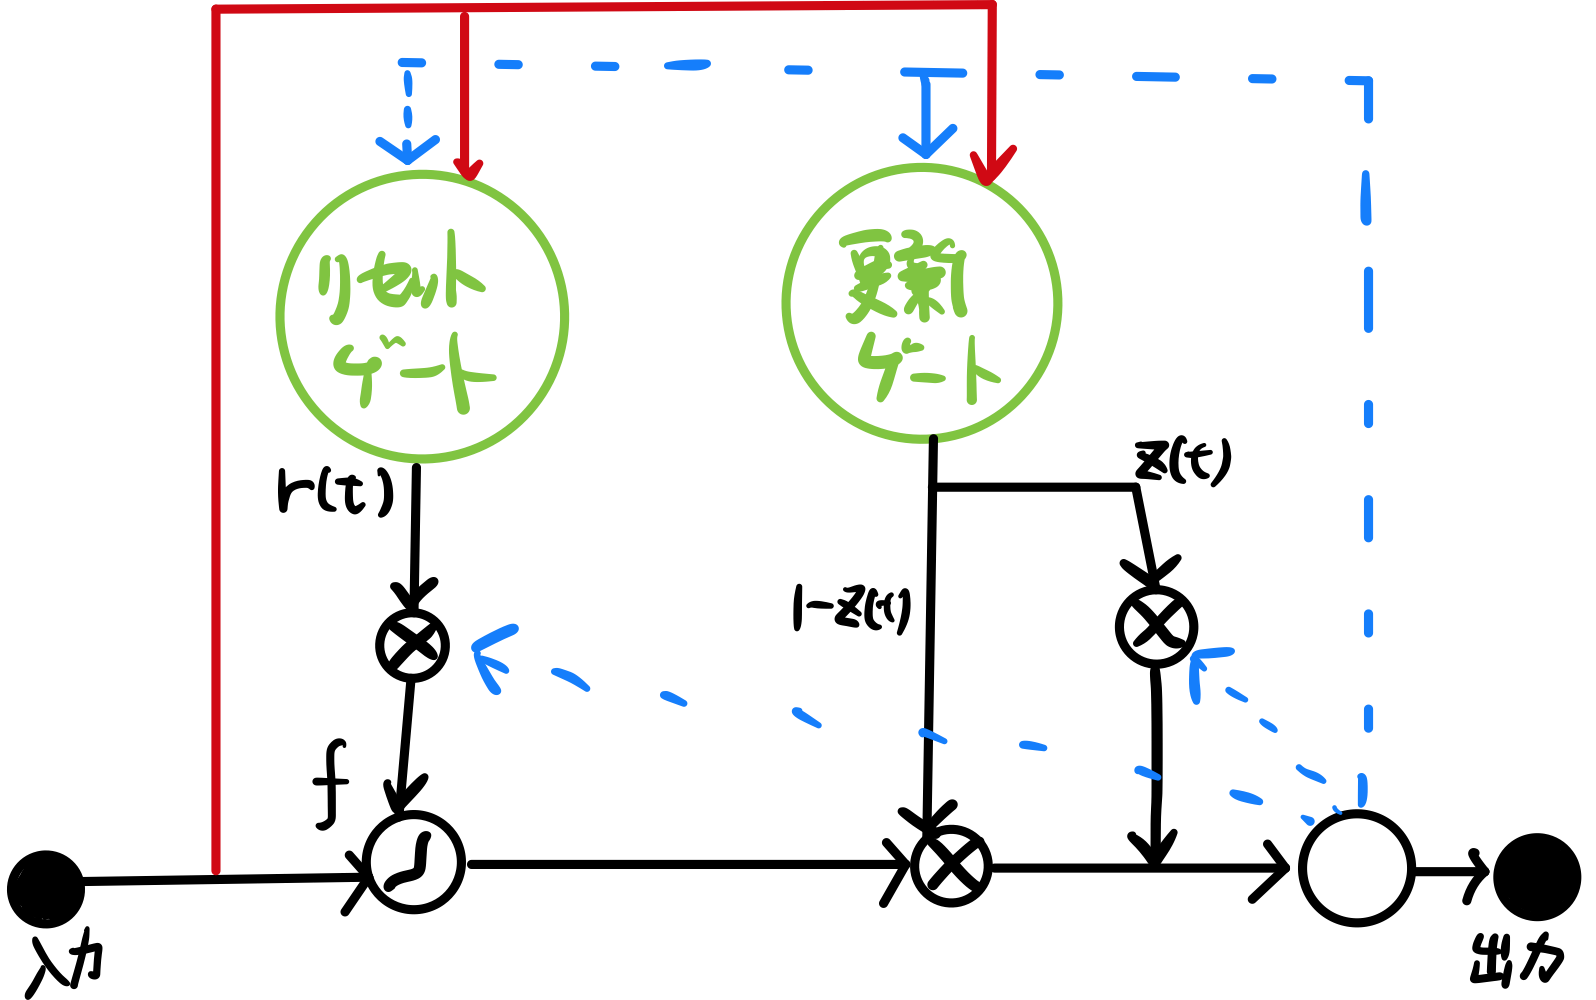

## 確認テスト

### LSTMとCECが抱える課題について、それぞれ簡潔に述べよ。（3分）

(解答)
CECは前回までの情報を保持する機能しかなく、学習する機能がない。
このためLSTMは、3つのゲートを用意し、全体として学習する機能を持たせるが、その分学習するパラメータが膨大になり、計算負荷が大きい。

---

### LSTMとGRUの違いを簡潔に述べよ。（5分）

(解答)
LSTMのパラメータ数を大幅に削減し、計算負荷を軽減したものがGRUである。

---

## 演習チャレンジ

### GRU(Gated Recurrent Unit)もLSTMと同様にRNNの一種であり、単純なRNNにおいて問題となる勾配消失問題を解決し、長期的な依存関係を学習することができる。LSTMに比べ変数の数やゲートの数が少なく、より単純なモデルであるが、タスクによってはLSTMより良い性能を発揮する。以下のプログラムはGRUの順伝播を行うプログラムである。ただし_sigmoid関数は要素ごとにシグモイド関数を作用させる関数である。（こ）にあてはまるのはどれか。

（1）z * h_bar

（2）(1-z) * h_bar

（3）z * h * h_bar

（4）(1-z) * h + z * h_bar

```python
def gru(x, h, W_r, U_r, W_z, U_z, W, U):
    """
    x: inputs, (batch_size, input_size)
    h: outputs at the previous time step, (batch_size, state_size)
    W_r, U_r: wights for reset gate
    W_z, U_z: weights for update gate
    U, W: weights for new state
    """
    # ゲートを計算
    r = _sigmoid(x.dot(W_r.T) + h.dot(U_r.T))
    z = _sigmoid(x.dot(W_z.T) + h.dot(U_z.T))
    
    # 次状態を計算
    h_bar = np.tanh(x.dot(W.T) + (r * h).dot(U.T))
    h_new = (1 - z) * h + z * h_bar # (こ)
    return h_new
```

(解答)
4

---

## 実装演習

loss: 5.111112056308692e-07    d: [-0.47157024]    y: [-0.47258129]
loss: 1.4153640452727858e-06    d: [-0.39789889]    y: [-0.39958137]
loss: 2.5599029914892206e-06    d: [-0.78740743]    y: [-0.78967013]
loss: 7.2162632907434935e-09    d: [0.25526991]    y: [0.25514977]
loss: 1.6920638523044487e-06    d: [0.6529121]    y: [0.6547517]
loss: 7.238070929587064e-07    d: [0.8773359]    y: [0.87613273]
loss: 6.946236726396605e-07    d: [0.92114593]    y: [0.91996727]
loss: 1.2284734878718578e-06    d: [-0.58880346]    y: [-0.59037093]
loss: 1.2497465540353236e-08    d: [-0.6529121]    y: [-0.65307019]
loss: 1.7470122273514748e-06    d: [-0.32751865]    y: [-0.32938788]
loss: 2.0214401036963795e-07    d: [0.39789889]    y: [0.39853473]
loss: 1.7248378220178395e-06    d: [-0.15674537]    y: [-0.1586027]
loss: 1.3462666565761748e-06    d: [0.97076771]    y: [0.97240861]
loss: 6.884294927344904e-07    d: [-0.50453668]    y: [-0.50571008]
loss: 8.96448514571133e-09    d: [-0.99460929]    y: [-

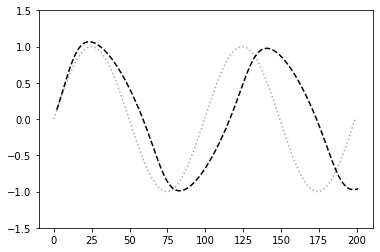

In [1]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 2

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 500

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()

# 双方向RNN

## 概要

過去の情報だけでなく、**未来の情報を加味**することで、精度を向上させることを意図したモデルである。
実用例として文章の推敲や機械翻訳等に使用される。

## 演習チャレンジ

### 以下は双方向RNNの順伝播を行うプログラムである。順方向については、入力から中間層への重みW_f, 一ステップ前の中間層出力から中間層への重みをU_f、逆方向に関しては同様にパラメータW_b, U_bを持ち、両者の中間層表現を合わせた特徴から出力層への重みはVである。_rnn関数はRNNの順伝播を表し中間層の系列を返す関数であるとする。（か）にあてはまるのはどれか

（1）h_f + h_b[::-1]

（2）h_f * h_b[::-1]

（3）np.concatenate([h_f, h_b[::-1]], axis=0)

（4）np.concatenate([h_f, h_b[::-1]], axis=1)

```python
def bidirectional_net(xs, W_f, U_f, W_b, U_b, V):
    """
    W_f, U_f: forward rnn weights, (hidden_size, input_size)
    W_b, U_b: backward rnn weights, (hidden_size, input_size)
    V: outputs weights, (output_size, 2*hidden_size)
    """
    xs_f = np.zeros_like(xs)
    xs_b = np.zeros_like(xs)
    for i, x in enumerate(xs):
        xs_f[i] = x
        xs_b[i] = x[::-1]
    hs_f = _rnn(xs_f, W_f, U_f)
    hs_b = _rnn(xs_b, W_b, U_b)
    hs =[np.concatenate([h_f, h_b[::-1]], axis=1) for h_f, h_b in zip(hs_f, hs_b)] # (か)
    ys = hs.dot(V.T)
    return ys
```

(解答)
4

---

# Seq2Seq

## 概要

Seq2seqは、Encoder-Decoderモデルの一種で、入力した時系列データを別の時系列データに変換(または別の時系列データを生成)するものである。2つのRNN(Encoder RNNとDecoder RNN)から成り、機械対話や機械翻訳などに使用されている。

- Encoder RNN

ユーザーがインプットしたテキストデータを単語等のトークンに区切って渡す構造となっており、Taking(文章を単語等のトークン毎に分割し、トークンごとのIDに分割する。)、Embedding(IDからそのトークンを表す分散表現ベクトルに変換)を経てベクトルを順番にRNNに入力する。まずvec1をRNNに入力し、hidden　stateを出力し、このhidden　stateと次の入力vec2をまたRNNに入力し、hidden stateを出力する、という流れを繰り返す。最後のvecを入れたときのhidden stateをfinal　stateとして保持する。このfinal　stateがthought　vectorと呼ばれ、入力した文の意味を表すベクトルとなる。

- Decoder RNN

出力データを単語等のトークンごとに生成する構造となっており、処理手順として、

1. Encoder RNNのfinal state(thought vector)から、各tokenの生成確率を出力する。final stateをDecoder RNNのinitial stateとして設定し、Embeddingを入力する。

2. Sampling:生成確率にもとづいてtokenをランダムに選ぶ。

3. Embedding:2で選ばれたtokenをEmbeddingしてDecoder RNNへの次の入力とする。

4. Detokenize:1-3を繰り返し、2で得られたtokenを文字列に直す。

- HRED

seq2seqの課題として、一問一答しかできないため、問いに対して文脈も何もなく、ただ応答が行われる続けることが挙げられる。HREDでは、過去n-1個の発話から次の発話を生成させる。これによってHREDでは、前の単語の流れに即して応答されるためより人間らしい文章が生成される。HREDは、Seq2SeqにContext RNN(Encoderのまとめた各文章の系列をまとめて、これまでの会話コンテキスト全体を表すベクトルに変換する構造)を加えた構造となっていて、これによって過去の発話の履歴を加味した返答ができる。しかしながら、HREDは確率的な多様性が字面にしかなく、会話の「流れ」のような多様性が無いため、同じコンテキスト（発話リスト）を与えられても、答えの内容が毎回会話の流れとしては同じものしか出せない。そのため、短く情報量に乏しい答え、つまり短いよくある答えを学ぶ傾向がある(ex)「うん」「そうだね」「・・・」など)。

- VHRED

HREDにVAEの潜在変数の概念を追加したもので、HREDの課題を解決した構造となっている。

- オートエンコーダー

教師なし学習の一つで、学習時の入力データは訓練データのみで教師データは利用しない。例えば、画像を入力して同じ画像を出力する構造となっている。EncoderとDecoderからなり、Encoderは入力データから潜在変数zに変換するニューラルネットワークで、Decoderでは、その潜在変数zをインプットとして元データを復元するニューラルネットワーク構造となっている。zの次元が入力データより小さい場合、次元削減とみなすことができる。

- VAE(Variational AutoEncoder)

通常のオートエンコーダーの場合、何かしら潜在変数zにデータを押し込めているものの、その構造がどのような状態かはわからない。VAEは、この潜在変数zに確率分布$z \sim N(0,1)$を仮定したものである。

## 確認テスト

### 下記の選択肢から、seq2seqについて説明しているものを選べ。（3分）

（1）時刻に関して順方向と逆方向のRNNを構成し、それら2つの中間層表現を特徴量として利用するものである。

（2）RNNを用いたEncoder-Decoderモデルの一種であり、機械翻訳などのモデルに使われる。

（3）構文木などの木構造に対して、隣接単語から表現ベクトル（フレーズ）を作るという演算を再帰的に行い（重みは共通）、文全体の表現ベクトルを得るニューラルネットワークである。

（4）RNNの一種であり、単純なRNNにおいて問題となる勾配消失問題をCECとゲートの概念を導入することで解決したものである。

(解答)
2

(1) bidirectional RNNのこと

(3) RNNのこと

(4) LSTMのこと

---

### seq2seqとHRED、HREDとVHREDの違いを簡潔に述べよ。（5分）

(解答)
seq2seqが入力されたテキストデータに対する出力しかできないため、文脈を考慮した応答が行えないという問題があった。 この問題を解決するため、seq2seqにcontext RNNを加え、文脈を取り込んだ応答を可能にするHREDが考案された。
HREDによって文脈に沿った応答が可能になったが、HREDは短く情報量に乏しい応答を学習する傾向であったため、この問題を解決する方法としてHREDにVAEの潜在変数の概念を取り入れたVHREDが考案された。

---

### VAEに関する下記の説明文中の空欄に当てはまる言葉を答えよ。自己符号化器の潜在変数に____を導入したもの。（1分）

(解答)

標準正規分布

---

## 演習チャレンジ

### 機械翻訳タスクにおいて、入力は複数の単語から成る文（文章）であり、それぞれの単語はone-hotベクトルで表現されている。Encoderにおいて、それらの単語は単語埋め込みにより特徴量に変換され、そこからRNNによって（一般にはLSTMを使うことが多い）時系列の情報をもつ特徴へとエンコードされる。以下は、入力である文（文章）を時系列の情報をもつ特徴量へとエンコードする関数である。ただし_activation関数はなんらかの活性化関数を表すとする。（き）にあてはまるのはどれか。

（1）E.dot(w)

（2）E.T.dot(w)

（3）w.dot(E.T)

（4）E * w

```python
def encode(words, E, W, U, b):
    """
    words: sequence words (sentence), one-hot vector, (n_words, vocab_size)
    E: word embedding matrix, (smbed_size, vocab_size)
    W: upward_weights, (hidden_size, hidden_size)
    U: lateral weights, (hidden_size, embed_size)
    b: bias, (hiddem_size, )
    """
    hidden_size = W.shape[0]
    h = np.zeros(hidden_size)
    for w in words:
        e = E.dot(w)
        h = _activation(W.dot(e) + U.dot(h) + b) # (き)
    return h
```

(解答)
1

---

# Word2vec

## 概要

word2vecとは、単語のような可変長の文字列を固定長形式で表す自然言語処理のことで、2層のニューラルネットワークのみで構成されるシンプルな構造となっている。中心のある単語から周辺の単語を予測するskip-gramモデルと周辺の単語から中心の単語を予測するCBOWモデルがある。
入力したテキストを単語レベルまで分解し、重複を除いたボキャブラリを作成する。skip-gramモデルでは中心の単語をone-hotベクトルで表し、これを入力とし、重み行列をかけることで対応する単語ベクトルを得、周辺の単語を予測する。CBOWモデルでは逆に周辺の単語を入力とし、重み行列をかけ、単語ベクトルを得た後、中心の単語を予測する。いずれの場合も単語ベクトルを作成することで、大規模データを学習する場合であっても、現実的な計算速度とメモリ量で可能になった。

# Attention Mechanism

## 概要

seq2seqは中間層の長さが決まっているので、長い文章への対応が難しいという問題がある。つまり、2単語でも、100単語でも、固定次元ベクトルの中に入力しなければならず、長くなればなるほどうまく文全体を表現できなくなる。Attention Mechanismは「入力と出力のどの単語が関連しているのか」の関連度を学習する仕組みで、中間層の長さが一定でも重要な情報だけに注目することができる。現在の機械翻訳の大部分はAttention Mechanismを使用している。

## 確認テスト

### RNNとword2vec、seq2seqとAttentionの違いを簡潔に述べよ。（5分）

RNNは時系列データを処理するのに適したニューラルネットワークのことで、word2vecは単語の分散表現を得る手法のことである。seq2seqは時系列データを別の時系列データに変換する手法のことで、Attentionは入力と出力の関連について重みをつける仕組みのことである。

---

# **深層学習day4**

# 強化学習

## 概要

強化学習は、長期的に報酬を最大化できるように環境の中で行動を選択できるエージェントを作ることを目標とする機械学習の一分野である。行動の結果として与えられる利益(報酬)をもとに、行動を決定する原理を改善していく仕組みである。行動について探索と利用を繰り返し、報酬を最大化するような最適な行動を見つける。
通常の教師あり、教師なし学習と強化学習との大きな違いは学習の目標、すなわち前者では、データに含まれるパターンを見つけ出すおよびそのデータから予測することが目標であるのに対し、後者では、優れた方策を見つけることが目標である。計算速度の
進展により大規模な状態をもつ場合(より現実的な設定で)の強化学習が可能になりつつある。
強化学習では、行動を選び、行動による環境の変化と報酬のフィードバックによって、その行動を取った場合と、取らなかった場合の価値を比較し、方策を修正する、のサイクルを繰り返す。ある状態でどのような行動をとるのかの確率を与える方策関数、行動した場合の価値を導出する行動価値関数、行動しなかった場合の状態価値関数を使用して、最終的な価値を最大化するような学習を行う。
今、行動を$a$、状態を$s$、パラメータを$\theta$、とすると、方策関数は$\pi (a |s, \theta)$ と表わされ、その最適な値は、

$$\theta'{(t+1)} = \theta^{(t)} + \epsilon \nabla J(\theta)$$

として求められる(方策勾配法)。
この$J(\theta)$は、期待収益で、下式にて求まる。

$$\nabla_{\theta} J(\theta) = \mathbb E_{\pi_{\theta}}[(\nabla_{\theta} \log \pi_{\theta}(a | s)\mathbb Q^{\pi}(s, a))]$$

(上の式は$\nabla_{\theta} J(\theta) = \nabla_{\theta} \sum_{a \in A} \pi_{\theta}(a | s)\mathbb Q^{\pi}(s, a))]$から導出)

何かしらの行動をとる確率とその行動に伴う価値をかける操作を全ての行動において行い、その価値を足し合わせる。

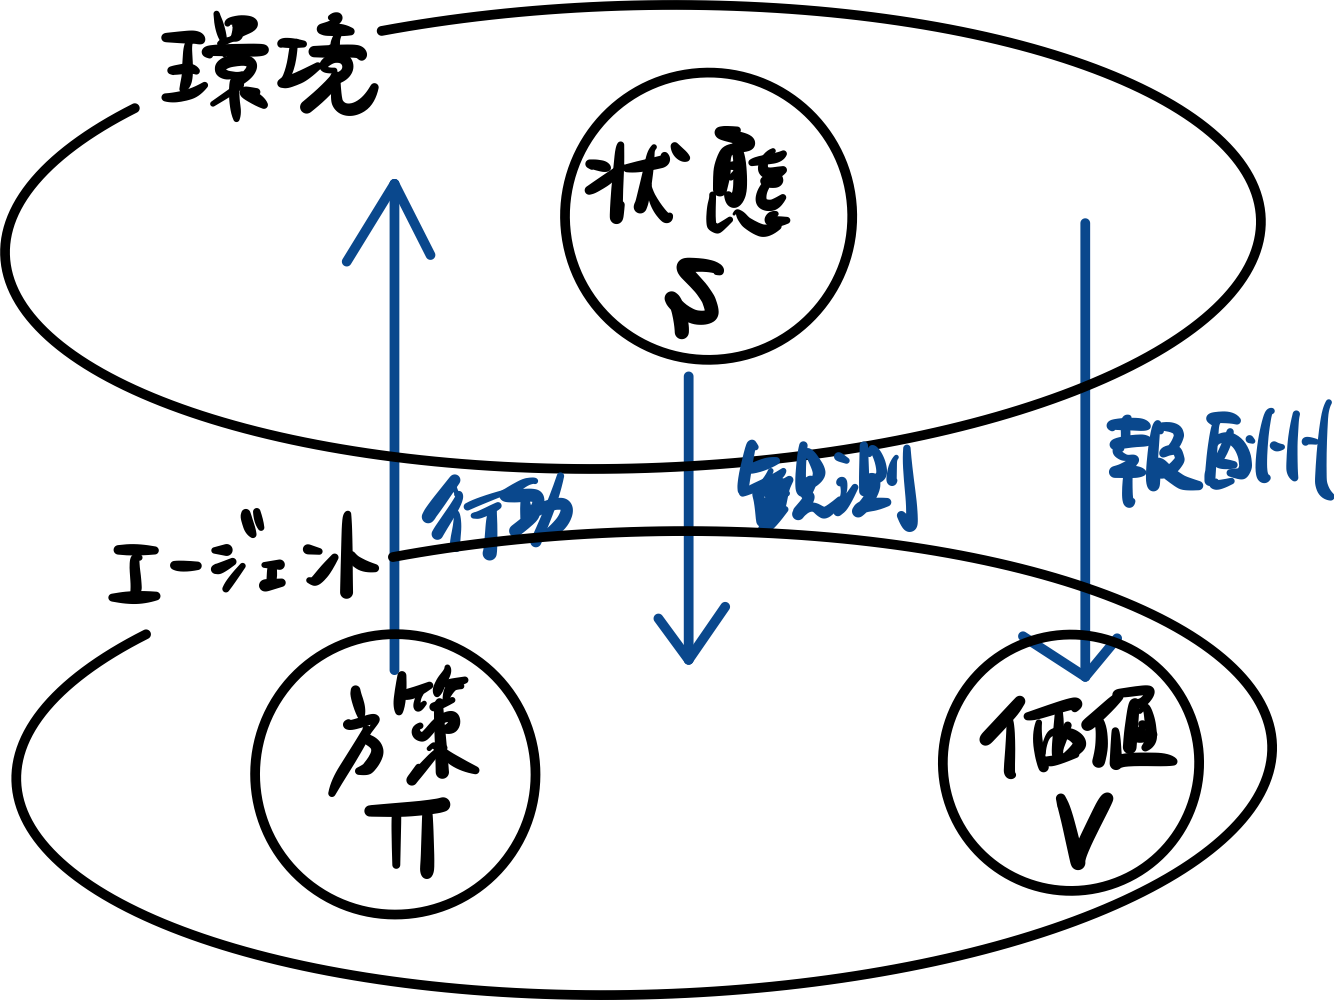

方策関数: $\Pi (s, a)$

行動価値関数: $Q(s, a)$

# AlphaGo

## 概要

- AlphaGo (Lee)

AlphaGoは、2つのニューラルネットワーク(PolicyNetとValueNet)から構成される。
PolicyNETは強化学習における方策関数で、構造は畳み込みニューラルネットワークである。入力は19x19(碁の盤面)の48チャネル(様々な状態の盤面)で、出力は19x19の着手予想確率となっている。
ValueNetは強化学習における行動価値関数で、構造は畳み込みニューラルネットワークである。入力は19x19(碁の盤面)の49チャネル(様々な状態の盤面)で、出力は現局面での勝率を-1から1の値で表したものである。

PolicyNetの強化学習では、PolicyPool(PolicyNetの強化学習の過程の500iterationごとの記録が保存されたもの)からランダムに選択されたPolicyNetと対局を行い、その結果から方策勾配法を使って学習が行われる。ある程度PolicyNetの学習が進んだ段階で、ValueNetに関しても学習を行う。ValueNetで用いる探索はモンテカルロ木探索を行う。強化学習のみでは学習がうまくいかないので、強化学習の前に教師あり学習(RolloutPolicyとPolicyNet)を行う。RolloutPolicyは、線形の方策関数で高速に着手確率を出すことができる。また教師あり学習では過去の人間対人間の対局データが用いられる。

- AlphaGo (Lee)のPolicyNet

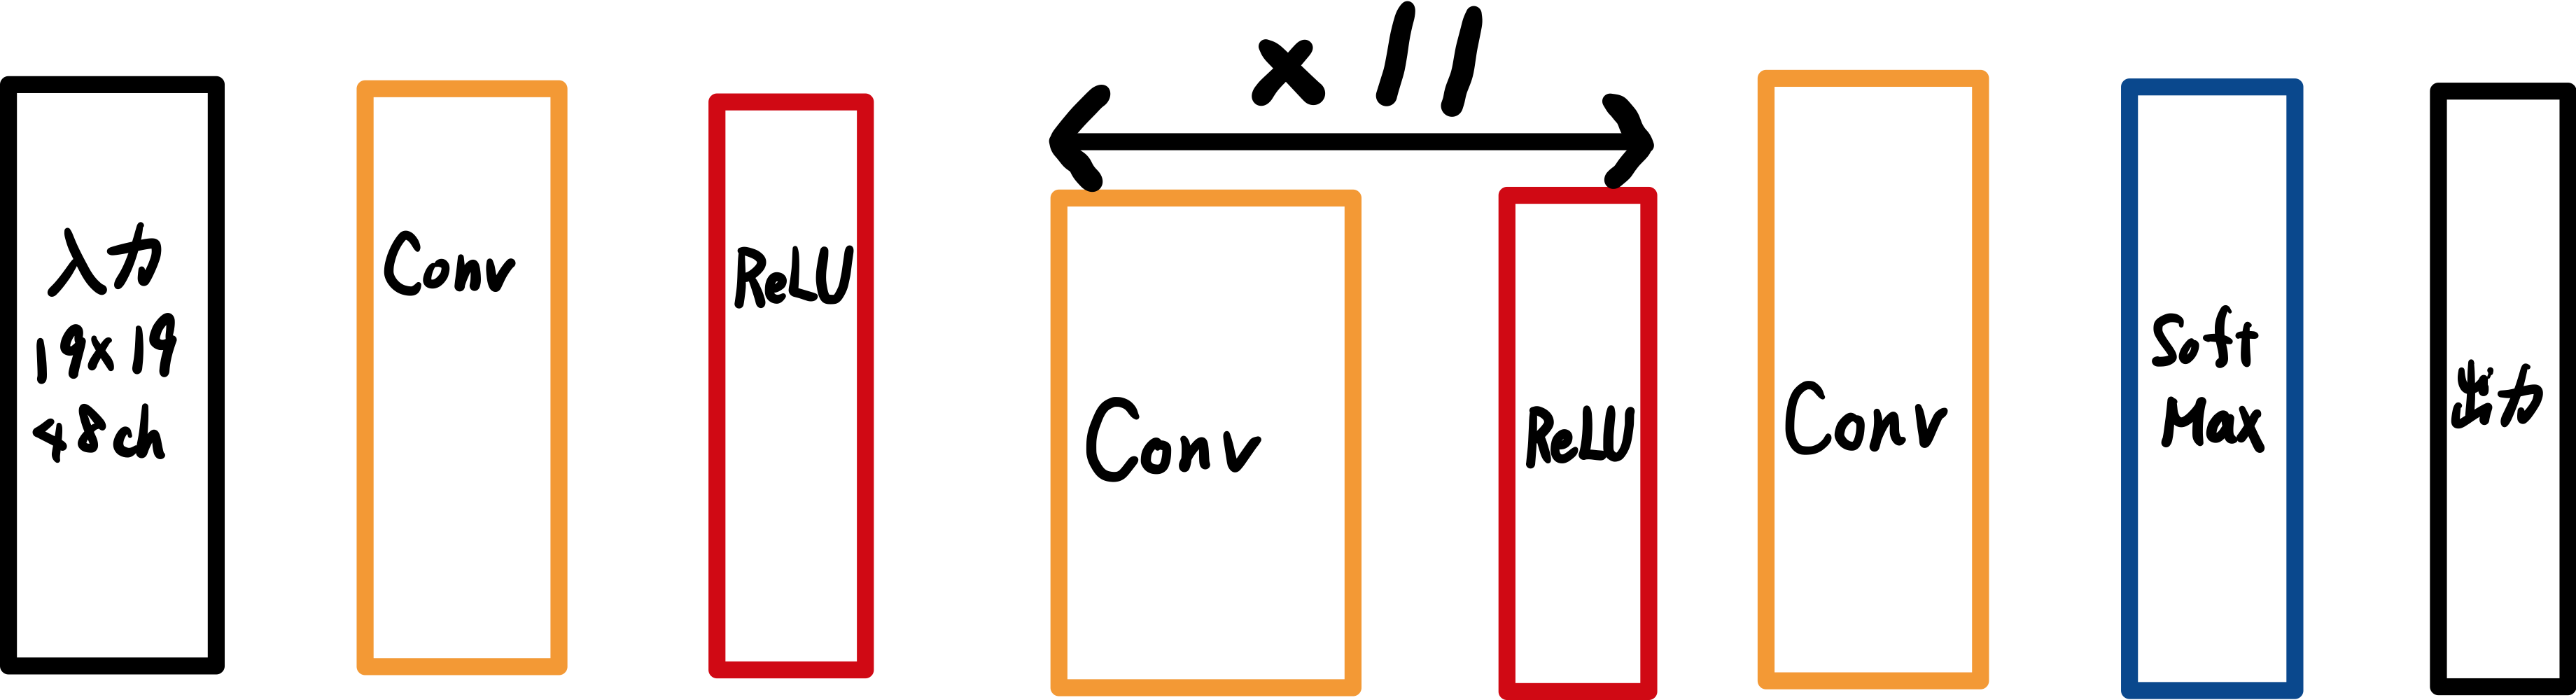

- AlphaGo (Lee)のValueNet

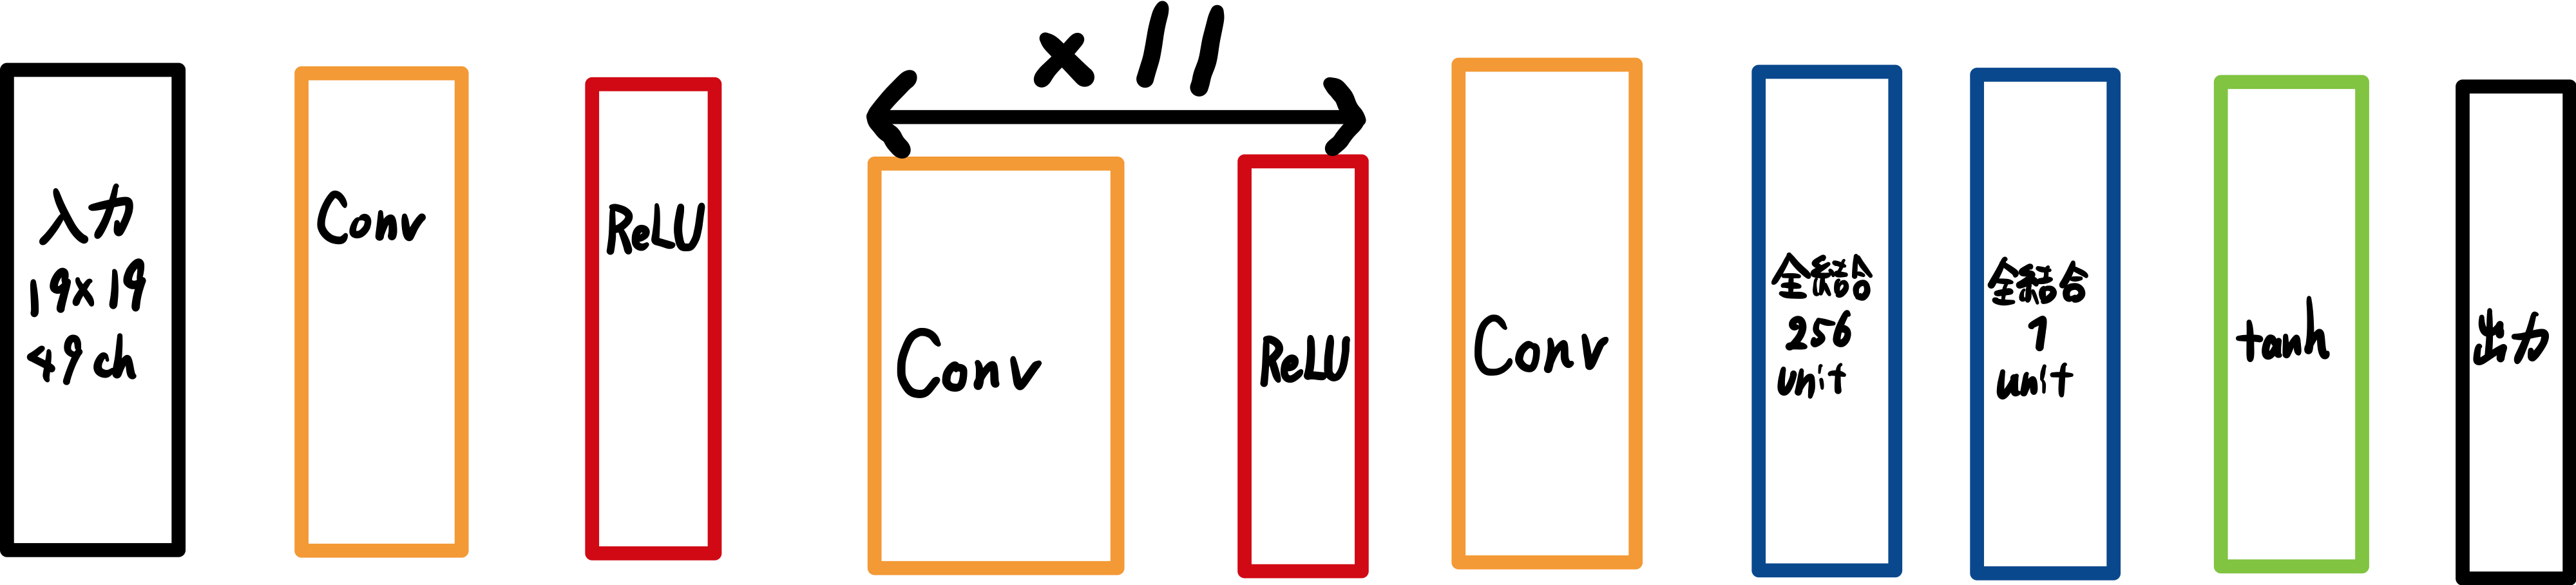

- AlphaGo Zero

AlphaGo Zeroは、AlphaGo(Lee)の改良版で、以下の点で異なる。

1. 教師あり学習を一切行わず、強化学習のみで作成

2. 特徴入力からヒューリスティックな要素を排除し、石の配置のみにした

3. PolicyNetとValueNetを１つのネットワークに統合した

4. Residual Netを導入した

5. モンテカルロ木探索からRollOutシミュレーションをなくした

ResidualNetworkは、ネットワークにショートカット構造を追加して、勾配の爆発、消失を抑える効果を狙ったものである。基本構造はConvolution→BatchNorm→ReLU→Convolution→BatchNorm→Add→ReLUのBlockを１単位にして積み重ねた形となっていて、これを使うことにより層数の違うNetworkのアンサンブル効果が得られる。

- Residual Blockの工夫

Bottleneck: 1x1畳み込みを利用し、計算量を増やさずに層を深くする方法

Preactivation: 畳み込み層の前に活性化関数を配置

- Network構造の工夫

WideResNet: 畳み込みのフィルタ数を定数倍にしたもの

PyramidNet: 段階的にではなく、各層でフィルタ数を増やす工夫

- AlphaGo ZeroのPolicyValueNet

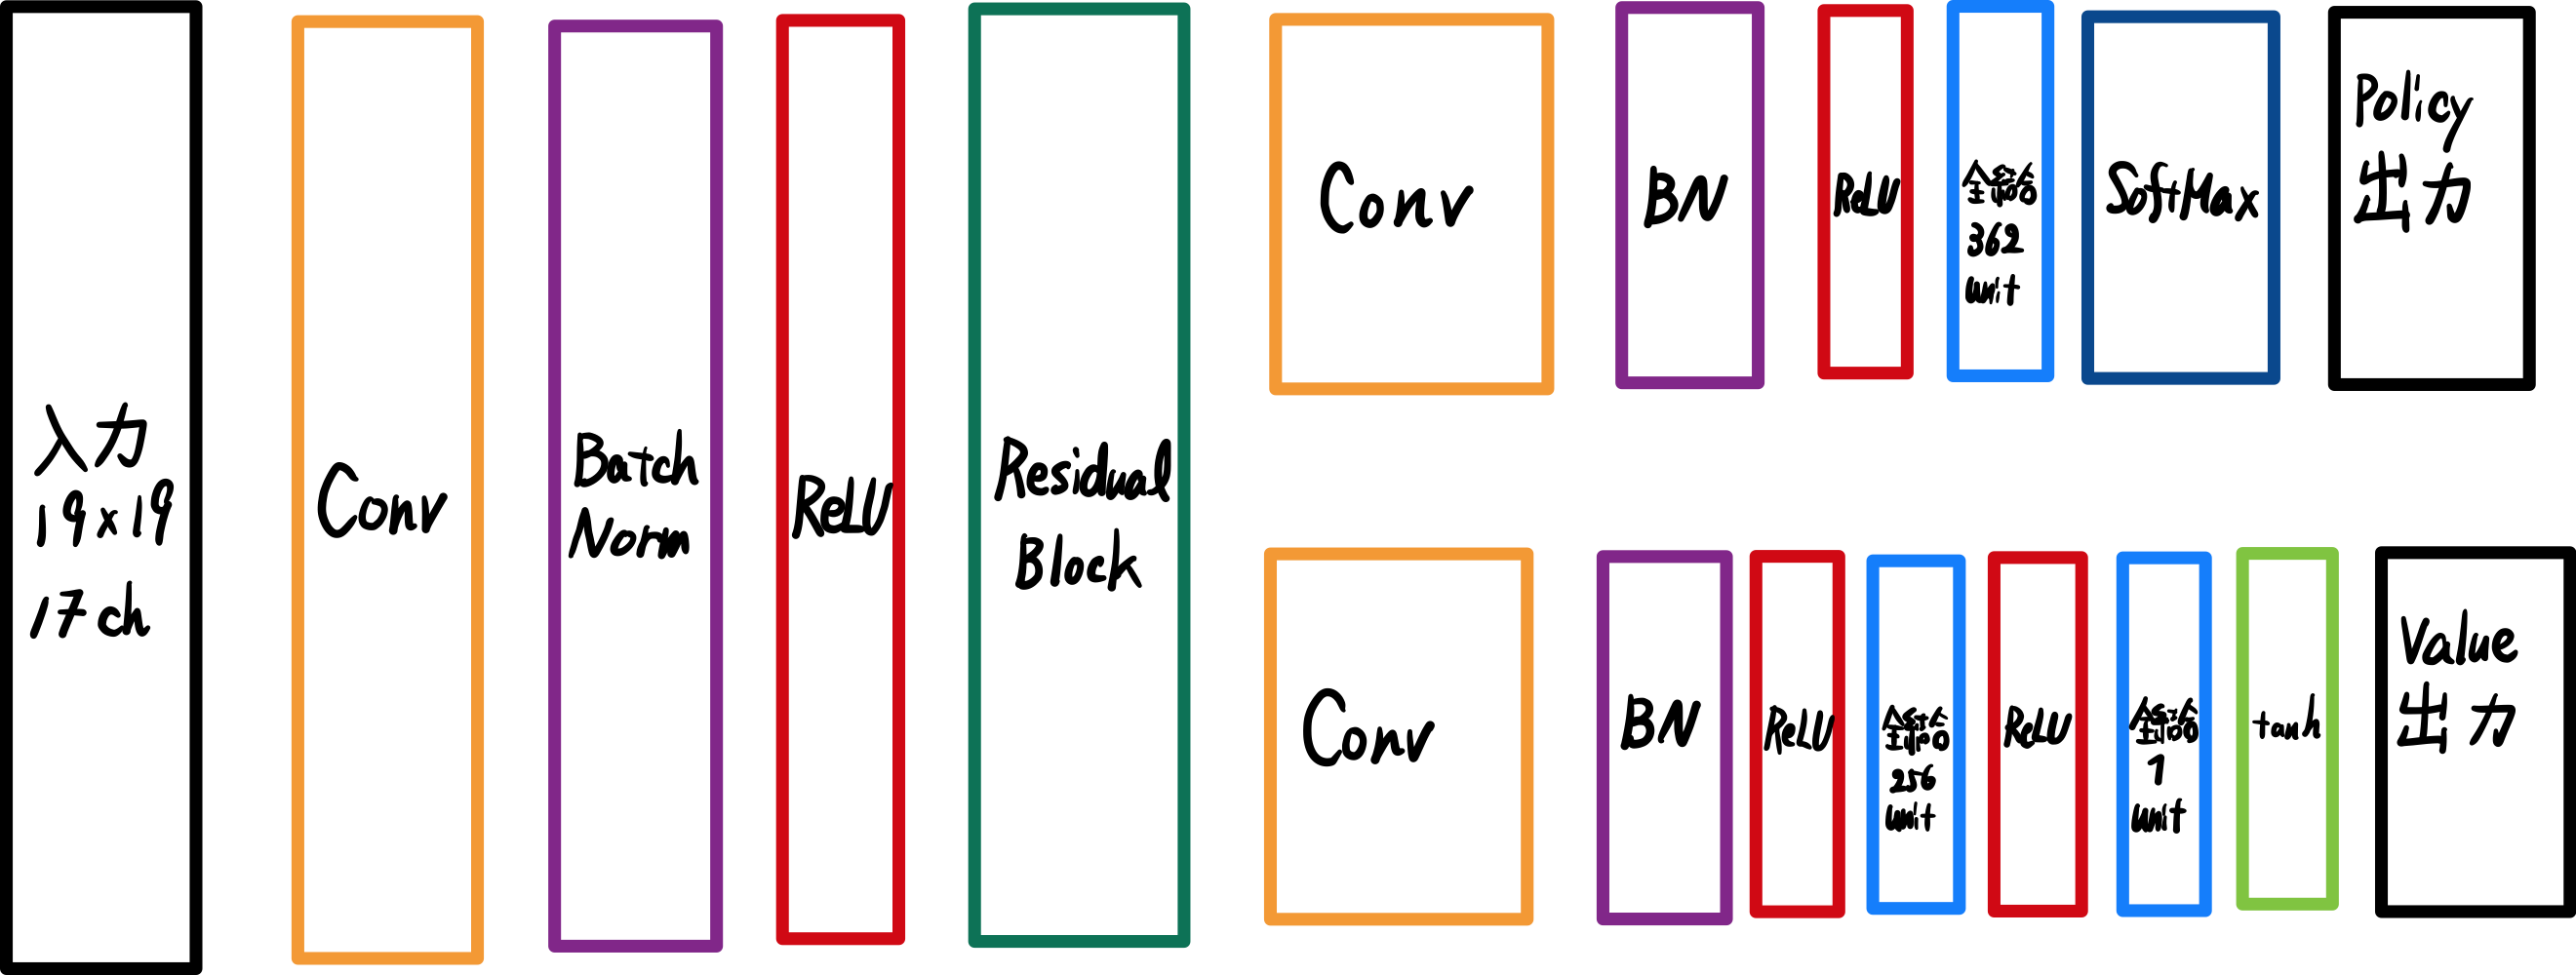

# 軽量化・高速化技術

## 概要

深層学習では、多くのデータを使用し、パラメータ調整のために多くの時間を使用するため、高速な計算が求められる。複数の計算資源(ワーカー)を使用し、並列的にニューラルネットを構成することで、効率の良い学習を行うことができる(分散深層学習)。分散深層学習にはデータ並列化・モデル並列化がある。またGPUを使用することで高速な計算が可能になる。

- データ並列化

親モデルを各ワーカーに子モデルとしてコピーした後、データを分割し、各ワーカーごとに計算させる。各モデルのパラメータの合わせ方で、同期型か非同期型か決まる。
同期型では、各ワーカーの計算が終わるのを待ち、全ワーカーの勾配が出たところで勾配の平均を計算し、親モデルのパラメータを更新する。非同期型では、各ワーカーはお互いの計算終了を待たず、各子モデルごとに更新を行う。学習が終わった子モデルはパラメータサーバにPushされる。新たに学習を始める時は、パラメータサーバからPopしたモデルに対して学習していく。処理のスピードは、お互いのワーカーの計算を待たない非同期型の方が早いが、非同期型は最新のモデルのパラメータを利用できないので、学習が不安定になりやすい(Stale Gradient Problem)。現在は同期型の方が精度が良いことが多いので、主流となっている。

- モデル並列化

親モデルを各ワーカーに分割し、それぞれのモデルを学習させ、全てのデータで学習が終わった後で、一つのモデルに復元する。一般に、モデルが大きい時はモデル並列化を、データが大きい時はデータ並列化をする。

- GPUによる高速化

深層学習で用いられるGPUは、GPGPU(General-purpose on GPU)と呼ばれ、元々の使用目的であるグラフィック以外の用途で使用されるGPUの総称のことである。CPUが高性能なコアが少数、複雑で連続的な処理が得意という特徴があるのに対し、GPUは比較的低性能なコアが多数あり、簡単な並列処理を得意とするため単純な行列演算が多いニューラルネットワークの学習で高速化が可能となる。

- モデルの軽量化

モデルの精度を維持しつつパラメータや演算回数を低減する手法の総称をモデルの軽量化という。
モデルの軽量化は、特にパソコンに比べ、計算速度と搭載されているメモリにおいて性能が大きく劣るモバイル端末やIoT機器において有用な手法である。軽量化の代表的な手法として下記の3つ(量子化・蒸留・プルーニング)がある。

- 量子化(Quantization)

通常のパラメータの64bit浮動小数点を32bitなど下位の精度に落とすことでメモリと演算処理の削減を行う方法である。精度の低下とトレードオフの関係であるため、量子化を行う場合は精度の点に留意する。

- 蒸留(Distillation)

学習済みの精度の高いモデルの知識を軽量なモデルへ継承させることで、軽量でありながら複雑なモデルに匹敵する精度のモデルを得る手法のことである。蒸留は、予測精度の高い、複雑なモデルやアンサンブルされた教師モデルと、教師モデルをもとに作られる軽量な生徒モデルの2つで構成される。学習では、誤差は教師モデルと生徒モデルのそれぞれの誤差を使って教師モデルの重みを固定したまま、生徒モデルの重みのみを更新していく。

- プルーニング（Pruning）

モデルの精度に寄与しない（寄与が少ない）ニューロンを削減することでモデルの軽量化、高速化を図るものである。

# 応用モデル

## 概要

- MobileNet

ディープラーニングモデルの一種で、軽量化・高速化・高精度化を実現したものである。**Depthwise Convolution**と**Pointwise Convolution**の組み合わせで軽量化を実現したことが特徴である。一般的な畳み込みレイヤーでは、入力特徴マップをH x W x C、畳込みカーネルのサイズをK x K x C、出力チャネル数(フィルタ数)をM、ストライド１でパディングを適用した場合の畳み込み計算の計算量は**H x W x K x K x C x M**となる。
Depthwise Convolutionは、入力マップのチャネルごとに畳み込みを実施し、出力マップをそれらと結合する(入力マップのチャネル数と同じになる)ので、計算量は**H x W x K x K x C x 1**となる。
Pointwise Convolutionは、1 x 1 conv(正確には1 x 1 x c)とも呼ばれ、入力マップのポイントごとに畳み込みを実施し、出力マップ(チャネル数)はフィルタ数分だけ作成可能(任意のサイズが指定可能)となるので、計算量は**H x W x 1 x 1 x C x M**となる。

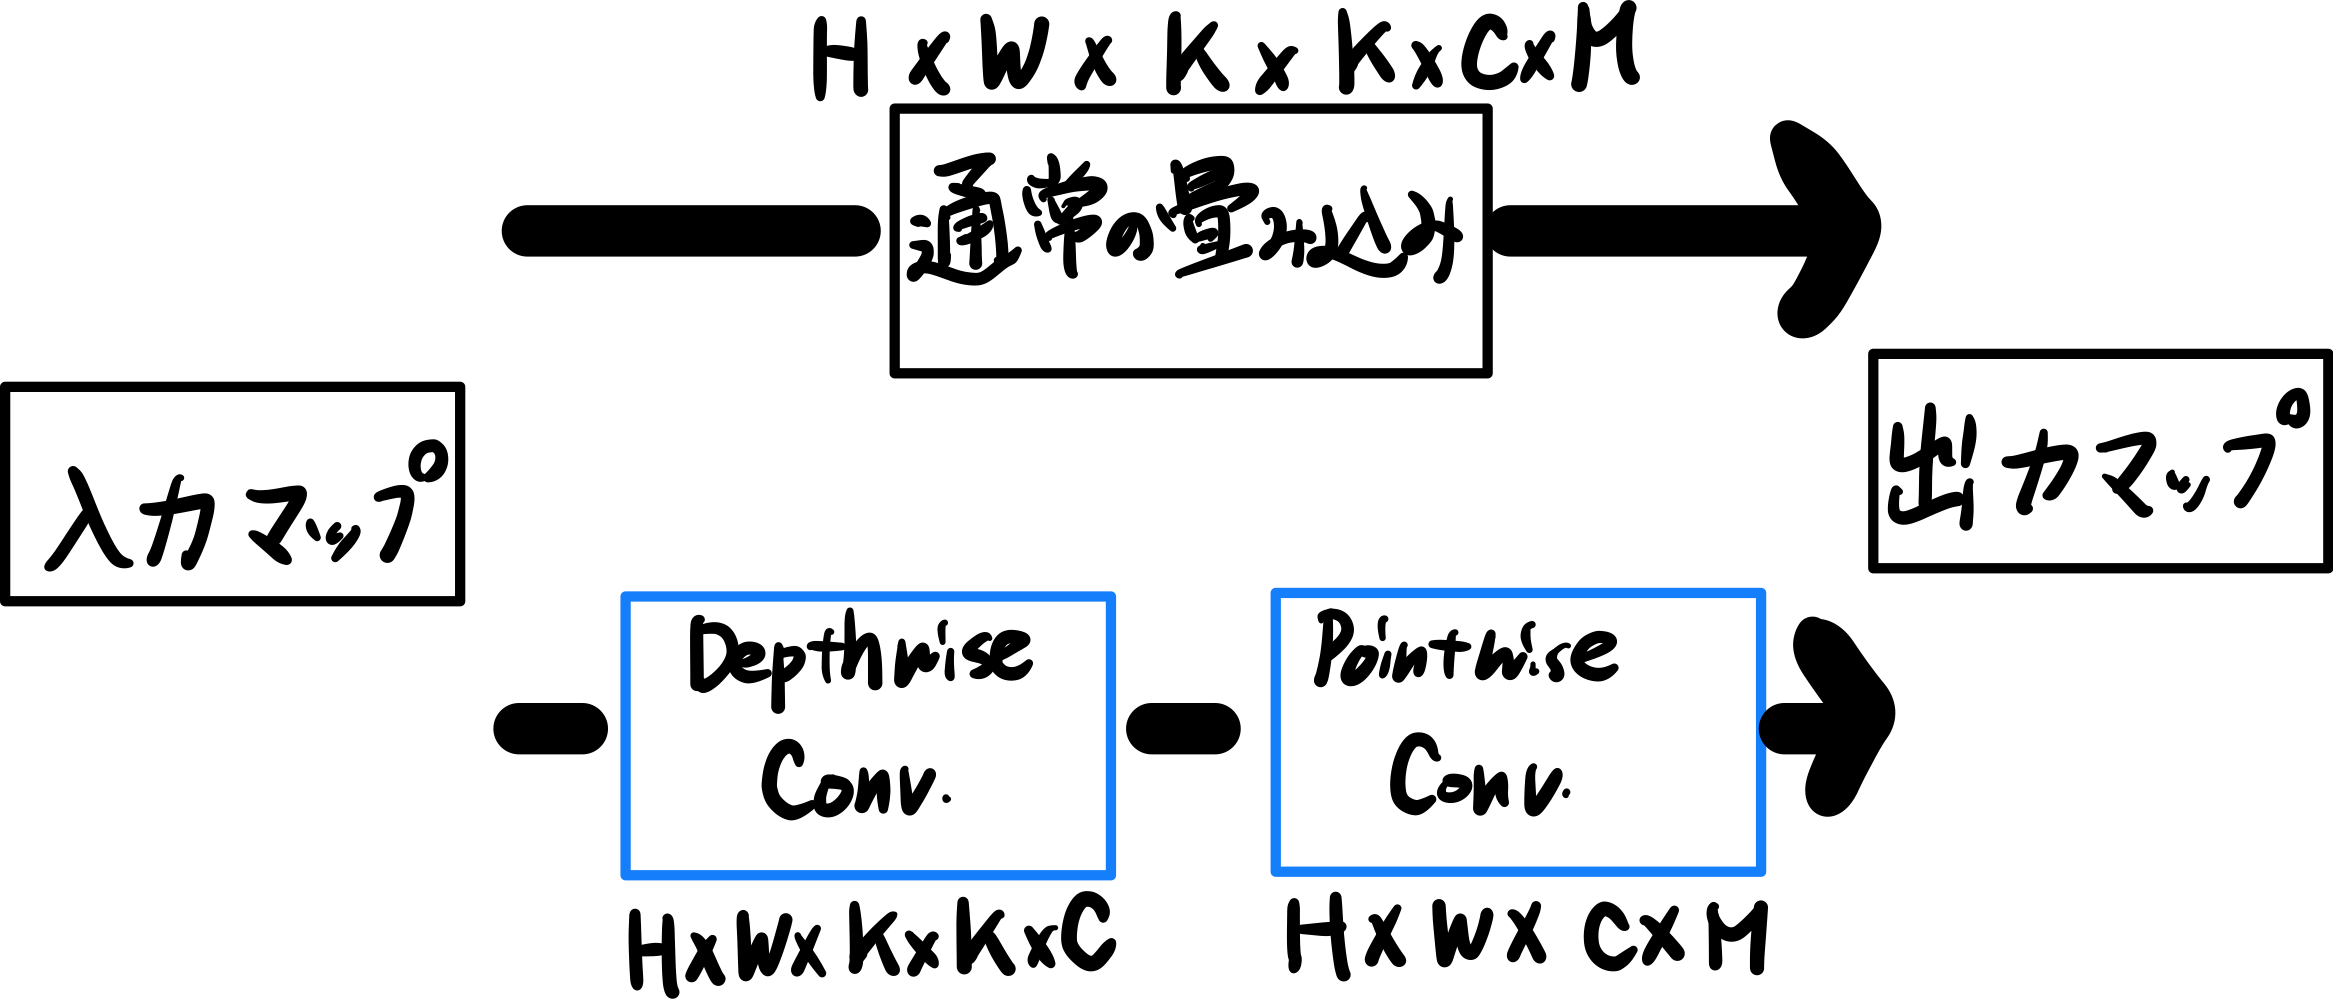

- DenseNet

DenseNetは、畳み込みニューラルネットワークアーキテクチャの一種で、Denseブロックと呼ばれるモジュールが特徴である。DenseNetの構造は、初期の畳み込み、Denseブロック、Transitionレイヤー、判別レイヤーとなっている。Denseブロックでは、入力マップをバッチ正規化、ReLU関数による活性化、3x3畳み込みで処理し、この出力に層間の情報の伝達を最大にする目的で入力マップを足し合わせたものを出力とする。入力マップのチャネル数をネットワークのgrowth rateと呼ぶ。Transitionレイヤーは、Denceブロック間に位置し、Denseブロック通過後の特徴マップのサイズを変更し、ダウンサンプリングを行っている。そのため、各Denseブロック内で特徴マップのサイズは一致している。

- Normalization

1. Batch Normalization

レイヤー間を流れるデータの分布をミニバッチ単位で平均が0・分散が1になるように正規化する処理で、ニューラルネットワークにおいて学習時間の短縮や初期値への依存低減、過学習の抑制などの効果がある。問題点として、バッチサイズが小さい条件下では学習が収束しないことがあり、代わりにLayer Normalizationなどの正規化手法が使われることが多い。

2. Layer Normarization

N個のサンプルのうち一つに注目して、H x W x Cの全てのピクセルで正規化を行う。ミニバッチの数に依存しない。入力データのスケーリング操作や重み行列のスケーリングやシフトに対して、ロバストであることが知られている。

3. Instance Normarization

各サンプルの各チャネルごとに正規化を行う。コントラストの正規化、画像のスタイル転送やテクスチャ合成タスクなどで利用されている。

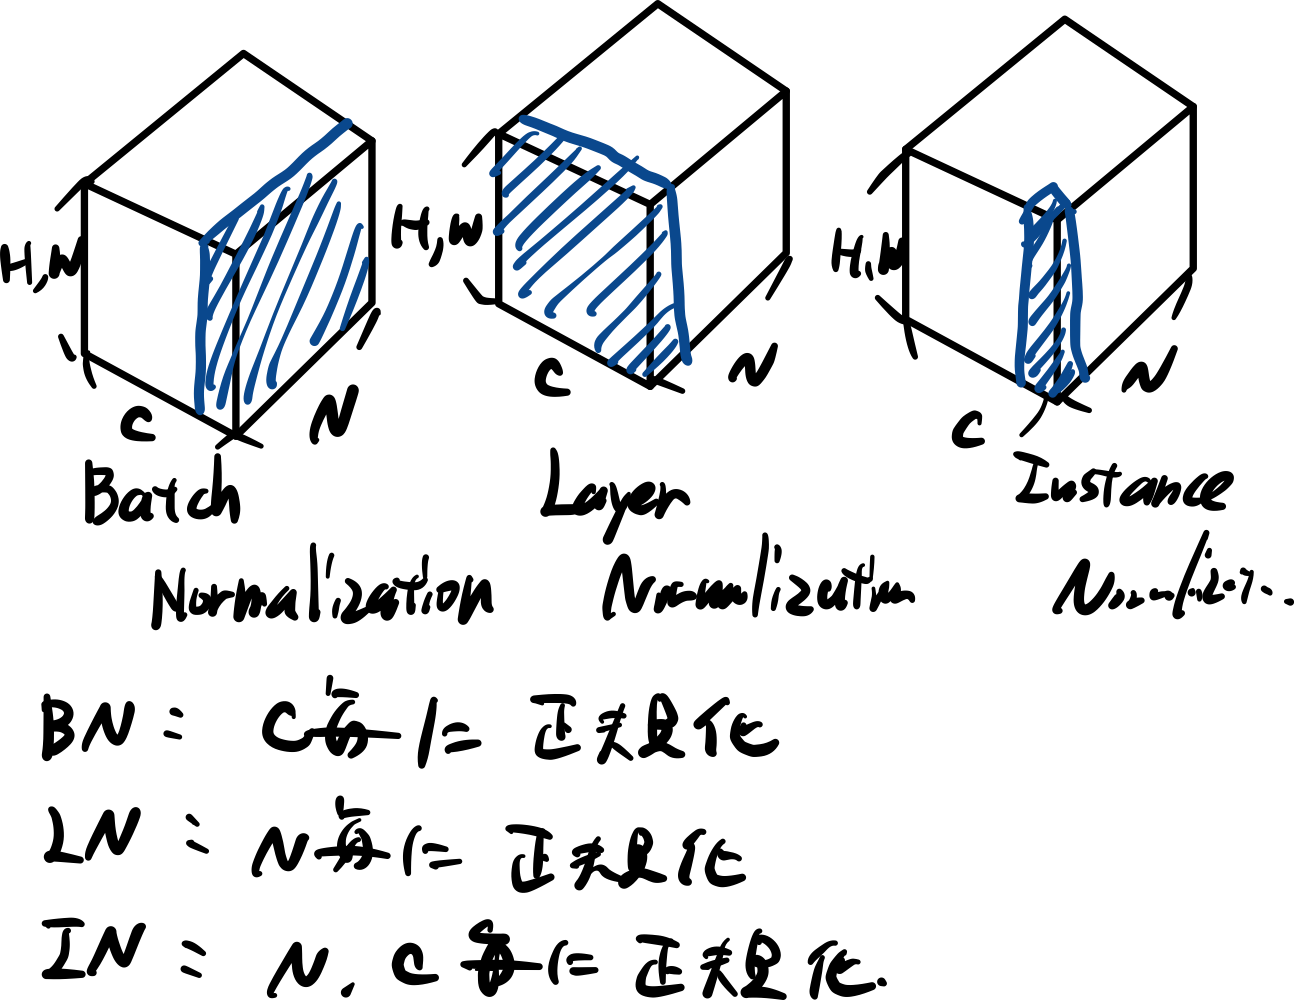

- wavenet

時系列データに対する畳み込みネットワークアーキテクチャの1つである。層が深くなるにつれて畳み込み層間のリンクを離すDilated convolutionという手法が特徴であり、これによって受容野を簡単に増やすことができる。

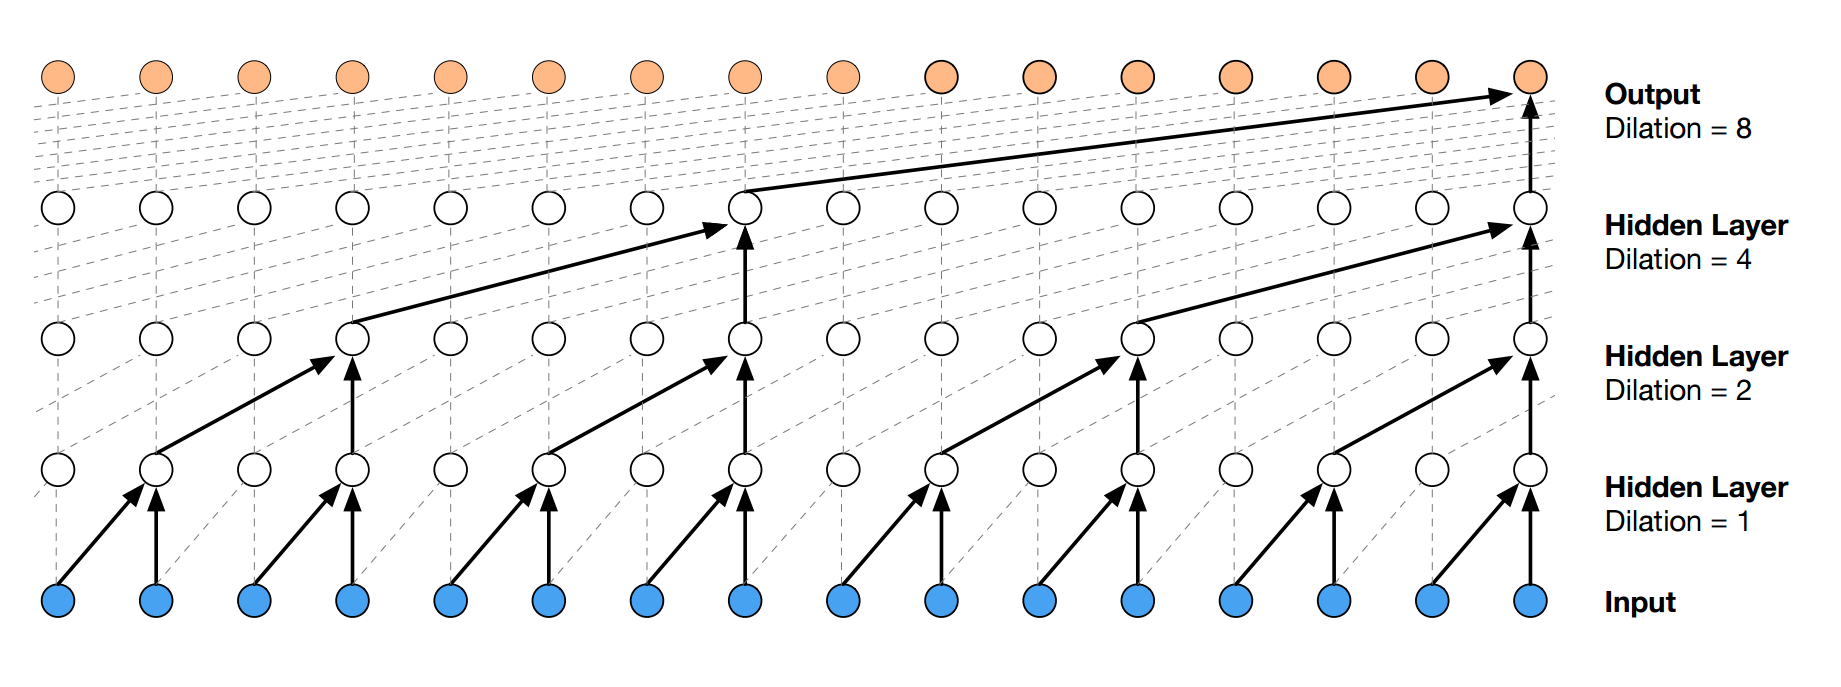

## 確認テスト

### Depthwise Convolitionはチャネル毎に空間方向へ畳み込む。すなわち、チャネル毎にDK　×　DK　×　１のサイズのフィルターをそれぞれ用いて計算を行うため、その計算量は（い）となる。次にDepthwise Convolutionの出力をPointwise Convolutionによってチャネル方向に畳み込む。すなわち、出力チャネル毎に１　×　１　×　Mサイズのフィルターをそれぞれ用いて計算を行うため、その計算量は（う）となる。

(解答)

(い): $H \times W \times D_k \times D_k \times C$

(う): $H \times W \times C \times M$

---

### 深層学習を用いて結合確率を学習する際に、効率的に学習が行えるアーキテクチャを提案したことがWaveNetの大きな貢献の1つである。提案された新しいConvolution型アーキテクチャは（あ）と呼ばれ、結合確率を効率的に学習できるようになっている。

1. Dilated causal convolution

2. Depthwise separable convolution

3. Pointwise convolution

4. Deconvolution

(解答)
1

---

### （あ）を用いた際の大きな利点は、単純なConvolution layerと比べて（い）ことである。

1. パラメータ数に対する受容野が広い

2. 受容野あたりのパラメータ数が多い

3. 学習時に並列計算が行える

4. 推論時に並列計算が行える

(解答)
1

---

# Transfomer

## 概要

ある時系列データを別の時系列データに変換するseq2seqにおいて、情報を一つのベクトルで表現するため時系列データが長くなると表現力が不足し、精度が落ちることが問題であった。
言語翻訳において、翻訳先の各単語を選択する際に、翻訳元の文中の各単語の隠れ状態を全て利用して、その加重平均を取ることで注意を分配するAttention(注意機構)が考案された。

Attentionは、query、key、valueという要素で構成され、queryに一致するkeyを索引し、対応するvalueを取り出す操作であると見做すことができ、辞書オブジェクトの機能と同様と言える。

Attentionには2種類の方法があり、1つはqueryにtargetを置き、keyとvalueにsourceを置くSource Target Attention、もう1つは全てにsorceを使用するSelf-Attentionである。
self-Attentionは、自己の内部表現を文章全体を使用して得るもので、CNNの畳み込み層に近い概念である。

TransfomerはこのAttentionのみを用いた(RNNを使わない)モデルになる。
TransfomerはEncoderとDecoderから構成され、以下の4つのポイントが重要である。

1. Positional Encodeing (単語ベクトルに単語の位置を追加)

各単語の位置情報を内部状態の次元で（位置固有の重みとして）与える操作のこと

2. Multi-Head Attention (複数のヘッドで行う)

scaled dot-product attention(queryとkeyで内積をとった後、値が大きくなりすぎないように次元の平方根で除する処理を行い、これとvalueの内積をとる操作)を8個準備し、各々で異なる重みを使用する。各Attentionの出力は結合される。

3. Position-wise Feed Forward Network (単語の位置ごとに独立処理する全結合)

Attentionによって内部表現を得た後、Position-wise Feed Forward Network(2層の全結合層の間にReLU: $FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$)に入り、位置情報を保持したたまま順伝播する。

4. Masked Multi-Head Attention (未来の単語を見ないようにマスク)

Decoderにおいて未来の単語が見えないようにする仕組み

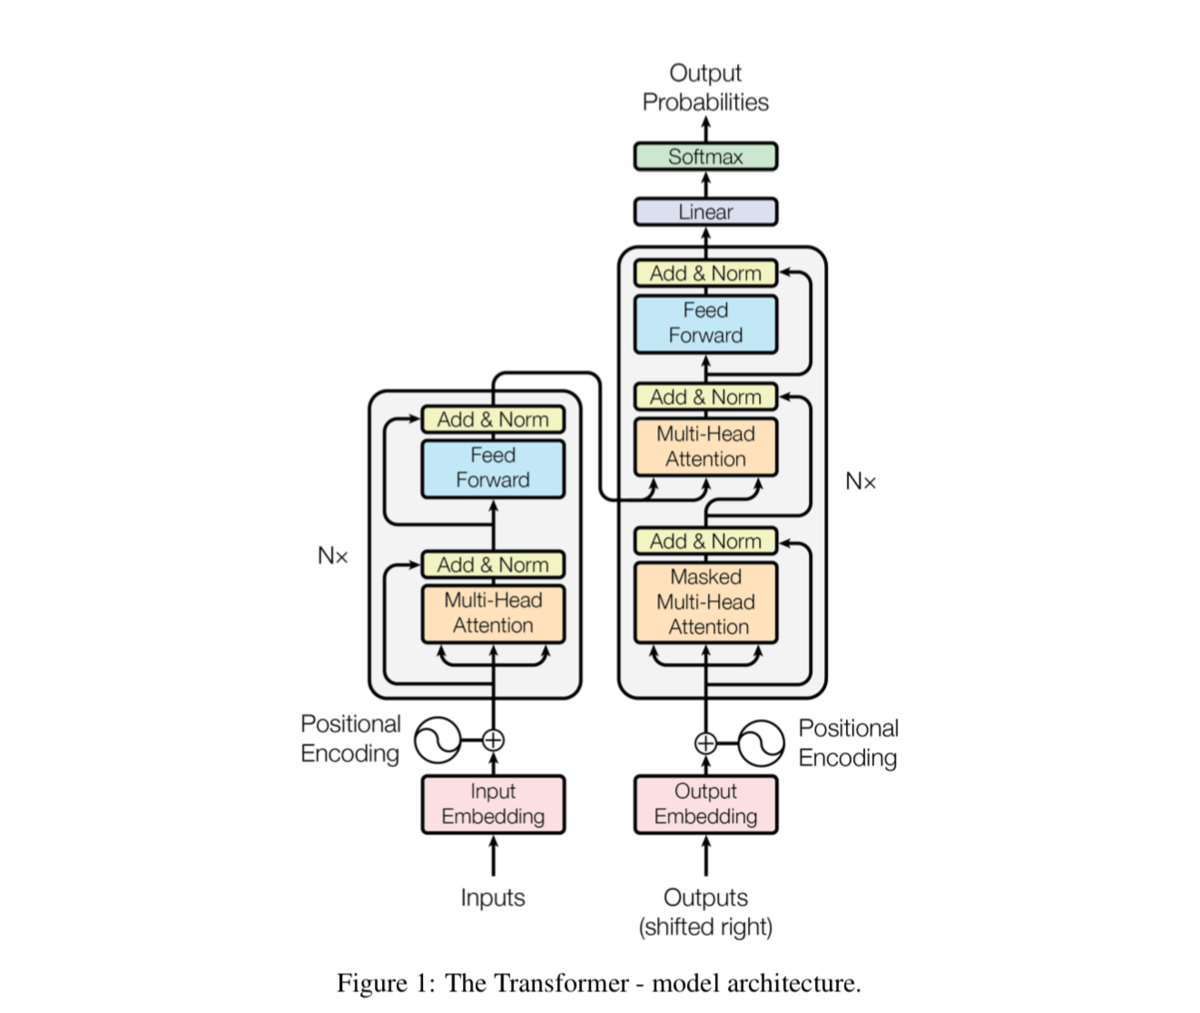

## 実装演習

### seq2seq

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0
False


In [4]:
!wget https://www.dropbox.com/s/9narw5x4uizmehh/utils.py
!mkdir images data

# data取得
!wget https://www.dropbox.com/s/o4kyc52a8we25wy/dev.en -P data/
!wget https://www.dropbox.com/s/kdgskm5hzg6znuc/dev.ja -P data/
!wget https://www.dropbox.com/s/gyyx4gohv9v65uh/test.en -P data/
!wget https://www.dropbox.com/s/hotxwbgoe2n013k/test.ja -P data/
!wget https://www.dropbox.com/s/5lsftkmb20ay9e1/train.en -P data/
!wget https://www.dropbox.com/s/ak53qirssci6f1j/train.ja -P data/

--2021-07-13 23:37:59--  https://www.dropbox.com/s/9narw5x4uizmehh/utils.py
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6030:18::a27d:5012, 162.125.80.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6030:18::a27d:5012|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9narw5x4uizmehh/utils.py [following]
--2021-07-13 23:37:59--  https://www.dropbox.com/s/raw/9narw5x4uizmehh/utils.py
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc115e133a8268dece51b4e316bf.dl.dropboxusercontent.com/cd/0/inline/BSOYTqGERGg0eUbCbOvdjkOVjUZ1XRXOzgJfANOtP1PQObl8h5IIFgzAgAXg1-Zrzih8LAgptFvmUoo9AckRi5V4vVlLRIeS8VlaDG2wwWcfsBzL1PptOuY4S-K0yq-UH6bIEEQ_nfWj9zvJRV2y2ucx/file# [following]
--2021-07-13 23:37:59--  https://uc115e133a8268dece51b4e316bf.dl.dropboxusercontent.com/cd/0/inline/BSOYTqGERGg0eUbCbOvdjkOVjUZ1XRXOzgJfANOtP1PQObl8h5IIFgzAgAXg1-Zrzih8LAgptFvmUoo9Ack

In [5]:
! ls data

__pycache__       mnist.pkl         titanic_test.csv  wine.data
cancer.csv        mnist.py          titanic_train.csv
dev.en            test.en           train.en
dev.ja            test.ja           train.ja


In [7]:
!pip install nltk

     |████████████████████████████████| 1.5 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 5.6 MB/s eta 0:00:011
     |████████████████████████████████| 76 kB 6.1 MB/s eta 0:00:011
     |████████████████████████████████| 285 kB 5.9 MB/s eta 0:00:01


In [8]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk import bleu_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from utils import Vocab

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)
random_state = 42

print(torch.__version__)

1.9.0


1.データセットの準備

英語-日本語の対訳コーパスである、Tanaka Corpus ( http://www.edrdg.org/wiki/index.php/Tanaka_Corpus )を使います。
今回はそのうちの一部分を取り出したsmall_parallel_enja: 50k En/Ja Parallel Corpus for Testing SMT Methods ( https://github.com/odashi/small_parallel_enja )を使用します。

train.enとtrain.jaの中身を見てみましょう。

In [9]:
! head -10 data/train.en

i can 't tell who will arrive first .
many animals have been destroyed by men .
i 'm in the tennis club .
emi looks happy .
please bear this fact in mind .
she takes care of my children .
we want to be international .
you ought not to break your promise .
when you cross the street , watch out for cars .
i have nothing to live for .


In [10]:
! head -10 ./data/train.ja

誰 が 一番 に 着 く か 私 に は 分か り ま せ ん 。
多く の 動物 が 人間 に よ っ て 滅ぼ さ れ た 。
私 は テニス 部員 で す 。
エミ は 幸せ そう に 見え ま す 。
この 事実 を 心 に 留め て お い て 下さ い 。
彼女 は 私 たち の 世話 を し て くれ る 。
私 達 は 国際 人 に な り た い と 思 い ま す 。
約束 を 破 る べ き で は あ り ま せ ん 。
道路 を 横切 る とき は 車 に 注意 し なさ い 。
私 に は 生き 甲斐 が な い 。


1.1データの読み込みと単語の分割

In [11]:
def load_data(file_path):
    # テキストファイルからデータを読み込むメソッド
    data = []
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()  # スペースで単語を分割
        data.append(words)
    return data

train_X = load_data('./data/train.en')
train_Y = load_data('./data/train.ja')

# 訓練データと検証データに分割
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=random_state)

print('train data', train_X[0])
print('valid data', valid_X[0])

train data ['where', 'shall', 'we', 'eat', 'tonight', '?']
valid data ['you', 'may', 'extend', 'your', 'stay', 'in', 'tokyo', '.']


1.2単語辞書の作成

データセットに登場する各単語にIDを割り振る

In [12]:
# まず特殊トークンを定義しておく
PAD_TOKEN = '<PAD>'  # バッチ処理の際に、短い系列の末尾を埋めるために使う （Padding）
BOS_TOKEN = '<S>'  # 系列の始まりを表す （Beggining of sentence）
EOS_TOKEN = '</S>'  # 系列の終わりを表す （End of sentence）
UNK_TOKEN = '<UNK>'  # 語彙に存在しない単語を表す （Unknown）
PAD = 0
BOS = 1
EOS = 2
UNK = 3

MIN_COUNT = 2  # 語彙に含める単語の最低出現回数 再提出現回数に満たない単語はUNKに置き換えられる

# 単語をIDに変換する辞書の初期値を設定
word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

# 単語辞書を作成
vocab_X = Vocab(word2id=word2id)
vocab_Y = Vocab(word2id=word2id)
vocab_X.build_vocab(train_X, min_count=MIN_COUNT)
vocab_Y.build_vocab(train_Y, min_count=MIN_COUNT)

vocab_size_X = len(vocab_X.id2word)
vocab_size_Y = len(vocab_Y.id2word)
print('入力言語の語彙数：', vocab_size_X)
print('出力言語の語彙数：', vocab_size_Y)

入力言語の語彙数： 3725
出力言語の語彙数： 4405


2.テンソルへの変換

2.1 IDへの変換

まずはモデルが文章を認識できるように、文章を単語IDのリストに変換します

In [13]:
def sentence_to_ids(vocab, sentence):
    # 単語(str)のリストをID(int)のリストに変換する関数
    ids = [vocab.word2id.get(word, UNK) for word in sentence]
    ids += [EOS]  # EOSを加える
    return ids

train_X = [sentence_to_ids(vocab_X, sentence) for sentence in train_X]
train_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in train_Y]
valid_X = [sentence_to_ids(vocab_X, sentence) for sentence in valid_X]
valid_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in valid_Y]

print('train data', train_X[0])
print('valid data', valid_X[0])

train data [132, 321, 28, 290, 367, 12, 2]
valid data [8, 93, 3532, 36, 236, 13, 284, 4, 2]


2.2 DataLoaderの定義

データセットからバッチを取得するデータローダーを定義します

この際、長さの異なる複数の系列をバッチで並列に扱えるように、短い系列の末尾を特定のシンボル（<PAD>など）でパディングし、バッチ内の系列の長さを最長のものに合わせる
(batch_size, max_length)のサイズの行列を得るが、実際にモデルを学習させるときには、バッチをまたいで各時刻ごとに進めていくので、転置して(max_length, batch_size)の形に変える
（batch_first=Trueのオプションを使う場合は不要）

In [14]:
def pad_seq(seq, max_length):
    # 系列(seq)が指定の文長(max_length)になるように末尾をパディングする
    res = seq + [PAD for i in range(max_length - len(seq))]
    return res

class DataLoader(object):

    def __init__(self, X, Y, batch_size, shuffle=False):
        """
        :param X: list, 入力言語の文章（単語IDのリスト）のリスト
        :param Y: list, 出力言語の文章（単語IDのリスト）のリスト
        :param batch_size: int, バッチサイズ
        :param shuffle: bool, サンプルの順番をシャッフルするか否か
        """
        self.data = list(zip(X, Y))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        
        self.reset()
    
    def reset(self):
        if self.shuffle:  # サンプルの順番をシャッフルする
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0  # ポインタの位置を初期化する
    
    def __iter__(self):
        return self

    def __next__(self):
        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        # バッチを取得
        seqs_X, seqs_Y = zip(*self.data[self.start_index:self.start_index+self.batch_size])
        # 入力系列seqs_Xの文章の長さ順（降順）に系列ペアをソートする
        seq_pairs = sorted(zip(seqs_X, seqs_Y), key=lambda p: len(p[0]), reverse=True)
        seqs_X, seqs_Y = zip(*seq_pairs)
        # 短い系列の末尾をパディングする
        lengths_X = [len(s) for s in seqs_X]  # 後述のEncoderのpack_padded_sequenceでも用いる
        lengths_Y = [len(s) for s in seqs_Y]
        max_length_X = max(lengths_X)
        max_length_Y = max(lengths_Y)
        padded_X = [pad_seq(s, max_length_X) for s in seqs_X]
        padded_Y = [pad_seq(s, max_length_Y) for s in seqs_Y]
        # tensorに変換し、転置する
        batch_X = torch.tensor(padded_X, dtype=torch.long, device=device).transpose(0, 1)
        batch_Y = torch.tensor(padded_Y, dtype=torch.long, device=device).transpose(0, 1)

        # ポインタを更新する
        self.start_index += self.batch_size

        return batch_X, batch_Y, lengths_X

3.モデルの構築

EncoderとDecoderのRNNを定義します。

PyTorchのRNNでは、可変長の系列のバッチを効率よく計算できるように系列を表現するPackedSequenceというクラスを用いることができます。
入力バッチのテンソルをこのPackedSequenceのインスタンスに変換してからRNNに入力することで、パディング部分の計算を省略することができるため、効率的な計算が可能になります。
PackedSequenceを作成するには、まず、系列長の異なるバッチに対してパディングを行なってください。
ここで、パディングを行う前に各サンプルの系列長(lengths)を保存しておきます。

In [15]:
# 系列長がそれぞれ4,3,2の3つのサンプルからなるバッチを作成
batch = [[1,2,3,4], [5,6,7], [8,9]]
lengths = [len(sample) for sample in batch]
print('各サンプルの系列長:', lengths)
print()

# 最大系列長に合うように各サンプルをpadding
_max_length = max(lengths)
padded = torch.tensor([pad_seq(sample, _max_length) for sample in batch])
print('paddingされたテンソル:\n', padded)
padded = padded.transpose(0,1) # (max_length, batch_size)に転置
print('padding & 転置されたテンソル:\n', padded)
print('padding & 転置されたテンソルのサイズ:\n', padded.size())
print()

各サンプルの系列長: [4, 3, 2]

paddingされたテンソル:
 tensor([[1, 2, 3, 4],
        [5, 6, 7, 0],
        [8, 9, 0, 0]])
padding & 転置されたテンソル:
 tensor([[1, 5, 8],
        [2, 6, 9],
        [3, 7, 0],
        [4, 0, 0]])
padding & 転置されたテンソルのサイズ:
 torch.Size([4, 3])



次に、パディングを行ったテンソル(padded)と各サンプルの元々の系列長(lengths)をtorch.nn.utils.rnn.pack_padded_sequenceという関数に与えると、 dataとbatch_sizesという要素を持ったPackedSequenceのインスタンス(packed)が作成できます。

data: テンソルのPAD以外の値のみを保有するベクトル

batch_sizes: 各時刻で計算が必要な(=PADに到達していない)バッチの数を表すベクトル

In [16]:
# PackedSequenceに変換（テンソルをRNNに入力する前に適用する）
packed = pack_padded_sequence(padded, lengths=lengths) # 各サンプルの系列長も与える
print('PackedSequenceのインスタンス:\n', packed) # テンソルのPAD以外の値(data)と各時刻で計算が必要な(=PADに到達していない)バッチの数(batch_sizes)を有するインスタンス
print()

PackedSequenceのインスタンス:
 PackedSequence(data=tensor([1, 5, 8, 2, 6, 9, 3, 7, 4]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=None, unsorted_indices=None)



こうして得られたPackedSequenceのインスタンスをRNNに入力します。（ここでは省略）

RNNから出力されたテンソルはPackedSeauenceのインスタンスのままなので、後段の計算につなぐためにtorch.nn.utils.rnn.pad_packed_sequenceの関数によって通常のテンソルに戻します。

In [17]:
# PackedSequenceのインスタンスをRNNに入力する（ここでは省略）
output = packed

# テンソルに戻す(RNNの出力に対して適用する)
output, _length = pad_packed_sequence(output)  # PADを含む元のテンソルと各サンプルの系列長を返す
print('PADを含む元のテンソル:\n', output)
print('各サンプルの系列長:', _length)

PADを含む元のテンソル:
 tensor([[1, 5, 8],
        [2, 6, 9],
        [3, 7, 0],
        [4, 0, 0]])
各サンプルの系列長: tensor([4, 3, 2])


Encoder

今回はEncoder側でバッチを処理する際に、pack_padded_sequence関数によってtensorをPackedSequenceに変換し、処理を終えた後にpad_packed_sequence関数によってtensorに戻すという処理を行います。

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        :param input_size: int, 入力言語の語彙数
        :param hidden_size: int, 隠れ層のユニット数
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size, padding_idx=PAD)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, seqs, input_lengths, hidden=None):
        """
        :param seqs: tensor, 入力のバッチ, size=(max_length, batch_size)
        :param input_lengths: 入力のバッチの各サンプルの文長
        :param hidden: tensor, 隠れ状態の初期値, Noneの場合は0で初期化される
        :return output: tensor, Encoderの出力, size=(max_length, batch_size, hidden_size)
        :return hidden: tensor, Encoderの隠れ状態, size=(1, batch_size, hidden_size)
        """
        emb = self.embedding(seqs) # seqsはパディング済み
        packed = pack_padded_sequence(emb, input_lengths) # PackedSequenceオブジェクトに変換
        output, hidden = self.gru(packed, hidden)
        output, _ = pad_packed_sequence(output)
        return output, hidden

Decoder

今回はDecoder側ではパディング等行わないので、通常のtensorのままRNNに入力して問題ありません。

In [19]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        """
        :param hidden_size: int, 隠れ層のユニット数
        :param output_size: int, 出力言語の語彙数
        :param dropout: float, ドロップアウト率
        """
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size, padding_idx=PAD)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, seqs, hidden):
        """
        :param seqs: tensor, 入力のバッチ, size=(1, batch_size)
        :param hidden: tensor, 隠れ状態の初期値, Noneの場合は0で初期化される
        :return output: tensor, Decoderの出力, size=(1, batch_size, output_size)
        :return hidden: tensor, Decoderの隠れ状態, size=(1, batch_size, hidden_size)
        """
        emb = self.embedding(seqs)
        output, hidden = self.gru(emb, hidden)
        output = self.out(output)
        return output, hidden

EncoderDecoder

上で定義したEncoderとDecoderを用いた、一連の処理をまとめるEncoderDecoderのクラスを定義します。

ここで、Decoder側の処理で注意する点があります。

RNNでは、時刻 
t
 の出力を時刻 
t
+
1
 の入力とすることができるが、この方法でDecoderを学習させると連鎖的に誤差が大きくなっていき、学習が不安定になったり収束が遅くなったりする問題が発生します。

この問題への対策としてTeacher Forcingというテクニックがあります。 これは、訓練時にはDecoder側の入力に、ターゲット系列（参照訳）をそのまま使うというものです。 これにより学習が安定し、収束が早くなるというメリットがありますが、逆に評価時は前の時刻にDecoderが生成したものが使われるため、学習時と分布が異なってしまうというデメリットもあります。

Teacher Forcingの拡張として、ターゲット系列を入力とするか生成された結果を入力とするかを確率的にサンプリングするScheduled Samplingという手法があります。

ここではScheduled Samplingを採用し、一定の確率に基づいてターゲット系列を入力とするか生成された結果を入力とするかを切り替えられるようにクラスを定義しておきます。

In [20]:
class EncoderDecoder(nn.Module):
    """EncoderとDecoderの処理をまとめる"""
    def __init__(self, input_size, output_size, hidden_size):
        """
        :param input_size: int, 入力言語の語彙数
        :param output_size: int, 出力言語の語彙数
        :param hidden_size: int, 隠れ層のユニット数
        """
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder(input_size, hidden_size)
        self.decoder = Decoder(hidden_size, output_size)

    def forward(self, batch_X, lengths_X, max_length, batch_Y=None, use_teacher_forcing=False):
        """
        :param batch_X: tensor, 入力系列のバッチ, size=(max_length, batch_size)
        :param lengths_X: list, 入力系列のバッチ内の各サンプルの文長
        :param max_length: int, Decoderの最大文長
        :param batch_Y: tensor, Decoderで用いるターゲット系列
        :param use_teacher_forcing: Decoderでターゲット系列を入力とするフラグ
        :return decoder_outputs: tensor, Decoderの出力, 
            size=(max_length, batch_size, self.decoder.output_size)
        """
        # encoderに系列を入力（複数時刻をまとめて処理）
        _, encoder_hidden = self.encoder(batch_X, lengths_X)
        
        _batch_size = batch_X.size(1)

        # decoderの入力と隠れ層の初期状態を定義
        decoder_input = torch.tensor([BOS] * _batch_size, dtype=torch.long, device=device) # 最初の入力にはBOSを使用する
        decoder_input = decoder_input.unsqueeze(0)  # (1, batch_size)
        decoder_hidden = encoder_hidden  # Encoderの最終隠れ状態を取得

        # decoderの出力のホルダーを定義
        decoder_outputs = torch.zeros(max_length, _batch_size, self.decoder.output_size, device=device) # max_length分の固定長

        # 各時刻ごとに処理
        for t in range(max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_output
            # 次の時刻のdecoderの入力を決定
            if use_teacher_forcing and batch_Y is not None:  # teacher forceの場合、ターゲット系列を用いる
                decoder_input = batch_Y[t].unsqueeze(0)
            else:  # teacher forceでない場合、自身の出力を用いる
                decoder_input = decoder_output.max(-1)[1]
                
        return decoder_outputs

4.訓練

4.1 損失関数の定義

基本的にはクロスエントロピーを損失関数として用いますが、パディングを行うと短い系列の末尾には<PAD>トークンが入るため、この部分の損失を計算しないように、マスクをかけます。

In [21]:
mce = nn.CrossEntropyLoss(size_average=False, ignore_index=PAD) # PADを無視する
def masked_cross_entropy(logits, target):
    logits_flat = logits.view(-1, logits.size(-1)) # (max_seq_len * batch_size, output_size)
    target_flat = target.view(-1) # (max_seq_len * batch_size, 1)
    return mce(logits_flat, target_flat)

/usr/local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


4.2学習

In [22]:
# ハイパーパラメータの設定
num_epochs = 10
batch_size = 64
lr = 1e-3  # 学習率
teacher_forcing_rate = 0.2  # Teacher Forcingを行う確率
ckpt_path = 'model.pth'  # 学習済みのモデルを保存するパス

model_args = {
    'input_size': vocab_size_X,
    'output_size': vocab_size_Y,
    'hidden_size': 256,
}

In [23]:
# データローダを定義
train_dataloader = DataLoader(train_X, train_Y, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_X, valid_Y, batch_size=batch_size, shuffle=False)

# モデルとOptimizerを定義
model = EncoderDecoder(**model_args).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [24]:
def compute_loss(batch_X, batch_Y, lengths_X, model, optimizer=None, is_train=True):
    # 損失を計算する関数
    model.train(is_train)  # train/evalモードの切替え
    
    # 一定確率でTeacher Forcingを行う
    use_teacher_forcing = is_train and (random.random() < teacher_forcing_rate)
    max_length = batch_Y.size(0)
    # 推論
    pred_Y = model(batch_X, lengths_X, max_length, batch_Y, use_teacher_forcing)
    
    # 損失関数を計算
    loss = masked_cross_entropy(pred_Y.contiguous(), batch_Y.contiguous())
    
    if is_train:  # 訓練時はパラメータを更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    batch_Y = batch_Y.transpose(0, 1).contiguous().data.cpu().tolist()
    pred = pred_Y.max(dim=-1)[1].data.cpu().numpy().T.tolist()

    return loss.item(), batch_Y, pred

ここで、Loss以外に、学習の進捗を確認するためにモデルの性能を評価する指標として、BLEUを計算します。

BLEUは機械翻訳の分野において最も一般的な自動評価基準の一つで、予め用意した複数の参照訳と、機械翻訳モデルが出力した訳のn-gramのマッチ率に基づく指標です。

NLTK (Natural Language Tool Kit) という自然言語処理で用いられるライブラリを用いて簡単に計算することができます。

In [25]:
def calc_bleu(refs, hyps):
    """
    BLEUスコアを計算する関数
    :param refs: list, 参照訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :param hyps: list, モデルの生成した訳。単語のリストのリスト (例： ['I', 'have', 'a', 'pen'])
    :return: float, BLEUスコア(0~100)
    """
    refs = [[ref[:ref.index(EOS)]] for ref in refs] # EOSは評価しないで良いので切り捨てる, refsのほうは複数なのでlistが一個多くかかっている
    hyps = [hyp[:hyp.index(EOS)] if EOS in hyp else hyp for hyp in hyps]
    return 100 * bleu_score.corpus_bleu(refs, hyps)

In [26]:
# 訓練
best_valid_bleu = 0.

for epoch in range(1, num_epochs+1):
    train_loss = 0.
    train_refs = []
    train_hyps = []
    valid_loss = 0.
    valid_refs = []
    valid_hyps = []
    # train
    for batch in train_dataloader:
        batch_X, batch_Y, lengths_X = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, lengths_X, model, optimizer, 
            is_train=True
            )
        train_loss += loss
        train_refs += gold
        train_hyps += pred
    # valid
    for batch in valid_dataloader:
        batch_X, batch_Y, lengths_X = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, lengths_X, model, 
            is_train=False
            )
        valid_loss += loss
        valid_refs += gold
        valid_hyps += pred
    # 損失をサンプル数で割って正規化
    train_loss = np.sum(train_loss) / len(train_dataloader.data)
    valid_loss = np.sum(valid_loss) / len(valid_dataloader.data)
    # BLEUを計算
    train_bleu = calc_bleu(train_refs, train_hyps)
    valid_bleu = calc_bleu(valid_refs, valid_hyps)

    # validationデータでBLEUが改善した場合にはモデルを保存
    if valid_bleu > best_valid_bleu:
        ckpt = model.state_dict()
        torch.save(ckpt, ckpt_path)
        best_valid_bleu = valid_bleu

    print('Epoch {}: train_loss: {:5.2f}  train_bleu: {:2.2f}  valid_loss: {:5.2f}  valid_bleu: {:2.2f}'.format(
            epoch, train_loss, train_bleu, valid_loss, valid_bleu))
        
    print('-'*80)

Epoch 1: train_loss: 52.40  train_bleu: 3.32  valid_loss: 48.84  valid_bleu: 4.97
--------------------------------------------------------------------------------
Epoch 2: train_loss: 44.50  train_bleu: 7.69  valid_loss: 44.68  valid_bleu: 7.81
--------------------------------------------------------------------------------
Epoch 3: train_loss: 40.17  train_bleu: 11.21  valid_loss: 42.29  valid_bleu: 10.52
--------------------------------------------------------------------------------
Epoch 4: train_loss: 37.42  train_bleu: 13.78  valid_loss: 41.27  valid_bleu: 13.30
--------------------------------------------------------------------------------
Epoch 5: train_loss: 34.89  train_bleu: 16.77  valid_loss: 40.22  valid_bleu: 13.10
--------------------------------------------------------------------------------
Epoch 6: train_loss: 33.16  train_bleu: 18.86  valid_loss: 39.91  valid_bleu: 15.13
--------------------------------------------------------------------------------
Epoch 7: train

5.評価

In [27]:
# 学習済みモデルの読み込み
ckpt = torch.load(ckpt_path) # cpuで処理する場合はmap_locationで指定する必要があります。
model.load_state_dict(ckpt)
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(3725, 256, padding_idx=0)
    (gru): GRU(256, 256)
  )
  (decoder): Decoder(
    (embedding): Embedding(4405, 256, padding_idx=0)
    (gru): GRU(256, 256)
    (out): Linear(in_features=256, out_features=4405, bias=True)
  )
)

In [28]:
def ids_to_sentence(vocab, ids):
    # IDのリストを単語のリストに変換する
    return [vocab.id2word[_id] for _id in ids]

def trim_eos(ids):
    # IDのリストからEOS以降の単語を除外する
    if EOS in ids:
        return ids[:ids.index(EOS)]
    else:
        return ids

In [29]:
# テストデータの読み込み
test_X = load_data('./data/dev.en')
test_Y = load_data('./data/dev.ja')

test_X = [sentence_to_ids(vocab_X, sentence) for sentence in test_X]
test_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in test_Y]

test_dataloader = DataLoader(test_X, test_Y, batch_size=1, shuffle=False)

# 生成
batch_X, batch_Y, lengths_X = next(test_dataloader)
sentence_X = ' '.join(ids_to_sentence(vocab_X, batch_X.data.cpu().numpy()[:-1, 0]))
sentence_Y = ' '.join(ids_to_sentence(vocab_Y, batch_Y.data.cpu().numpy()[:-1, 0]))
print('src: {}'.format(sentence_X))
print('tgt: {}'.format(sentence_Y))

output = model(batch_X, lengths_X, max_length=20)
output = output.max(dim=-1)[1].view(-1).data.cpu().tolist()
output_sentence = ' '.join(ids_to_sentence(vocab_Y, trim_eos(output)))
output_sentence_without_trim = ' '.join(ids_to_sentence(vocab_Y, output))
print('out: {}'.format(output_sentence))
print('without trim: {}'.format(output_sentence_without_trim))

src: show your own business .
tgt: 自分 の 事 を しろ 。
out: 自分 の 仕事 を を し て い 。
without trim: 自分 の 仕事 を を し て い 。 </S> </S> </S> </S> </S> </S> </S> </S> </S> </S> </S>


In [30]:
# BLEUの計算
test_dataloader = DataLoader(test_X, test_Y, batch_size=1, shuffle=False)
refs_list = []
hyp_list = []

for batch in test_dataloader:
    batch_X, batch_Y, lengths_X = batch
    pred_Y = model(batch_X, lengths_X, max_length=20)
    pred = pred_Y.max(dim=-1)[1].view(-1).data.cpu().tolist()
    refs = batch_Y.view(-1).data.cpu().tolist()
    refs_list.append(refs)
    hyp_list.append(pred)
bleu = calc_bleu(refs_list, hyp_list)
print(bleu)

19.135102961676314


### Transformer

In [32]:
! wget https://www.dropbox.com/s/9narw5x4uizmehh/utils.py
! mkdir images data

# data取得
! wget https://www.dropbox.com/s/o4kyc52a8we25wy/dev.en -P data/
! wget https://www.dropbox.com/s/kdgskm5hzg6znuc/dev.ja -P data/
! wget https://www.dropbox.com/s/gyyx4gohv9v65uh/test.en -P data/
! wget https://www.dropbox.com/s/hotxwbgoe2n013k/test.ja -P data/
! wget https://www.dropbox.com/s/5lsftkmb20ay9e1/train.en -P data/
! wget https://www.dropbox.com/s/ak53qirssci6f1j/train.ja -P data/

--2021-07-14 00:57:45--  https://www.dropbox.com/s/9narw5x4uizmehh/utils.py
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6030:18::a27d:5012, 162.125.80.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6030:18::a27d:5012|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9narw5x4uizmehh/utils.py [following]
--2021-07-14 00:57:45--  https://www.dropbox.com/s/raw/9narw5x4uizmehh/utils.py
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc46ba7ddf3520df73be9fdff9d8.dl.dropboxusercontent.com/cd/0/inline/BSPqyZXlcXbBDsqyHixZ2HV_5K6cMELooWgKyxiXRj2CYvThaFaF9QBK1zUmO-VPa6K4VsJuwN2Q2cpXMmMkr82wRgn1tSzViGnFgKqKjBtvRAT6o8xjLLRQNIuo4c_vcfqcS700Cl1MBzfDsU1CMqeu/file# [following]
--2021-07-14 00:57:45--  https://uc46ba7ddf3520df73be9fdff9d8.dl.dropboxusercontent.com/cd/0/inline/BSPqyZXlcXbBDsqyHixZ2HV_5K6cMELooWgKyxiXRj2CYvThaFaF9QBK1zUmO-VPa6K4VsJuwN2Q2cpXMmM

In [33]:
import time
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk import bleu_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils import Vocab

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)
random_state = 42

print(torch.__version__)

1.9.0


In [34]:
PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
BOS_TOKEN = '<S>'
EOS_TOKEN = '</S>'

1. データセット

In [35]:
def load_data(file_path):
    """
    テキストファイルからデータを読み込む
    :param file_path: str, テキストファイルのパス
    :return data: list, 文章（単語のリスト）のリスト
    """
    data = []
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()  # スペースで単語を分割
        data.append(words)
    return data

train_X = load_data('./data/train.en')
train_Y = load_data('./data/train.ja')

# 訓練データと検証データに分割
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=random_state)

# データセットの中身を確認
print('train_X:', train_X[:5])
print('train_Y:', train_Y[:5])

train_X: [['where', 'shall', 'we', 'eat', 'tonight', '?'], ['i', 'made', 'a', 'big', 'mistake', 'in', 'choosing', 'my', 'wife', '.'], ['i', "'ll", 'have', 'to', 'think', 'about', 'it', '.'], ['it', 'is', 'called', 'a', 'lily', '.'], ['could', 'you', 'lend', 'me', 'some', 'money', 'until', 'this', 'weekend', '?']]
train_Y: [['今夜', 'は', 'どこ', 'で', '食事', 'を', 'し', 'よ', 'う', 'か', '。'], ['僕', 'は', '妻', 'を', '選', 'ぶ', 'の', 'に', '大変', 'な', '間違い', 'を', 'し', 'た', '。'], ['考え', 'と', 'く', 'よ', '。'], ['ｌｉｌｙ', 'と', '呼', 'ば', 'れ', 'て', 'い', 'ま', 'す', '。'], ['今週末', 'まで', 'いくら', 'か', '金', 'を', '貸', 'し', 'て', 'くれ', 'ま', 'せ', 'ん', 'か', '。']]


In [36]:
MIN_COUNT = 2  # 語彙に含める単語の最低出現回数

word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

vocab_X = Vocab(word2id=word2id)
vocab_Y = Vocab(word2id=word2id)
vocab_X.build_vocab(train_X, min_count=MIN_COUNT)
vocab_Y.build_vocab(train_Y, min_count=MIN_COUNT)

vocab_size_X = len(vocab_X.id2word)
vocab_size_Y = len(vocab_Y.id2word)

def sentence_to_ids(vocab, sentence):
    """
    単語のリストをインデックスのリストに変換する
    :param vocab: Vocabのインスタンス
    :param sentence: list of str
    :return indices: list of int
    """
    ids = [vocab.word2id.get(word, UNK) for word in sentence]
    ids = [BOS] + ids + [EOS]  # EOSを末尾に加える
    return ids

train_X = [sentence_to_ids(vocab_X, sentence) for sentence in train_X]
train_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in train_Y]
valid_X = [sentence_to_ids(vocab_X, sentence) for sentence in valid_X]
valid_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in valid_Y]

In [37]:
class DataLoader(object):
    def __init__(self, src_insts, tgt_insts, batch_size, shuffle=True):
        """
        :param src_insts: list, 入力言語の文章（単語IDのリスト）のリスト
        :param tgt_insts: list, 出力言語の文章（単語IDのリスト）のリスト
        :param batch_size: int, バッチサイズ
        :param shuffle: bool, サンプルの順番をシャッフルするか否か
        """
        self.data = list(zip(src_insts, tgt_insts))

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        
        self.reset()
    
    def reset(self):
        if self.shuffle:
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0
    
    def __iter__(self):
        return self
    
    def __next__(self):

        def preprocess_seqs(seqs):
            # パディング
            max_length = max([len(s) for s in seqs])
            data = [s + [PAD] * (max_length - len(s)) for s in seqs]
            # 単語の位置を表現するベクトルを作成
            positions = [[pos+1 if w != PAD else 0 for pos, w in enumerate(seq)] for seq in data]
            # テンソルに変換
            data_tensor = torch.tensor(data, dtype=torch.long, device=device)
            position_tensor = torch.tensor(positions, dtype=torch.long, device=device)
            return data_tensor, position_tensor            

        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        # バッチを取得して前処理
        src_seqs, tgt_seqs = zip(*self.data[self.start_index:self.start_index+self.batch_size])
        src_data, src_pos = preprocess_seqs(src_seqs)
        tgt_data, tgt_pos = preprocess_seqs(tgt_seqs)

        # ポインタを更新する
        self.start_index += self.batch_size

        return (src_data, src_pos), (tgt_data, tgt_pos)

2. 各モジュールの定義

TransformerのモデルもEncoder-Decoderモデルの構造になっています。 EncoderとDecoderは

Positional Encoding: 入出力の単語のEmbedding時に単語の位置情報を埋め込む
Scaled Dot-Product Attention: 内積でAttentionを計算し、スケーリングを行う
Multi-head Attention: Scaled Dot-Product Attentionを複数のヘッドで並列化する
Position-Wise Feed Forward Network: 単語列の位置ごとに独立して処理を行う など、いくつかのモジュールから構成されているため、それぞれのモジュールを個別に定義していきます。

① Position Encoding

Transformerは系列の処理にRNNを使用しないので、そのままでは単語列の語順を考慮することができません。

そのため、入力系列の埋め込み行列に単語の位置情報を埋め込むPosition Encodingを加算します。

Positional Encodingの行列$PE$の各成分は次式で表されます。
$PE_{(pos, 2i)} = \sin(pos/10000^{2i/d_{model}})$

$PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/d_{model}})$
ここで$pos$は単語の位置を、$i$は成分の次元を表しています。

Positional Encodingの各成分は、波長が$2\pi$から$10000*2\pi$に幾何学的に伸びる正弦波に対応します。

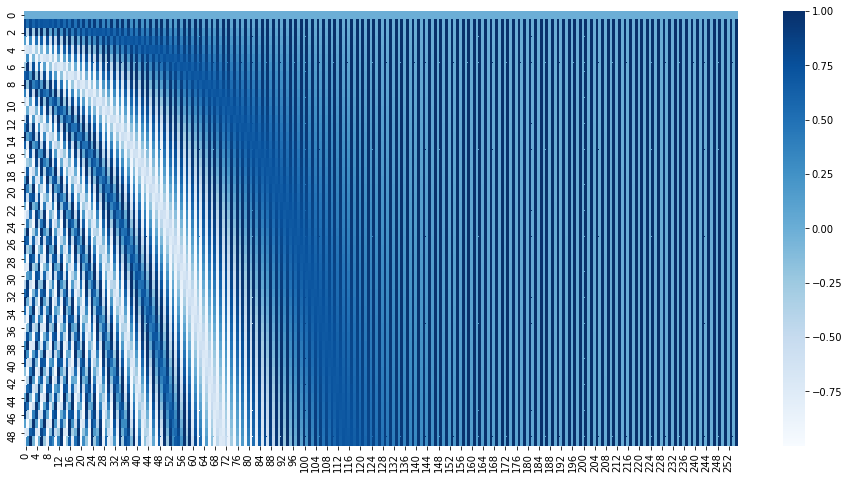

In [38]:
def position_encoding_init(n_position, d_pos_vec):
    """
    Positional Encodingのための行列の初期化を行う
    :param n_position: int, 系列長
    :param d_pos_vec: int, 隠れ層の次元数
    :return torch.tensor, size=(n_position, d_pos_vec)
    """
    # PADがある単語の位置はpos=0にしておき、position_encも0にする
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_pos_vec) for j in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])
    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2])  # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2])  # dim 2i+1
    return torch.tensor(position_enc, dtype=torch.float)

pe = position_encoding_init(50, 256).numpy()
plt.figure(figsize=(16,8))
sns.heatmap(pe, cmap='Blues')
plt.show()

② Multihead Attention

ソース・ターゲット注意機構と自己注意機構
Attentionは一般に、queryベクトルとkeyベクトルの類似度を求めて、その正規化した重みをvalueベクトルに適用して値を取り出す処理を行います。

一般的な翻訳モデルで用いられるAttentionはソース・ターゲット注意機構と呼ばれ、この場合queryはDecoderの隠れ状態(Target)、keyはEncoderの隠れ状態(Source)、valueもEncoderの隠れ状態(Source)で表現されるのが一般的です。モデル全体の図では、右側のDecoderブロックの中央にあるAttentionがこれに相当します。

Transformerでは、このソース・ターゲット注意機構に加えて、query,key,valueを同じ系列内で定義する自己注意機構を用います。これにより、ある単語位置の出力を求める際にあらゆる位置を参照できるため、局所的な位置しか参照できない畳み込み層よりも良い性能を発揮できると言われています。モデル全体の図では、左側のEncoderブロックと右側のDecoderブロックの下部にあるAttentionがこれに当たります。

Transformerでは、Scaled Dot-Product Attentionと呼ばれるAttentionを、複数のヘッドで並列に扱うMulti-Head Attentionによって、Source-Target-AttentionとSelf-Attentionを実現します。

Scaled Dot-Product Attention

Attentionには、注意の重みを隠れ層 1 つのフィードフォワードネットワークで求めるAdditive Attentionと、注意の重みを内積で求めるDot-Product Attentionが存在します。  一般に、Dot-Product Attentionのほうがパラメータが少なく高速であり、Transformerでもこちらを使います。


Tranformerではさらなる工夫として、query($Q$)とkey($K$)の内積をスケーリング因子 $\sqrt{d_k}$ で除算します。

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$ 


これは、$d_k$（keyベクトルの次元数）が大きい場合に内積が大きくなりすぎて逆伝播のsoftmaxの勾配が極端に小さくなることを防ぐ役割を果たします。

In [39]:
class ScaledDotProductAttention(nn.Module):
    
    def __init__(self, d_model, attn_dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param attn_dropout: float, ドロップアウト率
        """
        super(ScaledDotProductAttention, self).__init__()
        self.temper = np.power(d_model, 0.5)  # スケーリング因子
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, attn_mask):
        """
        :param q: torch.tensor, queryベクトル, 
            size=(n_head*batch_size, len_q, d_model/n_head)
        :param k: torch.tensor, key, 
            size=(n_head*batch_size, len_k, d_model/n_head)
        :param v: torch.tensor, valueベクトル, 
            size=(n_head*batch_size, len_v, d_model/n_head)
        :param attn_mask: torch.tensor, Attentionに適用するマスク, 
            size=(n_head*batch_size, len_q, len_k)
        :return output: 出力ベクトル, 
            size=(n_head*batch_size, len_q, d_model/n_head)
        :return attn: Attention
            size=(n_head*batch_size, len_q, len_k)
        """
        # QとKの内積でAttentionの重みを求め、スケーリングする
        attn = torch.bmm(q, k.transpose(1, 2)) / self.temper  # (n_head*batch_size, len_q, len_k)
        # Attentionをかけたくない部分がある場合は、その部分を負の無限大に飛ばしてSoftmaxの値が0になるようにする
        attn.data.masked_fill_(attn_mask, -float('inf'))
        
        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)

        return output, attn

Multi-Head Attention

TransformerではAttentionを複数のヘッドで並列に行うMulti-Head Attentionを採用しています。
複数のヘッドでAttentionを行うことにより、各ヘッドが異なる部分空間を処理でき、精度が向上するとされています。

In [40]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        """
        :param n_head: int, ヘッド数
        :param d_model: int, 隠れ層の次元数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param dropout: float, ドロップアウト率
        """
        super(MultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        # 各ヘッドごとに異なる重みで線形変換を行うための重み
        # nn.Parameterを使うことで、Moduleのパラメータとして登録できる. TFでは更新が必要な変数はtf.Variableでラップするのでわかりやすい
        self.w_qs = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_ks = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_vs = nn.Parameter(torch.empty([n_head, d_model, d_v], dtype=torch.float))
        # nn.init.xavier_normal_で重みの値を初期化
        nn.init.xavier_normal_(self.w_qs)
        nn.init.xavier_normal_(self.w_ks)
        nn.init.xavier_normal_(self.w_vs)

        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = nn.LayerNorm(d_model) # 各層においてバイアスを除く活性化関数への入力を平均０、分散１に正則化
        self.proj = nn.Linear(n_head*d_v, d_model)  # 複数ヘッド分のAttentionの結果を元のサイズに写像するための線形層
        # nn.init.xavier_normal_で重みの値を初期化
        nn.init.xavier_normal_(self.proj.weight)
        
        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, attn_mask=None):
        """
        :param q: torch.tensor, queryベクトル, 
            size=(batch_size, len_q, d_model)
        :param k: torch.tensor, key, 
            size=(batch_size, len_k, d_model)
        :param v: torch.tensor, valueベクトル, 
            size=(batch_size, len_v, d_model)
        :param attn_mask: torch.tensor, Attentionに適用するマスク, 
            size=(batch_size, len_q, len_k)
        :return outputs: 出力ベクトル, 
            size=(batch_size, len_q, d_model)
        :return attns: Attention
            size=(n_head*batch_size, len_q, len_k)
            
        """
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        # residual connectionのための入力 出力に入力をそのまま加算する
        residual = q

        batch_size, len_q, d_model = q.size()
        batch_size, len_k, d_model = k.size()
        batch_size, len_v, d_model = v.size()

        # 複数ヘッド化
        # torch.repeat または .repeatで指定したdimに沿って同じテンソルを作成
        q_s = q.repeat(n_head, 1, 1) # (n_head*batch_size, len_q, d_model)
        k_s = k.repeat(n_head, 1, 1) # (n_head*batch_size, len_k, d_model)
        v_s = v.repeat(n_head, 1, 1) # (n_head*batch_size, len_v, d_model)
        # ヘッドごとに並列計算させるために、n_headをdim=0に、batch_sizeをdim=1に寄せる
        q_s = q_s.view(n_head, -1, d_model) # (n_head, batch_size*len_q, d_model)
        k_s = k_s.view(n_head, -1, d_model) # (n_head, batch_size*len_k, d_model)
        v_s = v_s.view(n_head, -1, d_model) # (n_head, batch_size*len_v, d_model)

        # 各ヘッドで線形変換を並列計算(p16左側`Linear`)
        q_s = torch.bmm(q_s, self.w_qs)  # (n_head, batch_size*len_q, d_k)
        k_s = torch.bmm(k_s, self.w_ks)  # (n_head, batch_size*len_k, d_k)
        v_s = torch.bmm(v_s, self.w_vs)  # (n_head, batch_size*len_v, d_v)
        # Attentionは各バッチ各ヘッドごとに計算させるためにbatch_sizeをdim=0に寄せる
        q_s = q_s.view(-1, len_q, d_k)   # (n_head*batch_size, len_q, d_k)
        k_s = k_s.view(-1, len_k, d_k)   # (n_head*batch_size, len_k, d_k)
        v_s = v_s.view(-1, len_v, d_v)   # (n_head*batch_size, len_v, d_v)

        # Attentionを計算(p16.左側`Scaled Dot-Product Attention * h`)
        outputs, attns = self.attention(q_s, k_s, v_s, attn_mask=attn_mask.repeat(n_head, 1, 1))

        # 各ヘッドの結果を連結(p16左側`Concat`)
        # torch.splitでbatch_sizeごとのn_head個のテンソルに分割
        outputs = torch.split(outputs, batch_size, dim=0)  # (batch_size, len_q, d_model) * n_head
        # dim=-1で連結
        outputs = torch.cat(outputs, dim=-1)  # (batch_size, len_q, d_model*n_head)

        # residual connectionのために元の大きさに写像(p16左側`Linear`)
        outputs = self.proj(outputs)  # (batch_size, len_q, d_model)
        outputs = self.dropout(outputs)
        outputs = self.layer_norm(outputs + residual)

        return outputs, attns

③ Position-Wise Feed Forward Network

単語列の位置ごとに独立して処理する2層のネットワークであるPosition-Wise Feed Forward Networkを定義します。

In [41]:
class PositionwiseFeedForward(nn.Module):
    """
    :param d_hid: int, 隠れ層1層目の次元数
    :param d_inner_hid: int, 隠れ層2層目の次元数
    :param dropout: float, ドロップアウト率
    """
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # window size 1のconv層を定義することでPosition wiseな全結合層を実現する.
        self.w_1 = nn.Conv1d(d_hid, d_inner_hid, 1)
        self.w_2 = nn.Conv1d(d_inner_hid, d_hid, 1)
        self.layer_norm = nn.LayerNorm(d_hid)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        :param x: torch.tensor,
            size=(batch_size, max_length, d_hid)
        :return: torch.tensor,
            size=(batch_size, max_length, d_hid) 
        """
        residual = x
        output = self.relu(self.w_1(x.transpose(1, 2)))
        output = self.w_2(output).transpose(2, 1)
        output = self.dropout(output)
        return self.layer_norm(output + residual)

④ Masking

TransformerではAttentionに対して２つのマスクを定義します。
一つはkey側の系列のPADトークンに対してAttentionを行わないようにするマスクです。

In [42]:
def get_attn_padding_mask(seq_q, seq_k):
    """
    keyのPADに対するattentionを0にするためのマスクを作成する
    :param seq_q: tensor, queryの系列, size=(batch_size, len_q)
    :param seq_k: tensor, keyの系列, size=(batch_size, len_k)
    :return pad_attn_mask: tensor, size=(batch_size, len_q, len_k)
    """
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(PAD).unsqueeze(1)   # (N, 1, len_k) PAD以外のidを全て0にする
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k) # (N, len_q, len_k)
    return pad_attn_mask

In [43]:
_seq_q = torch.tensor([[1, 2, 3]])
_seq_k = torch.tensor([[4, 5, 6, 7, PAD]])
_mask = get_attn_padding_mask(_seq_q, _seq_k)  # 行がquery、列がkeyに対応し、key側がPAD(=0)の時刻だけ1で他が0の行列ができる
print('query:\n', _seq_q)
print('key:\n', _seq_k)
print('mask:\n', _mask)

query:
 tensor([[1, 2, 3]])
key:
 tensor([[4, 5, 6, 7, 0]])
mask:
 tensor([[[False, False, False, False,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True]]])


In [44]:
def get_attn_subsequent_mask(seq):
    """
    未来の情報に対するattentionを0にするためのマスクを作成する
    :param seq: tensor, size=(batch_size, length)
    :return subsequent_mask: tensor, size=(batch_size, length, length)
    """
    attn_shape = (seq.size(1), seq.size(1))
    # 上三角行列(diagonal=1: 対角線より上が1で下が0)
    subsequent_mask = torch.triu(torch.ones(attn_shape, dtype=torch.uint8, device=device), diagonal=1)
    subsequent_mask = subsequent_mask.repeat(seq.size(0), 1, 1)
    return subsequent_mask

In [45]:
_seq = torch.tensor([[1,2,3,4]])
_mask = get_attn_subsequent_mask(_seq)  # 行がquery、列がkeyに対応し、queryより未来のkeyの値が1で他は0の行列ができいる
print('seq:\n', _seq)
print('mask:\n', _mask)

seq:
 tensor([[1, 2, 3, 4]])
mask:
 tensor([[[0, 1, 1, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 1],
         [0, 0, 0, 0]]], dtype=torch.uint8)


3. モデルの定義

Encoder

これまで定義してきたサブレイヤーを統合して、Encoderを定義します。

EncoderではSelf AttentionとPosition-Wise Feed Forward Networkからなるブロックを複数層繰り返すので、ブロックのクラスEncoderLayerを定義した後にEncoderを定義します。

In [46]:
class EncoderLayer(nn.Module):
    """Encoderのブロックのクラス"""
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param dropout: float, ドロップアウト率
        """
        super(EncoderLayer, self).__init__()
        # Encoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        # Postionwise FFN
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        """
        :param enc_input: tensor, Encoderの入力, 
            size=(batch_size, max_length, d_model)
        :param slf_attn_mask: tensor, Self Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :return enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :return enc_slf_attn: tensor, EncoderのSelf Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        """
        # Self-Attentionのquery, key, valueにはすべてEncoderの入力（enc_input）が入る
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, attn_mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn

In [47]:
class Encoder(nn.Module):
    """EncoderLayerブロックからなるEncoderのクラス"""
    def __init__(
            self, n_src_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64,
            d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):
        """
        :param n_src_vocab: int, 入力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        """
        super(Encoder, self).__init__()

        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        # Positional Encodingを用いたEmbedding
        self.position_enc = nn.Embedding(n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        # 一般的なEmbedding
        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=PAD)

        # EncoderLayerをn_layers個積み重ねる
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, src_seq, src_pos):
        """
        :param src_seq: tensor, 入力系列, 
            size=(batch_size, max_length)
        :param src_pos: tensor, 入力系列の各単語の位置情報,
            size=(batch_size, max_length)
        :return enc_output: tensor, Encoderの最終出力, 
            size=(batch_size, max_length, d_model)
        :return enc_slf_attns: list, EncoderのSelf Attentionの行列のリスト
        """
        # 一般的な単語のEmbeddingを行う
        enc_input = self.src_word_emb(src_seq)
        # Positional EncodingのEmbeddingを加算する
        enc_input += self.position_enc(src_pos)

        enc_slf_attns = []
        enc_output = enc_input
        # key(=enc_input)のPADに対応する部分のみ1のマスクを作成
        enc_slf_attn_mask = get_attn_padding_mask(src_seq, src_seq)

        # n_layers個のEncoderLayerに入力を通す
        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(
                enc_output, slf_attn_mask=enc_slf_attn_mask)
            enc_slf_attns += [enc_slf_attn]

        return enc_output, enc_slf_attns

Decoder

Deocoderも同様にSelf Attention, Source-Target Attention, Position-Wise Feed Forward Networkからなるブロックを複数層繰り返ので、ブロックのクラスDecoderLayerを定義した後にDecoderを定義します。

In [48]:
class DecoderLayer(nn.Module):
    """Decoderのブロックのクラス"""
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param dropout: float, ドロップアウト率
        """
        super(DecoderLayer, self).__init__()
        # Decoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        # Encoder-Decoder間のSource-Target Attention
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        # Positionwise FFN
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, dec_input, enc_output, slf_attn_mask=None, dec_enc_attn_mask=None):
        """
        :param dec_input: tensor, Decoderの入力, 
            size=(batch_size, max_length, d_model)
        :param enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :param slf_attn_mask: tensor, Self Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :param dec_enc_attn_mask: tensor, Soutce-Target Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :return dec_output: tensor, Decoderの出力, 
            size=(batch_size, max_length, d_model)
        :return dec_slf_attn: tensor, DecoderのSelf Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        :return dec_enc_attn: tensor, DecoderのSoutce-Target Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        """
        # Self-Attentionのquery, key, valueにはすべてDecoderの入力（dec_input）が入る
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, attn_mask=slf_attn_mask)
        # Source-Target-AttentionのqueryにはDecoderの出力(dec_output), key, valueにはEncoderの出力（enc_output）が入る
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, attn_mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)

        return dec_output, dec_slf_attn, dec_enc_attn

In [49]:
class Decoder(nn.Module):
    """DecoderLayerブロックからなるDecoderのクラス"""
    def __init__(
            self, n_tgt_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64,
            d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):
        """
        :param n_tgt_vocab: int, 出力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        """
        super(Decoder, self).__init__()
        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        # Positional Encodingを用いたEmbedding
        self.position_enc = nn.Embedding(
            n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        # 一般的なEmbedding
        self.tgt_word_emb = nn.Embedding(
            n_tgt_vocab, d_word_vec, padding_idx=PAD)
        self.dropout = nn.Dropout(dropout)

        # DecoderLayerをn_layers個積み重ねる
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, tgt_seq, tgt_pos, src_seq, enc_output):
        """
        :param tgt_seq: tensor, 出力系列, 
            size=(batch_size, max_length)
        :param tgt_pos: tensor, 出力系列の各単語の位置情報,
            size=(batch_size, max_length)
        :param src_seq: tensor, 入力系列, 
            size=(batch_size, n_src_vocab)
        :param enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :return dec_output: tensor, Decoderの最終出力, 
            size=(batch_size, max_length, d_model)
        :return dec_slf_attns: list, DecoderのSelf Attentionの行列のリスト 
        :return dec_slf_attns: list, DecoderのSelf Attentionの行列のリスト
        """
        # 一般的な単語のEmbeddingを行う
        dec_input = self.tgt_word_emb(tgt_seq)
        # Positional EncodingのEmbeddingを加算する
        dec_input += self.position_enc(tgt_pos)

        # Self-Attention用のマスクを作成
        # key(=dec_input)のPADに対応する部分が1のマスクと、queryから見たkeyの未来の情報に対応する部分が1のマスクのORをとる
        dec_slf_attn_pad_mask = get_attn_padding_mask(tgt_seq, tgt_seq)  # (N, max_length, max_length)
        dec_slf_attn_sub_mask = get_attn_subsequent_mask(tgt_seq)  # (N, max_length, max_length)
        dec_slf_attn_mask = torch.gt(dec_slf_attn_pad_mask + dec_slf_attn_sub_mask, 0)  # ORをとる

        # key(=dec_input)のPADに対応する部分のみ1のマスクを作成
        dec_enc_attn_pad_mask = get_attn_padding_mask(tgt_seq, src_seq)  # (N, max_length, max_length)

        dec_slf_attns, dec_enc_attns = [], []

        dec_output = dec_input
        # n_layers個のDecoderLayerに入力を通す
        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output,
                slf_attn_mask=dec_slf_attn_mask,
                dec_enc_attn_mask=dec_enc_attn_pad_mask)

            dec_slf_attns += [dec_slf_attn]
            dec_enc_attns += [dec_enc_attn]

        return dec_output, dec_slf_attns, dec_enc_attns

In [50]:
class Transformer(nn.Module):
    """Transformerのモデル全体のクラス"""
    def __init__(
            self, n_src_vocab, n_tgt_vocab, max_length, n_layers=6, n_head=8,
            d_word_vec=512, d_model=512, d_inner_hid=1024, d_k=64, d_v=64,
            dropout=0.1, proj_share_weight=True):
        """
        :param n_src_vocab: int, 入力言語の語彙数
        :param n_tgt_vocab: int, 出力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        :param proj_share_weight: bool, 出力言語の単語のEmbeddingと出力の写像で重みを共有する        
        """
        super(Transformer, self).__init__()
        self.encoder = Encoder(
            n_src_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.decoder = Decoder(
            n_tgt_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.tgt_word_proj = nn.Linear(d_model, n_tgt_vocab, bias=False)
        nn.init.xavier_normal_(self.tgt_word_proj.weight)
        self.dropout = nn.Dropout(dropout)

        assert d_model == d_word_vec  # 各モジュールの出力のサイズは揃える

        if proj_share_weight:
            # 出力言語の単語のEmbeddingと出力の写像で重みを共有する
            assert d_model == d_word_vec
            self.tgt_word_proj.weight = self.decoder.tgt_word_emb.weight

    def get_trainable_parameters(self):
        # Positional Encoding以外のパラメータを更新する
        enc_freezed_param_ids = set(map(id, self.encoder.position_enc.parameters()))
        dec_freezed_param_ids = set(map(id, self.decoder.position_enc.parameters()))
        freezed_param_ids = enc_freezed_param_ids | dec_freezed_param_ids
        return (p for p in self.parameters() if id(p) not in freezed_param_ids)

    def forward(self, src, tgt):
        src_seq, src_pos = src
        tgt_seq, tgt_pos = tgt

        src_seq = src_seq[:, 1:]
        src_pos = src_pos[:, 1:]
        tgt_seq = tgt_seq[:, :-1]
        tgt_pos = tgt_pos[:, :-1]

        enc_output, *_ = self.encoder(src_seq, src_pos)
        dec_output, *_ = self.decoder(tgt_seq, tgt_pos, src_seq, enc_output)
        seq_logit = self.tgt_word_proj(dec_output)

        return seq_logit

4. 学習

In [51]:
def compute_loss(batch_X, batch_Y, model, criterion, optimizer=None, is_train=True):
    # バッチの損失を計算
    model.train(is_train)
    
    pred_Y = model(batch_X, batch_Y)
    gold = batch_Y[0][:, 1:].contiguous()
#     gold = batch_Y[0].contiguous()
    loss = criterion(pred_Y.view(-1, pred_Y.size(2)), gold.view(-1))

    if is_train:  # 訓練時はパラメータを更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    gold = gold.data.cpu().numpy().tolist()
    pred = pred_Y.max(dim=-1)[1].data.cpu().numpy().tolist()

    return loss.item(), gold, pred

MAX_LENGTH = 20
batch_size = 64
num_epochs = 15
lr = 0.001
ckpt_path = 'transformer.pth'
max_length = MAX_LENGTH + 2

In [52]:
model_args = {
    'n_src_vocab': vocab_size_X,
    'n_tgt_vocab': vocab_size_Y,
    'max_length': max_length,
    'proj_share_weight': True,
    'd_k': 32,
    'd_v': 32,
    'd_model': 128,
    'd_word_vec': 128,
    'd_inner_hid': 256,
    'n_layers': 3,
    'n_head': 6,
    'dropout': 0.1,
}

In [53]:
# DataLoaderやモデルを定義
train_dataloader = DataLoader(
    train_X, train_Y, batch_size
    )
valid_dataloader = DataLoader(
    valid_X, valid_Y, batch_size, 
    shuffle=False
    )

model = Transformer(**model_args).to(device)

optimizer = optim.Adam(model.get_trainable_parameters(), lr=lr)

criterion = nn.CrossEntropyLoss(ignore_index=PAD, size_average=False).to(device)

/usr/local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [54]:
def calc_bleu(refs, hyps):
    """
    BLEUスコアを計算する関数
    :param refs: list, 参照訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :param hyps: list, モデルの生成した訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :return: float, BLEUスコア(0~100)
    """
    refs = [[ref[:ref.index(EOS)]] for ref in refs]
    hyps = [hyp[:hyp.index(EOS)] if EOS in hyp else hyp for hyp in hyps]
    return 100 * bleu_score.corpus_bleu(refs, hyps)

In [55]:
# 訓練
best_valid_bleu = 0.

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss = 0.
    train_refs = []
    train_hyps = []
    valid_loss = 0.
    valid_refs = []
    valid_hyps = []
    # train
    for batch in train_dataloader:
        batch_X, batch_Y = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, model, criterion, optimizer, is_train=True
            )
        train_loss += loss
        train_refs += gold
        train_hyps += pred
    # valid
    for batch in valid_dataloader:
        batch_X, batch_Y = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, model, criterion, is_train=False
            )
        valid_loss += loss
        valid_refs += gold
        valid_hyps += pred
    # 損失をサンプル数で割って正規化
    train_loss /= len(train_dataloader.data) 
    valid_loss /= len(valid_dataloader.data) 
    # BLEUを計算
    train_bleu = calc_bleu(train_refs, train_hyps)
    valid_bleu = calc_bleu(valid_refs, valid_hyps)

    # validationデータでBLEUが改善した場合にはモデルを保存
    if valid_bleu > best_valid_bleu:
        ckpt = model.state_dict()
        torch.save(ckpt, ckpt_path)
        best_valid_bleu = valid_bleu

    elapsed_time = (time.time()-start) / 60
    print('Epoch {} [{:.1f}min]: train_loss: {:5.2f}  train_bleu: {:2.2f}  valid_loss: {:5.2f}  valid_bleu: {:2.2f}'.format(
            epoch, elapsed_time, train_loss, train_bleu, valid_loss, valid_bleu))
    print('-'*80)

Epoch 1 [5.2min]: train_loss: 76.94  train_bleu: 4.85  valid_loss: 41.15  valid_bleu: 11.44
--------------------------------------------------------------------------------
Epoch 2 [5.3min]: train_loss: 39.11  train_bleu: 12.44  valid_loss: 32.00  valid_bleu: 17.94
--------------------------------------------------------------------------------
Epoch 3 [5.3min]: train_loss: 31.78  train_bleu: 18.23  valid_loss: 28.11  valid_bleu: 22.18
--------------------------------------------------------------------------------
Epoch 4 [5.2min]: train_loss: 28.12  train_bleu: 21.89  valid_loss: 25.69  valid_bleu: 25.25
--------------------------------------------------------------------------------
Epoch 5 [5.2min]: train_loss: 25.67  train_bleu: 24.61  valid_loss: 24.29  valid_bleu: 27.05
--------------------------------------------------------------------------------
Epoch 6 [5.1min]: train_loss: 23.85  train_bleu: 27.02  valid_loss: 22.96  valid_bleu: 29.22
--------------------------------------

5. 評価

In [56]:
def test(model, src, max_length=20):
    # 学習済みモデルで系列を生成する
    model.eval()
    
    src_seq, src_pos = src
    batch_size = src_seq.size(0)
    enc_output, enc_slf_attns = model.encoder(src_seq, src_pos)
        
    tgt_seq = torch.full([batch_size, 1], BOS, dtype=torch.long, device=device)
    tgt_pos = torch.arange(1, dtype=torch.long, device=device)
    tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    # 時刻ごとに処理
    for t in range(1, max_length+1):
        dec_output, dec_slf_attns, dec_enc_attns = model.decoder(
            tgt_seq, tgt_pos, src_seq, enc_output)
        dec_output = model.tgt_word_proj(dec_output)
        out = dec_output[:, -1, :].max(dim=-1)[1].unsqueeze(1)
        # 自身の出力を次の時刻の入力にする
        tgt_seq = torch.cat([tgt_seq, out], dim=-1)
        tgt_pos = torch.arange(t+1, dtype=torch.long, device=device)
        tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    return tgt_seq[:, 1:], enc_slf_attns, dec_slf_attns, dec_enc_attns

def ids_to_sentence(vocab, ids):
    # IDのリストを単語のリストに変換する
    return [vocab.id2word[_id] for _id in ids]

def trim_eos(ids):
    # IDのリストからEOS以降の単語を除外する
    if EOS in ids:
        return ids[:ids.index(EOS)]
    else:
        return ids

In [57]:
# 学習済みモデルの読み込み
model = Transformer(**model_args).to(device)
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [58]:
# テストデータの読み込み
test_X = load_data('./data/dev.en')
test_Y = load_data('./data/dev.ja')
test_X = [sentence_to_ids(vocab_X, sentence) for sentence in test_X]
test_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in test_Y]

生成

In [59]:
test_dataloader = DataLoader(
    test_X, test_Y, 1,
    shuffle=False
    )

In [60]:
src, tgt = next(test_dataloader)

src_ids = src[0][0].cpu().numpy()
tgt_ids = tgt[0][0].cpu().numpy()

print('src: {}'.format(' '.join(ids_to_sentence(vocab_X, src_ids[1:-1]))))
print('tgt: {}'.format(' '.join(ids_to_sentence(vocab_Y, tgt_ids[1:-1]))))

preds, enc_slf_attns, dec_slf_attns, dec_enc_attns = test(model, src)
pred_ids = preds[0].data.cpu().numpy().tolist()
print('out: {}'.format(' '.join(ids_to_sentence(vocab_Y, trim_eos(pred_ids)))))

src: show your own business .
tgt: 自分 の 事 を しろ 。
out: 自分 の 商売 を <UNK> し て い 。


In [61]:
# BLEUの評価
test_dataloader = DataLoader(
    test_X, test_Y, 128,
    shuffle=False
    )
refs_list = []
hyp_list = []

for batch in test_dataloader:
    batch_X, batch_Y = batch
    preds, *_ = test(model, batch_X)
    preds = preds.data.cpu().numpy().tolist()
    refs = batch_Y[0].data.cpu().numpy()[:, 1:].tolist()
    refs_list += refs
    hyp_list += preds
bleu = calc_bleu(refs_list, hyp_list)
print(bleu)

24.488331419895516


# 物体検知・セグメンテーション

## 概要

物体認識タスクは順に分類、物体検知、意味領域分割、個体領域分割に分けられ、出力はそれぞれ、画像に対するクラスラベル、Bounding Boxとクラスラベル、各ピクセルに対するクラスラベル、各ピクセルに対するクラスラベルとなり、順にタスクの難易度が上がる。

- 物体検知

物体検知の分野における代表的なデータセットとして、VOC12やMS COCO18があり、モデルの性能のベンチマークテストとして利用されている。

物体検知では、クラスラベルの予測に加えて、物体の位置を予測するので、評価指標として混同行列から算出される指標(適応率や再現率など)の他にIoU(Intersection over Union)が使われる。IoUはJaccard係数とも呼ばれ、$IoU = \frac{Area\quad of\quad Overlap}{Area\quad of\quad Union}$で算出される。物体検知の評価の手順は、まずIoUを算出し、これが閾値以上であるBounding Boxに対してクラス毎にAverage Precision(AP) =$\int_0^1 P(R) dR$(PR曲線の曲線下面積)を算出する。これの平均をとったmean Average Precision(mAP) = $\frac{1}{C}\sum_{i=1}^C AP_i$を算出する。

物体検知で、応用を考慮した場合、検出精度に加えて、検出速度も重要である。
これまでに様々な物体検知モデルが提案されてきたが、大きく2段階検出器(Two-stage detector)と1段階検出器(One-stage detector)に分類される。前者の代表的なモデルにRCNNがあり、候補領域の検出とクラス推定を別々に行う。そのため、相対的に精度が高意傾向にあるが、計算量が大きく推論も遅い傾向である。後者の代表的なモデルにYOLO、SSDがあり、こちらは候補領域の検出とクラス推定を同時に行う。相対的に精度が低い傾向であるが、相対的に計算量が小さく推論も早い傾向となっている。

- SSD

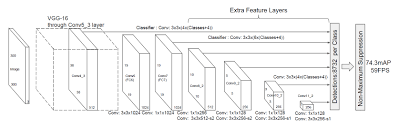

- セマンティックセグメンテーション

従来の画像認識技術で成果を上げているCNNを用いてsemantic segmentationを行う場合、畳み込みとプーリングを経た後の画像を元のサイズまで戻す(upsamplingする)ことが大きな壁となっていた。poolingを行うそもそもの理由は画像認識に必要な受容野を広げるためで、プーリングおよびストライドを使用するか、畳み込み層を深くする
かが考えられるが、後者は計算リソースの観点から難しく、そのためプーリングが使用されている。
これまでにupsamplingの手法としてプーリングを使用しながらupsamplingを行う方法と、poolingを用いず、かつ畳み込み層を深くしない方法が提案されている。

1. プーリング使用しながらupsamplingする方法

プーリングを使用するネットワークでは以下の2つの方法が提案されている。

- Deconvolution/Transposed convolution

通常の畳み込み層と同様びkerrnel size、padding、strideを指定し、特徴マップのpixel間隔をstrideだけ空け、特徴マップのまわりに(kernel size - 1) - paddingだけ余白を作って畳み込み演算を行うことでupsamplingする方法である。しかしながら、poolingで失われたローカルな情報（特に輪郭）が復元されるわけではないため、低レイヤーPooling層の出力をelement-wise additionすることでローカルな情報を補完してからupsamplingを行う。代表的なアーキテクチャとしてU-Netがある。

- Unpooling

max poolingで選択された値の位置情報をswitch variablesとして保持し、upsamplingするときに利用する手法で、DeconvNetで使用されている。

2. プーリングを用いず、かつ畳み込み層を深くしない方法

- Dilated convolution

畳み込み層において、カーネルサイズに余白を設けることで余分な計算を回避しつつ、受容野を広げる手法である。

- U-Net

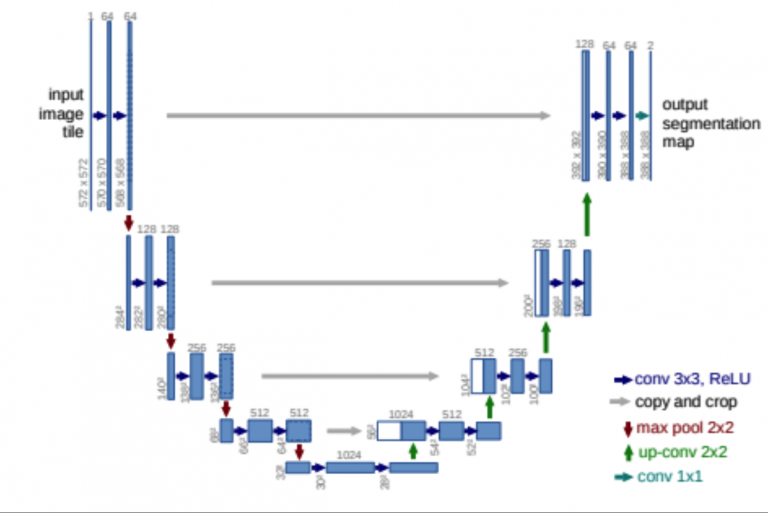

- DeconvNet

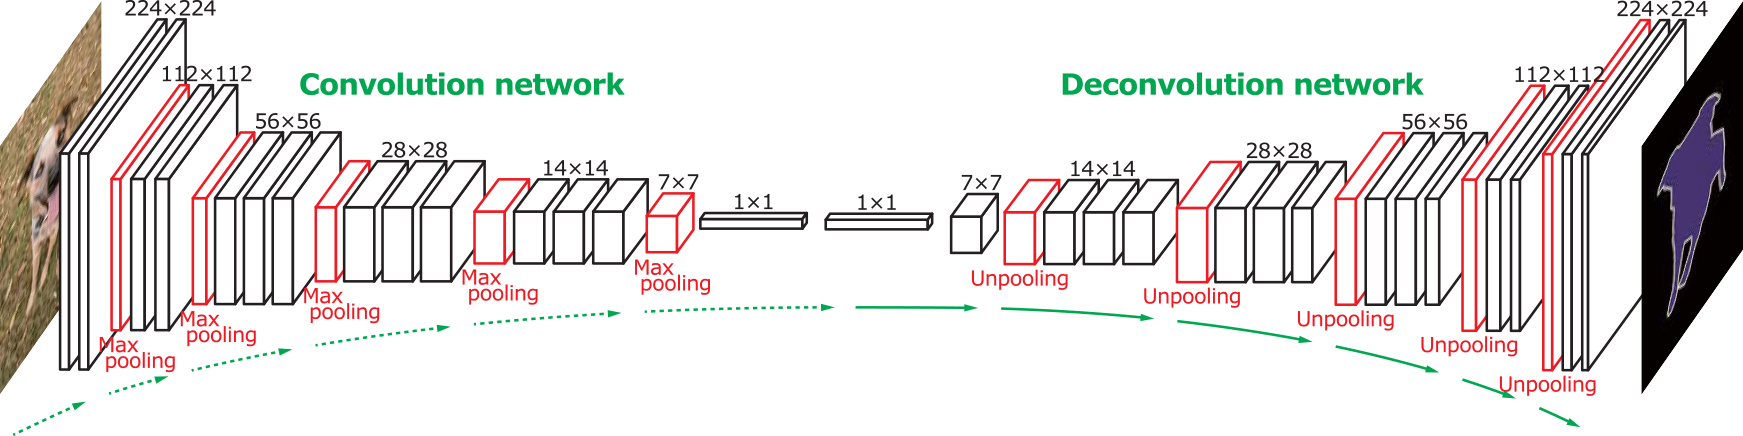